In [1]:
# 24-1. Project: 모델 바꿔보기


#### 라이브러리 버전 확인
---
프로젝트에 사용할 주요 라이브러리 버전을 확인해봅니다.



In [2]:
import tensorflow as tf
import numpy as np
import PIL
import ray

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(ray.__version__)

2.6.0
1.21.4
8.3.2
1.7.0


#### simplebaseline 모델로 변경해 봅시다
---
지금까지 우리는 StackedHourglass Network 기반으로 학습을 진행해 왔습니다.

그러나 지난 시간에 살펴본 것처럼 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바 있습니다.

실제로도 그런 성능을 얻을 수 있을지 확인해 보겠습니다.

In [3]:
# 데이터 전처리하기

# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

print('슝=3')

# json 파싱하기

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

print('슝=3')

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

# TFRecord 파일 만들기

def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

print('슝=3')

def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

print('슝=3')

test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

print('슝=3')

def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

print('슝=3')

# Ray

num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

# data label 로 만들기

def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

print('슝=3')

def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

print('슝=3')

def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

print('슝=3')

class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

print('슝=3')

# # Hourglass 모델 만들기

# def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
#     identity = inputs
#     if downsample:
#         identity = Conv2D(
#             filters=filters,
#             kernel_size=1,
#             strides=strides,
#             padding='same',
#             kernel_initializer='he_normal')(inputs)

#     x = BatchNormalization(momentum=0.9)(inputs)
#     x = ReLU()(x)
#     x = Conv2D(
#         filters=filters // 2,
#         kernel_size=1,
#         strides=1,
#         padding='same',
#         kernel_initializer='he_normal')(x)

#     x = BatchNormalization(momentum=0.9)(x)
#     x = ReLU()(x)
#     x = Conv2D(
#         filters=filters // 2,
#         kernel_size=3,
#         strides=strides,
#         padding='same',
#         kernel_initializer='he_normal')(x)

#     x = BatchNormalization(momentum=0.9)(x)
#     x = ReLU()(x)
#     x = Conv2D(
#         filters=filters,
#         kernel_size=1,
#         strides=1,
#         padding='same',
#         kernel_initializer='he_normal')(x)

#     x = Add()([identity, x])
#     return x

# print('슝=3')

# def HourglassModule(inputs, order, filters, num_residual):
    
#     up1 = BottleneckBlock(inputs, filters, downsample=False)
#     for i in range(num_residual):
#         up1 = BottleneckBlock(up1, filters, downsample=False)

#     low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
#     for i in range(num_residual):
#         low1 = BottleneckBlock(low1, filters, downsample=False)

#     low2 = low1
#     if order > 1:
#         low2 = HourglassModule(low1, order - 1, filters, num_residual)
#     else:
#         for i in range(num_residual):
#             low2 = BottleneckBlock(low2, filters, downsample=False)

#     low3 = low2
#     for i in range(num_residual):
#         low3 = BottleneckBlock(low3, filters, downsample=False)

#     up2 = UpSampling2D(size=2)(low3)

#     return up2 + up1

# print('슝=3')

# def LinearLayer(inputs, filters):
#     x = Conv2D(
#         filters=filters,
#         kernel_size=1,
#         strides=1,
#         padding='same',
#         kernel_initializer='he_normal')(inputs)
#     x = BatchNormalization(momentum=0.9)(x)
#     x = ReLU()(x)
#     return x

# print('슝=3')

# def StackedHourglassNetwork(
#         input_shape=(256, 256, 3), 
#         num_stack=4, 
#         num_residual=1,
#         num_heatmap=16):
    
#     inputs = Input(shape=input_shape)

#     x = Conv2D(
#         filters=64,
#         kernel_size=7,
#         strides=2,
#         padding='same',
#         kernel_initializer='he_normal')(inputs)
#     x = BatchNormalization(momentum=0.9)(x)
#     x = ReLU()(x)
#     x = BottleneckBlock(x, 128, downsample=True)
#     x = MaxPool2D(pool_size=2, strides=2)(x)
#     x = BottleneckBlock(x, 128, downsample=False)
#     x = BottleneckBlock(x, 256, downsample=True)

#     ys = []
#     for i in range(num_stack):
#         x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
#         for i in range(num_residual):
#             x = BottleneckBlock(x, 256, downsample=False)

#         x = LinearLayer(x, 256)

#         y = Conv2D(
#             filters=num_heatmap,
#             kernel_size=1,
#             strides=1,
#             padding='same',
#             kernel_initializer='he_normal')(x)
#         ys.append(y)

#         if i < num_stack - 1:
#             y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
#             y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
#             x = Add()([y_intermediate_1, y_intermediate_2])

#     return tf.keras.Model(inputs, ys, name='stacked_hourglass')

# print('슝=3')

# # 학습 엔진 만들기 (GPU가 여러 개인 환경)

# class Trainer(object):
#     def __init__(self,
#                  model,
#                  epochs,
#                  global_batch_size,
#                  strategy,
#                  initial_learning_rate):
#         self.model = model
#         self.epochs = epochs
#         self.strategy = strategy
#         self.global_batch_size = global_batch_size
#         self.loss_object = tf.keras.losses.MeanSquaredError(
#             reduction=tf.keras.losses.Reduction.NONE)
#         self.optimizer = tf.keras.optimizers.Adam(
#             learning_rate=initial_learning_rate)
#         self.model = model

#         self.current_learning_rate = initial_learning_rate
#         self.last_val_loss = math.inf
#         self.lowest_val_loss = math.inf
#         self.patience_count = 0
#         self.max_patience = 10
#         self.best_model = None

#     def lr_decay(self):
#         if self.patience_count >= self.max_patience:
#             self.current_learning_rate /= 10.0
#             self.patience_count = 0
#         elif self.last_val_loss == self.lowest_val_loss:
#             self.patience_count = 0
#         self.patience_count += 1

#         self.optimizer.learning_rate = self.current_learning_rate

#     def lr_decay_step(self, epoch):
#         if epoch == 25 or epoch == 50 or epoch == 75:
#             self.current_learning_rate /= 10.0
#         self.optimizer.learning_rate = self.current_learning_rate

#     def compute_loss(self, labels, outputs):
#         loss = 0
#         for output in outputs:
#             weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
#             loss += tf.math.reduce_mean(
#                 tf.math.square(labels - output) * weights) * (
#                     1. / self.global_batch_size)
#         return loss

#     def train_step(self, inputs):
#         images, labels = inputs
#         with tf.GradientTape() as tape:
#             outputs = self.model(images, training=True)
#             loss = self.compute_loss(labels, outputs)

#         grads = tape.gradient(
#             target=loss, sources=self.model.trainable_variables)
#         self.optimizer.apply_gradients(
#             zip(grads, self.model.trainable_variables))

#         return loss

#     def val_step(self, inputs):
#         images, labels = inputs
#         outputs = self.model(images, training=False)
#         loss = self.compute_loss(labels, outputs)
#         return loss

#     def run(self, train_dist_dataset, val_dist_dataset):
#         @tf.function
#         def distributed_train_epoch(dataset):
#             tf.print('Start distributed traininng...')
#             total_loss = 0.0
#             num_train_batches = 0.0
#             for one_batch in dataset:
#                 per_replica_loss = self.strategy.run(
#                     self.train_step, args=(one_batch, ))
#                 batch_loss = self.strategy.reduce(
#                     tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
#                 total_loss += batch_loss
#                 num_train_batches += 1
#                 tf.print('Trained batch', num_train_batches, 'batch loss',
#                          batch_loss, 'epoch total loss', total_loss / num_train_batches)
#             return total_loss, num_train_batches

#         @tf.function
#         def distributed_val_epoch(dataset):
#             total_loss = 0.0
#             num_val_batches = 0.0
#             for one_batch in dataset:
#                 per_replica_loss = self.strategy.run(
#                     self.val_step, args=(one_batch, ))
#                 num_val_batches += 1
#                 batch_loss = self.strategy.reduce(
#                     tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
#                 tf.print('Validated batch', num_val_batches, 'batch loss',
#                          batch_loss)
#                 if not tf.math.is_nan(batch_loss):
#                     # TODO: Find out why the last validation batch loss become NaN
#                     total_loss += batch_loss
#                 else:
#                     num_val_batches -= 1

#             return total_loss, num_val_batches

#         for epoch in range(1, self.epochs + 1):
#             self.lr_decay()
#             print('Start epoch {} with learning rate {}'.format(
#                 epoch, self.current_learning_rate))

#             train_total_loss, num_train_batches = distributed_train_epoch(
#                 train_dist_dataset)
#             train_loss = train_total_loss / num_train_batches
#             print('Epoch {} train loss {}'.format(epoch, train_loss))

#             val_total_loss, num_val_batches = distributed_val_epoch(
#                 val_dist_dataset)
#             val_loss = val_total_loss / num_val_batches
#             print('Epoch {} val loss {}'.format(epoch, val_loss))

#             # save model when reach a new lowest validation loss
#             if val_loss < self.lowest_val_loss:
#                 # self.save_model(epoch, val_loss)#∵ 'Read-only file system'
#                 self.lowest_val_loss = val_loss
#             self.last_val_loss = val_loss

#         return self.best_model

#     def save_model(self, epoch, loss):
#         model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
#         self.model.save_weights(model_name)
#         self.best_model = model_name
#         print("Model {} saved.".format(model_name))

# print('슝=3')

# IMAGE_SHAPE = (256, 256, 3)
# HEATMAP_SIZE = (64, 64)

# def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
#     preprocess = Preprocessor(
#         IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

#     dataset = tf.data.Dataset.list_files(tfrecords)
#     dataset = tf.data.TFRecordDataset(dataset)
#     dataset = dataset.map(
#         preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#     if is_train:
#         dataset = dataset.shuffle(batch_size)

#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#     return dataset

# print('슝=3')

# def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
#     strategy = tf.distribute.MirroredStrategy()
#     global_batch_size = strategy.num_replicas_in_sync * batch_size
#     train_dataset = create_dataset(
#         train_tfrecords, global_batch_size, num_heatmap, is_train=True)
#     val_dataset = create_dataset(
#         val_tfrecords, global_batch_size, num_heatmap, is_train=False)

#     if not os.path.exists(MODEL_PATH):
#         os.makedirs(MODEL_PATH)

#     with strategy.scope():
#         train_dist_dataset = strategy.experimental_distribute_dataset(
#             train_dataset)
#         val_dist_dataset = strategy.experimental_distribute_dataset(
#             val_dataset)

#         model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

#         trainer = Trainer(
#             model,
#             epochs,
#             global_batch_size,
#             strategy,
#             initial_learning_rate=learning_rate)

#         print('Start training...')
#         # return trainer.run(train_dist_dataset, val_dist_dataset)
#         trainer.run(train_dist_dataset, val_dist_dataset)
#         return model  # 모델 객체 반환

# print('슝=3')

# # 모델을 학습시킬 차례 (1 Epoch 학습에만 1 시간 가까이 소요됩니다.😮)

# train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
# val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
# epochs = 2
# batch_size = 16
# num_heatmap = 16
# learning_rate = 0.0007

# best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

슝=3
{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}
슝=3
{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1,

2025-06-02 00:53:42,689	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67100672 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.50gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=3230) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=3230) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=3231) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=3231) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=3229) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=3229) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0031_of_0064.tfrecords
(build_single_tfrecord pid=3228) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=3228) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

(build_single_tfrecord pid=3231) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=3231) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=3228) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=3228) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=3230) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=3230) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=3229) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=3229) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

#### STEP 1 : simplebaseline 모델 완성하기
---
```simplebaseline.py``` 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성합니다.



In [4]:
import tensorflow as tf

# resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')# 전역에서 제거

def _make_deconv_layer(num_deconv_layers):
    """
    논문에 따르면:
    - 3개의 deconvolutional layers (기본값)
    - 각 layer: 256 filters, 4x4 kernel, stride=2
    - Batch normalization + ReLU activation
    """
    seq_model = tf.keras.models.Sequential()
    
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(
            filters=256,
            kernel_size=4,
            strides=2,
            padding='same',
            use_bias=False,
            name=f'deconv_{i+1}'
        ))
        seq_model.add(tf.keras.layers.BatchNormalization(name=f'bn_deconv_{i+1}'))
        seq_model.add(tf.keras.layers.ReLU(name=f'relu_deconv_{i+1}'))
    
    return seq_model

upconv = _make_deconv_layer(3)

# 최종 heatmap 생성을 위한 1x1 convolution layer
# MPII 데이터셋은 16개의 keypoint를 가짐
final_layer = tf.keras.layers.Conv2D(
    filters=16,  # 16개의 keypoint
    kernel_size=1, 
    strides=1,
    padding='same',
    name='final_layer'
)


def Simplebaseline(input_shape=(256, 256, 3)):
    """
    Simple Baseline 모델 구성:
    1. ResNet50 backbone (C5 layer까지)
    2. 3개의 deconvolutional layers
    3. 1x1 conv로 최종 heatmap 생성
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    # ResNet을 함수 내부에서 생성 (strategy scope 안에서)
    resnet = tf.keras.applications.resnet.ResNet50(
        include_top=False, 
        weights='imagenet'
    )
    
    # ResNet backbone features 추출
    backbone_features = resnet(inputs)
    
    # Deconvolutional layers로 해상도 증가
    x = upconv(backbone_features)
    
    # 최종 heatmap 생성 (16개 keypoint)
    out = final_layer(x)
    
    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

# # 모델 생성 및 확인
# if __name__ == "__main__":
#     model = Simplebaseline()
#     model.summary()
    
#     # 입력/출력 shape 확인
#     print(f"\n입력 shape: {model.input.shape}")
#     print(f"출력 shape: {model.output.shape}")
    
#     # ResNet backbone의 출력 shape 확인
#     print(f"ResNet backbone 출력 shape: {resnet.output.shape}")
    
#     # Deconv layers 후 shape 확인
#     test_input = tf.keras.Input(shape=(256, 256, 3))
#     backbone_out = resnet(test_input)
#     upconv_out = upconv(backbone_out)
#     print(f"Deconv layers 출력 shape: {upconv_out.shape}")

(build_single_tfrecord pid=3231) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0007_of_0008.tfrecords


#### STEP 2 : simplebaseline 모델로 변경하여 훈련하기
---
StackedHourglass를 학습시킨 코드의 모델 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행합니다.



```
# OSError: Unable to create file (unable to open file: name = '/aiffel/aiffel/mpii/models/simplebaseline-epoch-1-loss-0.1694.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)
# 그래서 파일로 저장하지 않고, 메모리에 있는 모델을 바로 사용하도록 코드 수정 (조금)
```

In [5]:
# 기존 코드에서 최소한의 수정으로 Simplebaseline 사용하기

# 방법 1: compute_loss 함수만 수정 (추천)
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        """
        Single output과 Multiple outputs 모두 처리 가능하도록 수정
        """
        loss = 0
        
        # outputs가 single tensor인지 list인지 확인
        if isinstance(outputs, list):
            # Multiple outputs (StackedHourglass 방식)
            for output in outputs:
                weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
                loss += tf.math.reduce_mean(
                    tf.math.square(labels - output) * weights) * (
                        1. / self.global_batch_size)
        else:
            # Single output (Simplebaseline 방식)
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss = tf.math.reduce_mean(
                tf.math.square(labels - outputs) * weights) * (
                    1. / self.global_batch_size)
        
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                # self.save_model(epoch, val_loss)#∵ 'Read-only file system'
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/simplebaseline-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))


print('슝=3')

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

print('슝=3')

def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
#     # Mixed precision 설정 (메모리 절약)
#     policy = tf.keras.mixed_precision.Policy('mixed_float16')
#     tf.keras.mixed_precision.set_global_policy(policy)
#    
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        # ===== 여기만 변경! =====
        model = Simplebaseline(input_shape=IMAGE_SHAPE)  # StackedHourglassNetwork → Simplebaseline
        # ========================

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start Simple Baseline training...')
        # return trainer.run(train_dist_dataset, val_dist_dataset)
        trainer.run(train_dist_dataset, val_dist_dataset)
        return model  # 모델 객체 반환

print('슝=3')

# 모델을 학습시킬 차례
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5#2
batch_size = 4#16#배치 사이즈 줄이기 (cf. Mixed Precision 사용 (메모리 절약), Square root scaling vs. 고정 (No Scaling))
num_heatmap = 16
learning_rate = 0.0003  # sqrt(4/16) * 0.0007 ≈ 0.00035#0.0007

# best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

슝=3
슝=3
슝=3


#### STEP 3 : 두 모델의 비교
---
실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해 봅니다.

* Pose Estimation 결과 시각화 (정성적 비교)
* 학습 진행 경과 (loss 감소 현황)

가급적 두 모델 모두 최소 3epoch 이상, (5epoch 이상 권장)을 학습하기 바랍니다.

- GPU 메모리 부족 (OOM - Out Of Memory) 오류가 발생  
ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[512,128,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while/body/_10/while/simple_baseline/resnet50/conv3_block2_3_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[while/body/_10/while/mul_2/_156]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) Resource exhausted:  OOM when allocating tensor with shape[512,128,1,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node while/body/_10/while/simple_baseline/resnet50/conv3_block2_3_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_train_epoch_45880]

Function call stack:
distributed_train_epoch -> distributed_train_epoch

In [6]:
# 예측 엔진 만들기

# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')

# model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
# model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# model.load_weights(best_model_file)
model = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)
# 끝! 파일 로딩 불필요

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 2.60709143 epoch total loss 2.60709143
Trained batch 2 batch loss 2.3636384 epoch total loss 2.48536491
Trained batch 3 batch loss 2.25322723 epoch total loss 2.40798569
Trained batch 4 batch loss 2.14659786 epoch total loss 2.34263873
Trained batch 5 batch loss 2.05998516 epoch total loss 2.28610802
Trained batch 6 batch loss 2.07190681 epoch total loss 2.25040793
Trained batch 7 batch loss 1.95897818 epoch total loss 2.20877504
Trained batch 8 batch loss 2.06533909 epoch total loss 2.19084549
Trained batch 9 batch loss 1.9038173 epoch total loss 2.15895367
Trained batch 10 batch loss 2.02266026 epoch total loss 2.14532423
Trained batch 11 batch loss 2.04864979 epoch total loss 2.13653564
Trained batch 12 batch loss 1.94831634 epoch total loss 2.1208508
Trained batch 13 batch loss 1.81419253 epoch total loss 2.09726167
Trained batch 14 batch loss 1.86013269 epoch total loss 2.0803237
Trained batch 15 batch loss 1.89640343 epoch

Trained batch 124 batch loss 1.66970336 epoch total loss 1.66742742
Trained batch 125 batch loss 1.41676617 epoch total loss 1.66542208
Trained batch 126 batch loss 1.6666069 epoch total loss 1.6654315
Trained batch 127 batch loss 1.44044805 epoch total loss 1.66366
Trained batch 128 batch loss 1.50841737 epoch total loss 1.66244721
Trained batch 129 batch loss 1.69038343 epoch total loss 1.66266382
Trained batch 130 batch loss 1.66647422 epoch total loss 1.66269302
Trained batch 131 batch loss 1.69355226 epoch total loss 1.6629287
Trained batch 132 batch loss 1.58145463 epoch total loss 1.66231143
Trained batch 133 batch loss 1.35052919 epoch total loss 1.65996718
Trained batch 134 batch loss 1.33438492 epoch total loss 1.65753746
Trained batch 135 batch loss 1.29957676 epoch total loss 1.65488589
Trained batch 136 batch loss 1.42880285 epoch total loss 1.65322351
Trained batch 137 batch loss 1.34390342 epoch total loss 1.65096569
Trained batch 138 batch loss 1.4767108 epoch total los

Trained batch 246 batch loss 1.58165717 epoch total loss 1.57046795
Trained batch 247 batch loss 1.7101475 epoch total loss 1.57103348
Trained batch 248 batch loss 1.62784421 epoch total loss 1.57126248
Trained batch 249 batch loss 1.62506962 epoch total loss 1.57147849
Trained batch 250 batch loss 1.63734889 epoch total loss 1.57174206
Trained batch 251 batch loss 1.63325512 epoch total loss 1.57198715
Trained batch 252 batch loss 1.64699209 epoch total loss 1.57228494
Trained batch 253 batch loss 1.72998226 epoch total loss 1.57290816
Trained batch 254 batch loss 1.68922675 epoch total loss 1.57336617
Trained batch 255 batch loss 1.64966989 epoch total loss 1.57366538
Trained batch 256 batch loss 1.63196874 epoch total loss 1.57389307
Trained batch 257 batch loss 1.58131874 epoch total loss 1.57392204
Trained batch 258 batch loss 1.59131455 epoch total loss 1.57398939
Trained batch 259 batch loss 1.61034203 epoch total loss 1.57412982
Trained batch 260 batch loss 1.59337306 epoch tot

Trained batch 367 batch loss 1.27542615 epoch total loss 1.54726696
Trained batch 368 batch loss 1.23060536 epoch total loss 1.54640651
Trained batch 369 batch loss 1.20093083 epoch total loss 1.54547024
Trained batch 370 batch loss 1.28131962 epoch total loss 1.54475629
Trained batch 371 batch loss 1.20300865 epoch total loss 1.54383504
Trained batch 372 batch loss 1.33604479 epoch total loss 1.54327655
Trained batch 373 batch loss 1.39713407 epoch total loss 1.54288483
Trained batch 374 batch loss 1.40691781 epoch total loss 1.54252124
Trained batch 375 batch loss 1.61802745 epoch total loss 1.5427227
Trained batch 376 batch loss 1.59383559 epoch total loss 1.54285848
Trained batch 377 batch loss 1.70607257 epoch total loss 1.54329145
Trained batch 378 batch loss 1.62309539 epoch total loss 1.54350257
Trained batch 379 batch loss 1.58192456 epoch total loss 1.5436039
Trained batch 380 batch loss 1.68120575 epoch total loss 1.54396605
Trained batch 381 batch loss 1.59693456 epoch tota

Trained batch 488 batch loss 1.58536172 epoch total loss 1.53508317
Trained batch 489 batch loss 1.54029393 epoch total loss 1.53509378
Trained batch 490 batch loss 1.68854284 epoch total loss 1.53540695
Trained batch 491 batch loss 1.83514404 epoch total loss 1.53601742
Trained batch 492 batch loss 1.5564549 epoch total loss 1.53605902
Trained batch 493 batch loss 1.71054459 epoch total loss 1.53641295
Trained batch 494 batch loss 1.60270262 epoch total loss 1.53654718
Trained batch 495 batch loss 1.37396038 epoch total loss 1.53621876
Trained batch 496 batch loss 1.61555767 epoch total loss 1.53637862
Trained batch 497 batch loss 1.53190506 epoch total loss 1.53636968
Trained batch 498 batch loss 1.56448054 epoch total loss 1.53642607
Trained batch 499 batch loss 1.38370752 epoch total loss 1.53612
Trained batch 500 batch loss 1.26820433 epoch total loss 1.53558421
Trained batch 501 batch loss 1.31535542 epoch total loss 1.53514469
Trained batch 502 batch loss 1.14269364 epoch total 

Trained batch 609 batch loss 1.37819493 epoch total loss 1.52336466
Trained batch 610 batch loss 1.56890225 epoch total loss 1.52343929
Trained batch 611 batch loss 1.29564977 epoch total loss 1.52306652
Trained batch 612 batch loss 1.42358744 epoch total loss 1.52290392
Trained batch 613 batch loss 1.42814088 epoch total loss 1.52274942
Trained batch 614 batch loss 1.16282487 epoch total loss 1.52216327
Trained batch 615 batch loss 1.46407366 epoch total loss 1.52206874
Trained batch 616 batch loss 1.5003233 epoch total loss 1.52203345
Trained batch 617 batch loss 1.40816736 epoch total loss 1.5218488
Trained batch 618 batch loss 1.51631117 epoch total loss 1.52183986
Trained batch 619 batch loss 1.50987291 epoch total loss 1.52182055
Trained batch 620 batch loss 1.49888563 epoch total loss 1.52178359
Trained batch 621 batch loss 1.5623759 epoch total loss 1.52184892
Trained batch 622 batch loss 1.39522386 epoch total loss 1.52164531
Trained batch 623 batch loss 1.48052359 epoch total

Trained batch 731 batch loss 1.36345243 epoch total loss 1.50308967
Trained batch 732 batch loss 1.31604874 epoch total loss 1.50283408
Trained batch 733 batch loss 1.24821043 epoch total loss 1.50248671
Trained batch 734 batch loss 1.26201344 epoch total loss 1.502159
Trained batch 735 batch loss 1.36184466 epoch total loss 1.50196803
Trained batch 736 batch loss 1.23043406 epoch total loss 1.50159919
Trained batch 737 batch loss 1.35552204 epoch total loss 1.50140095
Trained batch 738 batch loss 1.44360149 epoch total loss 1.50132263
Trained batch 739 batch loss 1.2304697 epoch total loss 1.50095606
Trained batch 740 batch loss 1.38358068 epoch total loss 1.50079739
Trained batch 741 batch loss 1.41999078 epoch total loss 1.50068843
Trained batch 742 batch loss 1.43526769 epoch total loss 1.50060034
Trained batch 743 batch loss 1.5212822 epoch total loss 1.50062811
Trained batch 744 batch loss 1.53340399 epoch total loss 1.50067222
Trained batch 745 batch loss 1.35225701 epoch total 

Trained batch 852 batch loss 1.59079993 epoch total loss 1.49055719
Trained batch 853 batch loss 1.43729663 epoch total loss 1.49049473
Trained batch 854 batch loss 1.40150118 epoch total loss 1.49039042
Trained batch 855 batch loss 1.49701881 epoch total loss 1.49039829
Trained batch 856 batch loss 1.3769027 epoch total loss 1.49026573
Trained batch 857 batch loss 1.49655151 epoch total loss 1.49027312
Trained batch 858 batch loss 1.37970221 epoch total loss 1.49014437
Trained batch 859 batch loss 1.46462655 epoch total loss 1.49011457
Trained batch 860 batch loss 1.27838147 epoch total loss 1.4898684
Trained batch 861 batch loss 1.3364203 epoch total loss 1.48969018
Trained batch 862 batch loss 1.26043 epoch total loss 1.48942423
Trained batch 863 batch loss 1.30978298 epoch total loss 1.48921609
Trained batch 864 batch loss 1.21042681 epoch total loss 1.48889339
Trained batch 865 batch loss 1.31470728 epoch total loss 1.48869205
Trained batch 866 batch loss 1.40178108 epoch total lo

Trained batch 974 batch loss 1.3807385 epoch total loss 1.47595656
Trained batch 975 batch loss 1.29827964 epoch total loss 1.47577441
Trained batch 976 batch loss 1.3591373 epoch total loss 1.47565484
Trained batch 977 batch loss 1.50346518 epoch total loss 1.47568321
Trained batch 978 batch loss 1.39110851 epoch total loss 1.47559679
Trained batch 979 batch loss 1.35248542 epoch total loss 1.47547114
Trained batch 980 batch loss 1.20876908 epoch total loss 1.47519898
Trained batch 981 batch loss 1.34169936 epoch total loss 1.47506285
Trained batch 982 batch loss 1.24456334 epoch total loss 1.474828
Trained batch 983 batch loss 1.41665471 epoch total loss 1.47476888
Trained batch 984 batch loss 1.43171585 epoch total loss 1.47472513
Trained batch 985 batch loss 1.35252333 epoch total loss 1.47460103
Trained batch 986 batch loss 1.35051346 epoch total loss 1.47447515
Trained batch 987 batch loss 1.43118072 epoch total loss 1.47443128
Trained batch 988 batch loss 1.49578524 epoch total 

Trained batch 1094 batch loss 1.37250972 epoch total loss 1.47047019
Trained batch 1095 batch loss 1.36739564 epoch total loss 1.47037601
Trained batch 1096 batch loss 1.46782982 epoch total loss 1.47037363
Trained batch 1097 batch loss 1.40237021 epoch total loss 1.47031164
Trained batch 1098 batch loss 1.35855627 epoch total loss 1.47020984
Trained batch 1099 batch loss 1.28948045 epoch total loss 1.47004533
Trained batch 1100 batch loss 1.14910293 epoch total loss 1.4697535
Trained batch 1101 batch loss 1.32573581 epoch total loss 1.46962273
Trained batch 1102 batch loss 1.37406874 epoch total loss 1.46953595
Trained batch 1103 batch loss 1.42310846 epoch total loss 1.46949387
Trained batch 1104 batch loss 1.46370125 epoch total loss 1.46948862
Trained batch 1105 batch loss 1.25212252 epoch total loss 1.46929181
Trained batch 1106 batch loss 1.43097 epoch total loss 1.46925724
Trained batch 1107 batch loss 1.39976752 epoch total loss 1.46919453
Trained batch 1108 batch loss 1.385711

Trained batch 1214 batch loss 1.44382226 epoch total loss 1.45535934
Trained batch 1215 batch loss 1.1829145 epoch total loss 1.45513511
Trained batch 1216 batch loss 1.12738824 epoch total loss 1.45486557
Trained batch 1217 batch loss 1.12059367 epoch total loss 1.45459092
Trained batch 1218 batch loss 1.32271528 epoch total loss 1.45448267
Trained batch 1219 batch loss 1.18479133 epoch total loss 1.45426154
Trained batch 1220 batch loss 0.945262909 epoch total loss 1.45384431
Trained batch 1221 batch loss 1.01489174 epoch total loss 1.45348477
Trained batch 1222 batch loss 1.21800339 epoch total loss 1.45329213
Trained batch 1223 batch loss 1.55279243 epoch total loss 1.45337343
Trained batch 1224 batch loss 1.37460291 epoch total loss 1.45330906
Trained batch 1225 batch loss 1.41427183 epoch total loss 1.45327723
Trained batch 1226 batch loss 1.54554844 epoch total loss 1.45335257
Trained batch 1227 batch loss 1.55811846 epoch total loss 1.45343792
Trained batch 1228 batch loss 1.54

Trained batch 1334 batch loss 1.24056482 epoch total loss 1.44947803
Trained batch 1335 batch loss 1.30470586 epoch total loss 1.44936967
Trained batch 1336 batch loss 1.12638235 epoch total loss 1.44912779
Trained batch 1337 batch loss 1.24362254 epoch total loss 1.44897413
Trained batch 1338 batch loss 1.17051542 epoch total loss 1.44876599
Trained batch 1339 batch loss 1.45703208 epoch total loss 1.44877219
Trained batch 1340 batch loss 1.37719047 epoch total loss 1.44871879
Trained batch 1341 batch loss 1.41449869 epoch total loss 1.44869328
Trained batch 1342 batch loss 1.42669773 epoch total loss 1.44867694
Trained batch 1343 batch loss 1.41034198 epoch total loss 1.44864845
Trained batch 1344 batch loss 1.53053927 epoch total loss 1.44870937
Trained batch 1345 batch loss 1.43546963 epoch total loss 1.44869947
Trained batch 1346 batch loss 1.44300723 epoch total loss 1.4486953
Trained batch 1347 batch loss 1.14966476 epoch total loss 1.44847333
Trained batch 1348 batch loss 1.253

Trained batch 1454 batch loss 1.3943547 epoch total loss 1.44471502
Trained batch 1455 batch loss 1.25421119 epoch total loss 1.44458413
Trained batch 1456 batch loss 1.38185024 epoch total loss 1.44454098
Trained batch 1457 batch loss 1.31667209 epoch total loss 1.44445324
Trained batch 1458 batch loss 1.39125454 epoch total loss 1.44441676
Trained batch 1459 batch loss 1.34487474 epoch total loss 1.44434869
Trained batch 1460 batch loss 1.50021887 epoch total loss 1.44438696
Trained batch 1461 batch loss 1.44122994 epoch total loss 1.44438469
Trained batch 1462 batch loss 1.29939902 epoch total loss 1.44428551
Trained batch 1463 batch loss 1.0751555 epoch total loss 1.44403327
Trained batch 1464 batch loss 1.28822732 epoch total loss 1.44392681
Trained batch 1465 batch loss 1.23887575 epoch total loss 1.44378686
Trained batch 1466 batch loss 1.34756422 epoch total loss 1.44372129
Trained batch 1467 batch loss 1.28091681 epoch total loss 1.44361031
Trained batch 1468 batch loss 1.3627

Trained batch 1574 batch loss 1.36189973 epoch total loss 1.43863773
Trained batch 1575 batch loss 1.37426043 epoch total loss 1.43859684
Trained batch 1576 batch loss 1.3366344 epoch total loss 1.43853223
Trained batch 1577 batch loss 1.35686028 epoch total loss 1.43848038
Trained batch 1578 batch loss 1.4868865 epoch total loss 1.43851101
Trained batch 1579 batch loss 1.39832282 epoch total loss 1.43848574
Trained batch 1580 batch loss 1.5244801 epoch total loss 1.4385401
Trained batch 1581 batch loss 1.57253718 epoch total loss 1.43862486
Trained batch 1582 batch loss 1.51901913 epoch total loss 1.43867564
Trained batch 1583 batch loss 1.5279038 epoch total loss 1.43873191
Trained batch 1584 batch loss 1.5771451 epoch total loss 1.43881929
Trained batch 1585 batch loss 1.59798932 epoch total loss 1.43891966
Trained batch 1586 batch loss 1.59420383 epoch total loss 1.43901765
Trained batch 1587 batch loss 1.47199607 epoch total loss 1.4390384
Trained batch 1588 batch loss 1.45549917 

Trained batch 1694 batch loss 1.10104477 epoch total loss 1.43751931
Trained batch 1695 batch loss 1.43995142 epoch total loss 1.43752074
Trained batch 1696 batch loss 1.59407461 epoch total loss 1.43761301
Trained batch 1697 batch loss 1.49444091 epoch total loss 1.43764651
Trained batch 1698 batch loss 1.435027 epoch total loss 1.43764496
Trained batch 1699 batch loss 1.51108813 epoch total loss 1.43768811
Trained batch 1700 batch loss 1.40719676 epoch total loss 1.43767023
Trained batch 1701 batch loss 1.43898869 epoch total loss 1.43767095
Trained batch 1702 batch loss 1.08912206 epoch total loss 1.43746614
Trained batch 1703 batch loss 1.37062168 epoch total loss 1.43742692
Trained batch 1704 batch loss 1.45205379 epoch total loss 1.43743551
Trained batch 1705 batch loss 1.34959018 epoch total loss 1.43738401
Trained batch 1706 batch loss 1.49010444 epoch total loss 1.43741488
Trained batch 1707 batch loss 1.49488378 epoch total loss 1.4374485
Trained batch 1708 batch loss 1.31183

Trained batch 1814 batch loss 1.07619143 epoch total loss 1.43285275
Trained batch 1815 batch loss 1.37677753 epoch total loss 1.43282175
Trained batch 1816 batch loss 1.17781663 epoch total loss 1.43268132
Trained batch 1817 batch loss 1.17852473 epoch total loss 1.43254137
Trained batch 1818 batch loss 1.39591467 epoch total loss 1.43252134
Trained batch 1819 batch loss 1.2569 epoch total loss 1.43242466
Trained batch 1820 batch loss 1.33887362 epoch total loss 1.43237329
Trained batch 1821 batch loss 1.56756139 epoch total loss 1.43244755
Trained batch 1822 batch loss 1.45058537 epoch total loss 1.43245757
Trained batch 1823 batch loss 1.47939348 epoch total loss 1.43248343
Trained batch 1824 batch loss 1.34614801 epoch total loss 1.43243611
Trained batch 1825 batch loss 1.25944448 epoch total loss 1.43234134
Trained batch 1826 batch loss 1.39024663 epoch total loss 1.43231821
Trained batch 1827 batch loss 1.59886813 epoch total loss 1.43240941
Trained batch 1828 batch loss 1.459590

Trained batch 1934 batch loss 1.426687 epoch total loss 1.4270097
Trained batch 1935 batch loss 1.35357845 epoch total loss 1.42697167
Trained batch 1936 batch loss 1.17522216 epoch total loss 1.42684162
Trained batch 1937 batch loss 1.29063535 epoch total loss 1.42677128
Trained batch 1938 batch loss 1.41598856 epoch total loss 1.4267658
Trained batch 1939 batch loss 1.26030612 epoch total loss 1.42667985
Trained batch 1940 batch loss 1.35569859 epoch total loss 1.42664325
Trained batch 1941 batch loss 1.20720601 epoch total loss 1.42653024
Trained batch 1942 batch loss 1.09365392 epoch total loss 1.42635894
Trained batch 1943 batch loss 0.966899514 epoch total loss 1.42612243
Trained batch 1944 batch loss 1.10610747 epoch total loss 1.4259578
Trained batch 1945 batch loss 1.33220148 epoch total loss 1.42590964
Trained batch 1946 batch loss 1.23180532 epoch total loss 1.42580986
Trained batch 1947 batch loss 1.42021441 epoch total loss 1.425807
Trained batch 1948 batch loss 0.96101760

Trained batch 2054 batch loss 1.19107723 epoch total loss 1.42006838
Trained batch 2055 batch loss 1.42159057 epoch total loss 1.42006922
Trained batch 2056 batch loss 1.28324127 epoch total loss 1.42000258
Trained batch 2057 batch loss 1.14402103 epoch total loss 1.41986847
Trained batch 2058 batch loss 1.11539221 epoch total loss 1.41972053
Trained batch 2059 batch loss 1.37327266 epoch total loss 1.419698
Trained batch 2060 batch loss 1.19542384 epoch total loss 1.41958904
Trained batch 2061 batch loss 1.39637899 epoch total loss 1.41957784
Trained batch 2062 batch loss 1.4918611 epoch total loss 1.419613
Trained batch 2063 batch loss 1.43611169 epoch total loss 1.41962087
Trained batch 2064 batch loss 1.11523128 epoch total loss 1.41947341
Trained batch 2065 batch loss 1.43387437 epoch total loss 1.41948044
Trained batch 2066 batch loss 1.38361907 epoch total loss 1.41946304
Trained batch 2067 batch loss 1.48549271 epoch total loss 1.41949499
Trained batch 2068 batch loss 1.1430413

Trained batch 2174 batch loss 1.35629857 epoch total loss 1.41467941
Trained batch 2175 batch loss 1.40777946 epoch total loss 1.41467619
Trained batch 2176 batch loss 1.22502053 epoch total loss 1.41458905
Trained batch 2177 batch loss 1.18912125 epoch total loss 1.41448545
Trained batch 2178 batch loss 1.14363384 epoch total loss 1.41436112
Trained batch 2179 batch loss 1.28317308 epoch total loss 1.41430092
Trained batch 2180 batch loss 1.29885864 epoch total loss 1.41424799
Trained batch 2181 batch loss 1.21330667 epoch total loss 1.41415584
Trained batch 2182 batch loss 1.32429552 epoch total loss 1.41411459
Trained batch 2183 batch loss 1.32579374 epoch total loss 1.41407418
Trained batch 2184 batch loss 1.38780022 epoch total loss 1.41406202
Trained batch 2185 batch loss 1.30133557 epoch total loss 1.41401041
Trained batch 2186 batch loss 1.28933203 epoch total loss 1.41395342
Trained batch 2187 batch loss 1.45967329 epoch total loss 1.41397429
Trained batch 2188 batch loss 1.31

Trained batch 2294 batch loss 1.08503568 epoch total loss 1.40916526
Trained batch 2295 batch loss 1.41926324 epoch total loss 1.40916955
Trained batch 2296 batch loss 1.02630925 epoch total loss 1.4090029
Trained batch 2297 batch loss 1.31725955 epoch total loss 1.40896285
Trained batch 2298 batch loss 1.28572035 epoch total loss 1.4089092
Trained batch 2299 batch loss 1.31628823 epoch total loss 1.40886891
Trained batch 2300 batch loss 1.30199695 epoch total loss 1.40882254
Trained batch 2301 batch loss 1.36890244 epoch total loss 1.40880513
Trained batch 2302 batch loss 1.12959898 epoch total loss 1.4086839
Trained batch 2303 batch loss 1.07836819 epoch total loss 1.40854049
Trained batch 2304 batch loss 0.962164521 epoch total loss 1.40834665
Trained batch 2305 batch loss 1.24452877 epoch total loss 1.40827572
Trained batch 2306 batch loss 1.06960702 epoch total loss 1.40812886
Trained batch 2307 batch loss 1.23555803 epoch total loss 1.40805399
Trained batch 2308 batch loss 1.1468

Trained batch 2414 batch loss 1.52642596 epoch total loss 1.40304327
Trained batch 2415 batch loss 1.21340537 epoch total loss 1.40296471
Trained batch 2416 batch loss 1.27479219 epoch total loss 1.40291178
Trained batch 2417 batch loss 1.29332435 epoch total loss 1.40286636
Trained batch 2418 batch loss 1.38524318 epoch total loss 1.40285909
Trained batch 2419 batch loss 1.26236773 epoch total loss 1.40280104
Trained batch 2420 batch loss 1.30695 epoch total loss 1.40276146
Trained batch 2421 batch loss 1.64473534 epoch total loss 1.40286136
Trained batch 2422 batch loss 1.52552855 epoch total loss 1.40291202
Trained batch 2423 batch loss 1.59642315 epoch total loss 1.40299189
Trained batch 2424 batch loss 1.62844992 epoch total loss 1.40308499
Trained batch 2425 batch loss 1.57043362 epoch total loss 1.4031539
Trained batch 2426 batch loss 1.4251579 epoch total loss 1.40316296
Trained batch 2427 batch loss 1.52849972 epoch total loss 1.40321457
Trained batch 2428 batch loss 1.5881245

Trained batch 2534 batch loss 1.17752564 epoch total loss 1.39898956
Trained batch 2535 batch loss 1.07585156 epoch total loss 1.39886212
Trained batch 2536 batch loss 1.16141772 epoch total loss 1.39876842
Trained batch 2537 batch loss 1.15750849 epoch total loss 1.39867342
Trained batch 2538 batch loss 1.19641018 epoch total loss 1.39859366
Trained batch 2539 batch loss 1.19952071 epoch total loss 1.39851522
Trained batch 2540 batch loss 1.19201875 epoch total loss 1.39843392
Trained batch 2541 batch loss 1.17199624 epoch total loss 1.39834476
Trained batch 2542 batch loss 1.42149925 epoch total loss 1.39835382
Trained batch 2543 batch loss 1.51283097 epoch total loss 1.39839888
Trained batch 2544 batch loss 1.32204914 epoch total loss 1.39836884
Trained batch 2545 batch loss 1.28900385 epoch total loss 1.39832592
Trained batch 2546 batch loss 1.3005445 epoch total loss 1.39828753
Trained batch 2547 batch loss 1.43601334 epoch total loss 1.39830232
Trained batch 2548 batch loss 1.279

Trained batch 2654 batch loss 1.20898235 epoch total loss 1.39562905
Trained batch 2655 batch loss 1.12549686 epoch total loss 1.39552736
Trained batch 2656 batch loss 1.19501376 epoch total loss 1.39545178
Trained batch 2657 batch loss 1.12101352 epoch total loss 1.39534855
Trained batch 2658 batch loss 1.3422637 epoch total loss 1.39532864
Trained batch 2659 batch loss 1.30379772 epoch total loss 1.39529419
Trained batch 2660 batch loss 1.3375771 epoch total loss 1.39527249
Trained batch 2661 batch loss 1.34655762 epoch total loss 1.39525425
Trained batch 2662 batch loss 1.38907099 epoch total loss 1.39525199
Trained batch 2663 batch loss 1.5833391 epoch total loss 1.39532256
Trained batch 2664 batch loss 1.48316503 epoch total loss 1.39535546
Trained batch 2665 batch loss 1.3733325 epoch total loss 1.39534724
Trained batch 2666 batch loss 1.28597188 epoch total loss 1.39530611
Trained batch 2667 batch loss 1.32188535 epoch total loss 1.39527857
Trained batch 2668 batch loss 1.312403

Trained batch 2774 batch loss 1.2444756 epoch total loss 1.39027727
Trained batch 2775 batch loss 1.35454202 epoch total loss 1.39026439
Trained batch 2776 batch loss 1.23125529 epoch total loss 1.39020705
Trained batch 2777 batch loss 1.31262016 epoch total loss 1.39017904
Trained batch 2778 batch loss 1.48505378 epoch total loss 1.39021325
Trained batch 2779 batch loss 1.51183915 epoch total loss 1.390257
Trained batch 2780 batch loss 1.18401742 epoch total loss 1.39018285
Trained batch 2781 batch loss 1.21096468 epoch total loss 1.39011836
Trained batch 2782 batch loss 1.32442069 epoch total loss 1.39009476
Trained batch 2783 batch loss 1.3796792 epoch total loss 1.39009106
Trained batch 2784 batch loss 1.47423184 epoch total loss 1.39012122
Trained batch 2785 batch loss 1.34899569 epoch total loss 1.39010644
Trained batch 2786 batch loss 1.3506881 epoch total loss 1.39009225
Trained batch 2787 batch loss 1.62996519 epoch total loss 1.3901782
Trained batch 2788 batch loss 1.47410727

Trained batch 2894 batch loss 1.1383121 epoch total loss 1.38814616
Trained batch 2895 batch loss 1.37940598 epoch total loss 1.38814306
Trained batch 2896 batch loss 1.35299587 epoch total loss 1.38813102
Trained batch 2897 batch loss 1.46060252 epoch total loss 1.38815606
Trained batch 2898 batch loss 1.47777534 epoch total loss 1.38818693
Trained batch 2899 batch loss 1.366552 epoch total loss 1.38817942
Trained batch 2900 batch loss 1.24053717 epoch total loss 1.38812852
Trained batch 2901 batch loss 1.13404799 epoch total loss 1.3880409
Trained batch 2902 batch loss 1.28487265 epoch total loss 1.38800538
Trained batch 2903 batch loss 1.38880014 epoch total loss 1.38800573
Trained batch 2904 batch loss 1.01184464 epoch total loss 1.38787627
Trained batch 2905 batch loss 1.21574616 epoch total loss 1.38781703
Trained batch 2906 batch loss 1.13040686 epoch total loss 1.38772845
Trained batch 2907 batch loss 1.41799247 epoch total loss 1.38773882
Trained batch 2908 batch loss 1.453072

Trained batch 3014 batch loss 1.0494566 epoch total loss 1.38458979
Trained batch 3015 batch loss 1.05751419 epoch total loss 1.38448143
Trained batch 3016 batch loss 1.1118722 epoch total loss 1.38439095
Trained batch 3017 batch loss 1.04539895 epoch total loss 1.38427866
Trained batch 3018 batch loss 1.11796916 epoch total loss 1.38419044
Trained batch 3019 batch loss 1.13350463 epoch total loss 1.38410735
Trained batch 3020 batch loss 1.30421078 epoch total loss 1.38408089
Trained batch 3021 batch loss 1.3115561 epoch total loss 1.38405693
Trained batch 3022 batch loss 1.19830346 epoch total loss 1.38399541
Trained batch 3023 batch loss 1.18859673 epoch total loss 1.38393068
Trained batch 3024 batch loss 1.47980845 epoch total loss 1.38396251
Trained batch 3025 batch loss 1.33676124 epoch total loss 1.3839469
Trained batch 3026 batch loss 0.976279497 epoch total loss 1.38381219
Trained batch 3027 batch loss 1.18561816 epoch total loss 1.38374662
Trained batch 3028 batch loss 1.38127

Trained batch 3134 batch loss 1.1501317 epoch total loss 1.38085079
Trained batch 3135 batch loss 1.08109558 epoch total loss 1.38075519
Trained batch 3136 batch loss 0.99898535 epoch total loss 1.38063347
Trained batch 3137 batch loss 1.14699852 epoch total loss 1.38055897
Trained batch 3138 batch loss 1.11957717 epoch total loss 1.38047576
Trained batch 3139 batch loss 1.04354322 epoch total loss 1.38036847
Trained batch 3140 batch loss 1.08822715 epoch total loss 1.38027549
Trained batch 3141 batch loss 1.34357715 epoch total loss 1.38026381
Trained batch 3142 batch loss 1.12571502 epoch total loss 1.38018274
Trained batch 3143 batch loss 1.41284227 epoch total loss 1.38019323
Trained batch 3144 batch loss 1.42969227 epoch total loss 1.38020897
Trained batch 3145 batch loss 1.28444731 epoch total loss 1.38017857
Trained batch 3146 batch loss 1.22915399 epoch total loss 1.38013053
Trained batch 3147 batch loss 0.986044645 epoch total loss 1.38000524
Trained batch 3148 batch loss 1.28

Trained batch 3254 batch loss 1.33595824 epoch total loss 1.37814069
Trained batch 3255 batch loss 1.28525662 epoch total loss 1.37811208
Trained batch 3256 batch loss 1.05816734 epoch total loss 1.37801385
Trained batch 3257 batch loss 1.2404182 epoch total loss 1.37797153
Trained batch 3258 batch loss 1.17802095 epoch total loss 1.37791026
Trained batch 3259 batch loss 1.12381697 epoch total loss 1.37783229
Trained batch 3260 batch loss 1.19772279 epoch total loss 1.3777771
Trained batch 3261 batch loss 1.17000854 epoch total loss 1.37771332
Trained batch 3262 batch loss 1.30730581 epoch total loss 1.37769163
Trained batch 3263 batch loss 1.09084988 epoch total loss 1.37760377
Trained batch 3264 batch loss 1.25857449 epoch total loss 1.37756741
Trained batch 3265 batch loss 1.2500627 epoch total loss 1.37752831
Trained batch 3266 batch loss 1.04476428 epoch total loss 1.37742651
Trained batch 3267 batch loss 1.20745289 epoch total loss 1.37737441
Trained batch 3268 batch loss 1.11026

Trained batch 3374 batch loss 1.24600649 epoch total loss 1.37466919
Trained batch 3375 batch loss 1.26584601 epoch total loss 1.37463689
Trained batch 3376 batch loss 1.41218615 epoch total loss 1.37464797
Trained batch 3377 batch loss 1.08227563 epoch total loss 1.37456143
Trained batch 3378 batch loss 1.11116624 epoch total loss 1.37448359
Trained batch 3379 batch loss 1.19046187 epoch total loss 1.37442911
Trained batch 3380 batch loss 1.22177708 epoch total loss 1.37438393
Trained batch 3381 batch loss 1.20068145 epoch total loss 1.37433255
Trained batch 3382 batch loss 1.36073017 epoch total loss 1.37432849
Trained batch 3383 batch loss 1.41174817 epoch total loss 1.37433958
Trained batch 3384 batch loss 1.23026466 epoch total loss 1.37429702
Trained batch 3385 batch loss 1.27250957 epoch total loss 1.37426698
Trained batch 3386 batch loss 1.29427099 epoch total loss 1.37424338
Trained batch 3387 batch loss 1.51892185 epoch total loss 1.37428606
Trained batch 3388 batch loss 1.44

Trained batch 3494 batch loss 1.09618402 epoch total loss 1.37174523
Trained batch 3495 batch loss 1.36801958 epoch total loss 1.37174428
Trained batch 3496 batch loss 1.34138751 epoch total loss 1.37173557
Trained batch 3497 batch loss 1.47323656 epoch total loss 1.37176454
Trained batch 3498 batch loss 1.44837177 epoch total loss 1.37178636
Trained batch 3499 batch loss 1.41509223 epoch total loss 1.37179875
Trained batch 3500 batch loss 1.44298553 epoch total loss 1.37181902
Trained batch 3501 batch loss 1.50868964 epoch total loss 1.37185824
Trained batch 3502 batch loss 1.51544499 epoch total loss 1.37189925
Trained batch 3503 batch loss 1.37612045 epoch total loss 1.37190044
Trained batch 3504 batch loss 1.38780272 epoch total loss 1.37190485
Trained batch 3505 batch loss 1.45399034 epoch total loss 1.37192833
Trained batch 3506 batch loss 1.32674265 epoch total loss 1.37191546
Trained batch 3507 batch loss 1.20959759 epoch total loss 1.37186909
Trained batch 3508 batch loss 1.26

Trained batch 3614 batch loss 1.33950329 epoch total loss 1.36778152
Trained batch 3615 batch loss 1.28632855 epoch total loss 1.36775899
Trained batch 3616 batch loss 1.41488385 epoch total loss 1.3677721
Trained batch 3617 batch loss 1.38285553 epoch total loss 1.36777627
Trained batch 3618 batch loss 1.41624594 epoch total loss 1.36778951
Trained batch 3619 batch loss 1.76563609 epoch total loss 1.36789954
Trained batch 3620 batch loss 1.47945261 epoch total loss 1.36793029
Trained batch 3621 batch loss 1.3078295 epoch total loss 1.3679136
Trained batch 3622 batch loss 1.16666484 epoch total loss 1.36785805
Trained batch 3623 batch loss 1.22820187 epoch total loss 1.36781943
Trained batch 3624 batch loss 1.25728559 epoch total loss 1.36778891
Trained batch 3625 batch loss 1.3278507 epoch total loss 1.36777782
Trained batch 3626 batch loss 1.29823816 epoch total loss 1.36775875
Trained batch 3627 batch loss 1.39274895 epoch total loss 1.36776555
Trained batch 3628 batch loss 1.297594

Trained batch 3734 batch loss 1.35742617 epoch total loss 1.3649652
Trained batch 3735 batch loss 1.32390475 epoch total loss 1.36495423
Trained batch 3736 batch loss 1.2961328 epoch total loss 1.36493576
Trained batch 3737 batch loss 1.45168734 epoch total loss 1.36495888
Trained batch 3738 batch loss 1.31538081 epoch total loss 1.36494565
Trained batch 3739 batch loss 1.34981918 epoch total loss 1.3649416
Trained batch 3740 batch loss 1.20744729 epoch total loss 1.36489952
Trained batch 3741 batch loss 1.30322194 epoch total loss 1.36488307
Trained batch 3742 batch loss 1.22702599 epoch total loss 1.36484623
Trained batch 3743 batch loss 1.26085806 epoch total loss 1.36481833
Trained batch 3744 batch loss 1.2468884 epoch total loss 1.36478686
Trained batch 3745 batch loss 1.15132606 epoch total loss 1.36472988
Trained batch 3746 batch loss 1.33779478 epoch total loss 1.36472273
Trained batch 3747 batch loss 1.7159549 epoch total loss 1.36481643
Trained batch 3748 batch loss 1.4426870

Trained batch 3854 batch loss 1.15406704 epoch total loss 1.36420131
Trained batch 3855 batch loss 1.13369012 epoch total loss 1.36414158
Trained batch 3856 batch loss 1.13657236 epoch total loss 1.36408257
Trained batch 3857 batch loss 1.37766743 epoch total loss 1.36408603
Trained batch 3858 batch loss 1.35327148 epoch total loss 1.36408317
Trained batch 3859 batch loss 1.38604808 epoch total loss 1.36408889
Trained batch 3860 batch loss 1.47406936 epoch total loss 1.36411738
Trained batch 3861 batch loss 1.29776537 epoch total loss 1.36410022
Trained batch 3862 batch loss 1.27813196 epoch total loss 1.36407804
Trained batch 3863 batch loss 1.27978945 epoch total loss 1.36405623
Trained batch 3864 batch loss 1.47239482 epoch total loss 1.36408424
Trained batch 3865 batch loss 1.5079987 epoch total loss 1.36412132
Trained batch 3866 batch loss 1.43897438 epoch total loss 1.36414075
Trained batch 3867 batch loss 1.46085179 epoch total loss 1.36416578
Trained batch 3868 batch loss 1.167

Trained batch 3974 batch loss 1.13616323 epoch total loss 1.36245179
Trained batch 3975 batch loss 1.18491673 epoch total loss 1.36240709
Trained batch 3976 batch loss 1.36544228 epoch total loss 1.3624078
Trained batch 3977 batch loss 1.15778661 epoch total loss 1.36235642
Trained batch 3978 batch loss 1.27385855 epoch total loss 1.36233413
Trained batch 3979 batch loss 1.4987396 epoch total loss 1.36236835
Trained batch 3980 batch loss 1.48887515 epoch total loss 1.36240017
Trained batch 3981 batch loss 1.16969609 epoch total loss 1.36235178
Trained batch 3982 batch loss 1.40213323 epoch total loss 1.36236179
Trained batch 3983 batch loss 1.35390234 epoch total loss 1.36235976
Trained batch 3984 batch loss 1.45744193 epoch total loss 1.3623836
Trained batch 3985 batch loss 1.4925034 epoch total loss 1.36241627
Trained batch 3986 batch loss 1.32015133 epoch total loss 1.36240578
Trained batch 3987 batch loss 1.35953879 epoch total loss 1.36240494
Trained batch 3988 batch loss 1.180580

Trained batch 4094 batch loss 1.16264713 epoch total loss 1.36064196
Trained batch 4095 batch loss 1.17682862 epoch total loss 1.36059713
Trained batch 4096 batch loss 1.39805627 epoch total loss 1.36060619
Trained batch 4097 batch loss 1.31255519 epoch total loss 1.36059451
Trained batch 4098 batch loss 1.38233399 epoch total loss 1.36059976
Trained batch 4099 batch loss 1.29630935 epoch total loss 1.36058414
Trained batch 4100 batch loss 1.29879701 epoch total loss 1.360569
Trained batch 4101 batch loss 1.24188 epoch total loss 1.36054
Trained batch 4102 batch loss 1.19236612 epoch total loss 1.36049902
Trained batch 4103 batch loss 1.23587775 epoch total loss 1.36046863
Trained batch 4104 batch loss 1.13046038 epoch total loss 1.3604126
Trained batch 4105 batch loss 1.13473296 epoch total loss 1.36035764
Trained batch 4106 batch loss 1.1996963 epoch total loss 1.36031854
Trained batch 4107 batch loss 1.19458973 epoch total loss 1.36027825
Trained batch 4108 batch loss 1.21302378 epo

Trained batch 4214 batch loss 1.3599844 epoch total loss 1.35897148
Trained batch 4215 batch loss 1.06633663 epoch total loss 1.35890198
Trained batch 4216 batch loss 0.958352566 epoch total loss 1.35880709
Trained batch 4217 batch loss 1.10299 epoch total loss 1.35874641
Trained batch 4218 batch loss 1.16596413 epoch total loss 1.35870063
Trained batch 4219 batch loss 1.1427002 epoch total loss 1.35864949
Trained batch 4220 batch loss 1.16083634 epoch total loss 1.35860252
Trained batch 4221 batch loss 1.16030931 epoch total loss 1.35855556
Trained batch 4222 batch loss 1.08539844 epoch total loss 1.35849082
Trained batch 4223 batch loss 0.98282063 epoch total loss 1.35840189
Trained batch 4224 batch loss 1.25070298 epoch total loss 1.35837638
Trained batch 4225 batch loss 1.05576491 epoch total loss 1.35830474
Trained batch 4226 batch loss 1.41107237 epoch total loss 1.35831726
Trained batch 4227 batch loss 1.67715216 epoch total loss 1.35839272
Trained batch 4228 batch loss 1.422698

Trained batch 4334 batch loss 1.28377676 epoch total loss 1.35710299
Trained batch 4335 batch loss 1.09227037 epoch total loss 1.35704195
Trained batch 4336 batch loss 0.995902658 epoch total loss 1.35695875
Trained batch 4337 batch loss 1.27231884 epoch total loss 1.3569392
Trained batch 4338 batch loss 1.24829626 epoch total loss 1.35691428
Trained batch 4339 batch loss 1.30573404 epoch total loss 1.35690248
Trained batch 4340 batch loss 1.13232672 epoch total loss 1.35685062
Trained batch 4341 batch loss 1.1939019 epoch total loss 1.35681307
Trained batch 4342 batch loss 1.18360209 epoch total loss 1.35677326
Trained batch 4343 batch loss 1.15303135 epoch total loss 1.35672629
Trained batch 4344 batch loss 1.42613447 epoch total loss 1.35674226
Trained batch 4345 batch loss 1.28771818 epoch total loss 1.35672641
Trained batch 4346 batch loss 1.15561318 epoch total loss 1.35668015
Trained batch 4347 batch loss 1.11277771 epoch total loss 1.35662401
Trained batch 4348 batch loss 1.349

Trained batch 4454 batch loss 1.16989732 epoch total loss 1.35469902
Trained batch 4455 batch loss 1.12039971 epoch total loss 1.35464656
Trained batch 4456 batch loss 1.01721168 epoch total loss 1.35457075
Trained batch 4457 batch loss 1.37680387 epoch total loss 1.35457575
Trained batch 4458 batch loss 1.27732062 epoch total loss 1.35455847
Trained batch 4459 batch loss 1.16047478 epoch total loss 1.35451496
Trained batch 4460 batch loss 1.35662723 epoch total loss 1.35451543
Trained batch 4461 batch loss 1.38107443 epoch total loss 1.35452127
Trained batch 4462 batch loss 1.40539408 epoch total loss 1.35453272
Trained batch 4463 batch loss 1.22095239 epoch total loss 1.3545028
Trained batch 4464 batch loss 1.30579495 epoch total loss 1.35449183
Trained batch 4465 batch loss 1.29959989 epoch total loss 1.35447967
Trained batch 4466 batch loss 1.27718008 epoch total loss 1.35446239
Trained batch 4467 batch loss 1.15668106 epoch total loss 1.35441804
Trained batch 4468 batch loss 1.386

Trained batch 4574 batch loss 1.17237139 epoch total loss 1.35288107
Trained batch 4575 batch loss 1.39749503 epoch total loss 1.35289085
Trained batch 4576 batch loss 1.37822413 epoch total loss 1.35289645
Trained batch 4577 batch loss 1.31756401 epoch total loss 1.3528887
Trained batch 4578 batch loss 1.39015889 epoch total loss 1.35289681
Trained batch 4579 batch loss 1.45144916 epoch total loss 1.35291839
Trained batch 4580 batch loss 1.30686641 epoch total loss 1.35290825
Trained batch 4581 batch loss 1.38822985 epoch total loss 1.352916
Trained batch 4582 batch loss 1.35987282 epoch total loss 1.35291743
Trained batch 4583 batch loss 1.22147799 epoch total loss 1.35288882
Trained batch 4584 batch loss 1.30312967 epoch total loss 1.35287797
Trained batch 4585 batch loss 1.31650054 epoch total loss 1.35287011
Trained batch 4586 batch loss 1.17557478 epoch total loss 1.35283148
Trained batch 4587 batch loss 1.20950246 epoch total loss 1.35280013
Trained batch 4588 batch loss 1.23486

Trained batch 4694 batch loss 1.2537452 epoch total loss 1.35147643
Trained batch 4695 batch loss 1.30316591 epoch total loss 1.35146618
Trained batch 4696 batch loss 1.28382421 epoch total loss 1.35145175
Trained batch 4697 batch loss 1.27806973 epoch total loss 1.35143614
Trained batch 4698 batch loss 1.28062797 epoch total loss 1.351421
Trained batch 4699 batch loss 1.33784831 epoch total loss 1.35141814
Trained batch 4700 batch loss 1.27182245 epoch total loss 1.35140121
Trained batch 4701 batch loss 1.56363535 epoch total loss 1.35144639
Trained batch 4702 batch loss 1.27602434 epoch total loss 1.3514303
Trained batch 4703 batch loss 1.51062155 epoch total loss 1.35146415
Trained batch 4704 batch loss 1.4032464 epoch total loss 1.35147524
Trained batch 4705 batch loss 1.19976676 epoch total loss 1.35144293
Trained batch 4706 batch loss 1.27457571 epoch total loss 1.3514266
Trained batch 4707 batch loss 1.26365042 epoch total loss 1.35140789
Trained batch 4708 batch loss 1.34600735

Trained batch 4814 batch loss 1.37441385 epoch total loss 1.34919882
Trained batch 4815 batch loss 1.04374504 epoch total loss 1.3491354
Trained batch 4816 batch loss 1.13239908 epoch total loss 1.34909034
Trained batch 4817 batch loss 1.17248273 epoch total loss 1.34905374
Trained batch 4818 batch loss 1.20996499 epoch total loss 1.34902477
Trained batch 4819 batch loss 1.235677 epoch total loss 1.34900129
Trained batch 4820 batch loss 1.14853847 epoch total loss 1.34895968
Trained batch 4821 batch loss 1.17218852 epoch total loss 1.34892309
Trained batch 4822 batch loss 1.26720357 epoch total loss 1.34890616
Trained batch 4823 batch loss 1.44906116 epoch total loss 1.3489269
Trained batch 4824 batch loss 1.63383341 epoch total loss 1.34898591
Trained batch 4825 batch loss 1.31317866 epoch total loss 1.34897852
Trained batch 4826 batch loss 1.26563549 epoch total loss 1.34896123
Trained batch 4827 batch loss 1.50924063 epoch total loss 1.34899449
Trained batch 4828 batch loss 1.694007

Trained batch 4934 batch loss 1.17065215 epoch total loss 1.34677339
Trained batch 4935 batch loss 1.05928445 epoch total loss 1.34671509
Trained batch 4936 batch loss 1.01918256 epoch total loss 1.34664869
Trained batch 4937 batch loss 0.951260567 epoch total loss 1.34656858
Trained batch 4938 batch loss 0.95454669 epoch total loss 1.34648919
Trained batch 4939 batch loss 1.09764957 epoch total loss 1.34643888
Trained batch 4940 batch loss 1.09120464 epoch total loss 1.34638727
Trained batch 4941 batch loss 0.996068895 epoch total loss 1.34631634
Trained batch 4942 batch loss 1.41277313 epoch total loss 1.34632969
Trained batch 4943 batch loss 1.30111575 epoch total loss 1.34632063
Trained batch 4944 batch loss 1.00537467 epoch total loss 1.34625161
Trained batch 4945 batch loss 1.33693 epoch total loss 1.34624982
Trained batch 4946 batch loss 1.36259067 epoch total loss 1.34625316
Trained batch 4947 batch loss 1.36404586 epoch total loss 1.34625673
Trained batch 4948 batch loss 0.930

Trained batch 5054 batch loss 1.19514847 epoch total loss 1.34344387
Trained batch 5055 batch loss 1.27461874 epoch total loss 1.34343016
Trained batch 5056 batch loss 1.23398185 epoch total loss 1.34340847
Trained batch 5057 batch loss 1.30314612 epoch total loss 1.3434006
Trained batch 5058 batch loss 1.61229491 epoch total loss 1.34345376
Trained batch 5059 batch loss 1.58404422 epoch total loss 1.34350133
Trained batch 5060 batch loss 1.42731071 epoch total loss 1.34351778
Trained batch 5061 batch loss 1.36199808 epoch total loss 1.34352148
Trained batch 5062 batch loss 1.19389594 epoch total loss 1.34349191
Trained batch 5063 batch loss 1.36970448 epoch total loss 1.34349704
Trained batch 5064 batch loss 1.22546768 epoch total loss 1.34347379
Trained batch 5065 batch loss 1.54335773 epoch total loss 1.34351325
Trained batch 5066 batch loss 1.30130219 epoch total loss 1.34350491
Trained batch 5067 batch loss 1.25303257 epoch total loss 1.34348702
Trained batch 5068 batch loss 1.170

Trained batch 5174 batch loss 1.46576083 epoch total loss 1.34239233
Trained batch 5175 batch loss 1.35920906 epoch total loss 1.34239554
Trained batch 5176 batch loss 1.58055758 epoch total loss 1.34244156
Trained batch 5177 batch loss 1.63361573 epoch total loss 1.34249783
Trained batch 5178 batch loss 1.41261482 epoch total loss 1.34251142
Trained batch 5179 batch loss 1.56222725 epoch total loss 1.34255373
Trained batch 5180 batch loss 1.45525932 epoch total loss 1.34257543
Trained batch 5181 batch loss 1.19867957 epoch total loss 1.34254777
Trained batch 5182 batch loss 1.47040558 epoch total loss 1.34257233
Trained batch 5183 batch loss 1.34674048 epoch total loss 1.34257317
Trained batch 5184 batch loss 1.29245019 epoch total loss 1.34256351
Trained batch 5185 batch loss 1.32518506 epoch total loss 1.34256017
Trained batch 5186 batch loss 1.6459527 epoch total loss 1.3426187
Trained batch 5187 batch loss 1.18184757 epoch total loss 1.34258759
Trained batch 5188 batch loss 1.1410

Trained batch 5294 batch loss 1.01535416 epoch total loss 1.33968306
Trained batch 5295 batch loss 1.28646803 epoch total loss 1.33967304
Trained batch 5296 batch loss 1.32212698 epoch total loss 1.33966982
Trained batch 5297 batch loss 1.34443378 epoch total loss 1.33967066
Trained batch 5298 batch loss 1.31430125 epoch total loss 1.33966589
Trained batch 5299 batch loss 1.35219312 epoch total loss 1.33966815
Trained batch 5300 batch loss 1.3561846 epoch total loss 1.33967125
Trained batch 5301 batch loss 1.21578813 epoch total loss 1.33964789
Trained batch 5302 batch loss 1.21186316 epoch total loss 1.33962381
Trained batch 5303 batch loss 1.18866563 epoch total loss 1.33959532
Trained batch 5304 batch loss 1.30306077 epoch total loss 1.33958852
Trained batch 5305 batch loss 1.29667044 epoch total loss 1.33958042
Trained batch 5306 batch loss 1.36656308 epoch total loss 1.33958554
Trained batch 5307 batch loss 1.40116286 epoch total loss 1.33959723
Trained batch 5308 batch loss 1.311

Trained batch 5414 batch loss 1.27887738 epoch total loss 1.33859503
Trained batch 5415 batch loss 1.31169009 epoch total loss 1.33859
Trained batch 5416 batch loss 1.19323504 epoch total loss 1.3385632
Trained batch 5417 batch loss 1.20122838 epoch total loss 1.33853781
Trained batch 5418 batch loss 0.95752418 epoch total loss 1.33846748
Trained batch 5419 batch loss 1.45240283 epoch total loss 1.33848858
Trained batch 5420 batch loss 1.41955757 epoch total loss 1.33850348
Trained batch 5421 batch loss 1.45596743 epoch total loss 1.33852518
Trained batch 5422 batch loss 1.2998606 epoch total loss 1.33851802
Trained batch 5423 batch loss 1.22465277 epoch total loss 1.33849704
Trained batch 5424 batch loss 1.27245665 epoch total loss 1.33848488
Trained batch 5425 batch loss 1.21276343 epoch total loss 1.33846176
Trained batch 5426 batch loss 1.38472068 epoch total loss 1.33847022
Trained batch 5427 batch loss 1.39382374 epoch total loss 1.33848047
Trained batch 5428 batch loss 1.4425938

Trained batch 5533 batch loss 1.43697429 epoch total loss 1.33629882
Trained batch 5534 batch loss 1.71354651 epoch total loss 1.33636689
Trained batch 5535 batch loss 1.22227633 epoch total loss 1.33634627
Trained batch 5536 batch loss 1.58187127 epoch total loss 1.33639073
Trained batch 5537 batch loss 1.52412319 epoch total loss 1.33642459
Trained batch 5538 batch loss 1.2002846 epoch total loss 1.33639991
Trained batch 5539 batch loss 1.33225524 epoch total loss 1.3363992
Trained batch 5540 batch loss 1.41642725 epoch total loss 1.33641362
Trained batch 5541 batch loss 1.27062297 epoch total loss 1.3364017
Trained batch 5542 batch loss 1.23506463 epoch total loss 1.33638346
Trained batch 5543 batch loss 1.0368607 epoch total loss 1.33632934
Trained batch 5544 batch loss 1.0880599 epoch total loss 1.33628452
Trained batch 5545 batch loss 1.24361587 epoch total loss 1.33626783
Trained batch 5546 batch loss 1.25422454 epoch total loss 1.33625305
Trained batch 5547 batch loss 1.5322220

Validated batch 166 batch loss 1.21972346
Validated batch 167 batch loss 1.39071989
Validated batch 168 batch loss 1.32157373
Validated batch 169 batch loss 1.40303493
Validated batch 170 batch loss 1.29293966
Validated batch 171 batch loss 1.34408844
Validated batch 172 batch loss 1.48980045
Validated batch 173 batch loss 1.42196643
Validated batch 174 batch loss 1.3099401
Validated batch 175 batch loss 1.33436346
Validated batch 176 batch loss 1.29119647
Validated batch 177 batch loss 1.23343635
Validated batch 178 batch loss 1.2746048
Validated batch 179 batch loss 1.34180844
Validated batch 180 batch loss 1.40180922
Validated batch 181 batch loss 1.2980392
Validated batch 182 batch loss 1.4215883
Validated batch 183 batch loss 1.07038832
Validated batch 184 batch loss 1.33449554
Validated batch 185 batch loss 1.22083139
Validated batch 186 batch loss 1.37117589
Validated batch 187 batch loss 1.24008214
Validated batch 188 batch loss 1.38150382
Validated batch 189 batch loss 1.46362

Validated batch 362 batch loss 1.45736217
Validated batch 363 batch loss 1.14105535
Validated batch 364 batch loss 1.10291481
Validated batch 365 batch loss 1.4149394
Validated batch 366 batch loss 1.39849913
Validated batch 367 batch loss 1.19694436
Validated batch 368 batch loss 1.48436904
Validated batch 369 batch loss 1.316113
Validated batch 370 batch loss 1.35396624
Validated batch 371 batch loss 1.33080518
Validated batch 372 batch loss 1.38475513
Validated batch 373 batch loss 1.41742349
Validated batch 374 batch loss 1.27573383
Validated batch 375 batch loss 1.19512546
Validated batch 376 batch loss 1.44008493
Validated batch 377 batch loss 1.30382299
Validated batch 378 batch loss 1.35561109
Validated batch 379 batch loss 1.06803942
Validated batch 380 batch loss 1.33910596
Validated batch 381 batch loss 1.25825047
Validated batch 382 batch loss 1.27355075
Validated batch 383 batch loss 1.13148177
Validated batch 384 batch loss 1.43681312
Validated batch 385 batch loss 1.2241

Validated batch 558 batch loss 1.27499199
Validated batch 559 batch loss 1.4180367
Validated batch 560 batch loss 1.2818718
Validated batch 561 batch loss 1.18918133
Validated batch 562 batch loss 1.3878783
Validated batch 563 batch loss 1.3564285
Validated batch 564 batch loss 1.2134366
Validated batch 565 batch loss 1.09741664
Validated batch 566 batch loss 1.10466254
Validated batch 567 batch loss 1.08549428
Validated batch 568 batch loss 1.29083502
Validated batch 569 batch loss 1.27398252
Validated batch 570 batch loss 1.16086388
Validated batch 571 batch loss 1.43125725
Validated batch 572 batch loss 1.01319087
Validated batch 573 batch loss 1.23763323
Validated batch 574 batch loss 1.41585362
Validated batch 575 batch loss 1.61745369
Validated batch 576 batch loss 1.3493408
Validated batch 577 batch loss 1.13398445
Validated batch 578 batch loss 1.22535014
Validated batch 579 batch loss 1.39740205
Validated batch 580 batch loss 1.08000898
Validated batch 581 batch loss 1.4967407

Trained batch 9 batch loss 1.19073403 epoch total loss 1.28706825
Trained batch 10 batch loss 1.23207688 epoch total loss 1.28156912
Trained batch 11 batch loss 1.43502712 epoch total loss 1.29551983
Trained batch 12 batch loss 1.1661346 epoch total loss 1.28473771
Trained batch 13 batch loss 1.27785969 epoch total loss 1.28420877
Trained batch 14 batch loss 1.16862762 epoch total loss 1.27595294
Trained batch 15 batch loss 1.28792357 epoch total loss 1.27675092
Trained batch 16 batch loss 1.36051881 epoch total loss 1.28198647
Trained batch 17 batch loss 1.3117919 epoch total loss 1.28373981
Trained batch 18 batch loss 1.41479969 epoch total loss 1.29102087
Trained batch 19 batch loss 1.2344166 epoch total loss 1.28804171
Trained batch 20 batch loss 1.27353323 epoch total loss 1.28731632
Trained batch 21 batch loss 1.02419746 epoch total loss 1.27478683
Trained batch 22 batch loss 1.44554973 epoch total loss 1.28254879
Trained batch 23 batch loss 1.19153237 epoch total loss 1.27859151

Trained batch 132 batch loss 1.15429091 epoch total loss 1.26197565
Trained batch 133 batch loss 1.22178721 epoch total loss 1.26167345
Trained batch 134 batch loss 1.23355818 epoch total loss 1.26146352
Trained batch 135 batch loss 1.32837677 epoch total loss 1.26195931
Trained batch 136 batch loss 1.37169111 epoch total loss 1.26276612
Trained batch 137 batch loss 1.34886408 epoch total loss 1.26339459
Trained batch 138 batch loss 1.19663715 epoch total loss 1.26291084
Trained batch 139 batch loss 1.42668116 epoch total loss 1.26408899
Trained batch 140 batch loss 1.22892284 epoch total loss 1.26383781
Trained batch 141 batch loss 1.29409194 epoch total loss 1.26405251
Trained batch 142 batch loss 1.32295299 epoch total loss 1.26446724
Trained batch 143 batch loss 0.984759808 epoch total loss 1.26251125
Trained batch 144 batch loss 0.964439154 epoch total loss 1.2604413
Trained batch 145 batch loss 1.09760237 epoch total loss 1.25931823
Trained batch 146 batch loss 1.11888409 epoch t

Trained batch 253 batch loss 1.04611111 epoch total loss 1.25119364
Trained batch 254 batch loss 1.03546345 epoch total loss 1.2503444
Trained batch 255 batch loss 1.08293569 epoch total loss 1.24968791
Trained batch 256 batch loss 1.09584665 epoch total loss 1.24908698
Trained batch 257 batch loss 1.25918698 epoch total loss 1.24912632
Trained batch 258 batch loss 1.27467799 epoch total loss 1.24922538
Trained batch 259 batch loss 1.38575816 epoch total loss 1.24975252
Trained batch 260 batch loss 1.69643474 epoch total loss 1.25147057
Trained batch 261 batch loss 1.11735177 epoch total loss 1.25095665
Trained batch 262 batch loss 1.27822542 epoch total loss 1.25106072
Trained batch 263 batch loss 1.28227508 epoch total loss 1.25117946
Trained batch 264 batch loss 1.16664624 epoch total loss 1.25085938
Trained batch 265 batch loss 1.11081314 epoch total loss 1.25033081
Trained batch 266 batch loss 1.1843822 epoch total loss 1.25008297
Trained batch 267 batch loss 1.18678808 epoch tota

Trained batch 374 batch loss 1.1308825 epoch total loss 1.24237359
Trained batch 375 batch loss 1.23008609 epoch total loss 1.2423408
Trained batch 376 batch loss 1.1960001 epoch total loss 1.24221766
Trained batch 377 batch loss 1.22458708 epoch total loss 1.24217081
Trained batch 378 batch loss 1.00771022 epoch total loss 1.24155056
Trained batch 379 batch loss 1.01623058 epoch total loss 1.24095607
Trained batch 380 batch loss 1.07840288 epoch total loss 1.24052835
Trained batch 381 batch loss 0.952641964 epoch total loss 1.23977268
Trained batch 382 batch loss 1.06748533 epoch total loss 1.23932159
Trained batch 383 batch loss 1.12951958 epoch total loss 1.23903489
Trained batch 384 batch loss 1.26024246 epoch total loss 1.2390902
Trained batch 385 batch loss 1.21541119 epoch total loss 1.23902869
Trained batch 386 batch loss 1.21550155 epoch total loss 1.23896778
Trained batch 387 batch loss 1.04963982 epoch total loss 1.23847866
Trained batch 388 batch loss 1.07030344 epoch total

Trained batch 495 batch loss 1.22799921 epoch total loss 1.2354542
Trained batch 496 batch loss 1.29069316 epoch total loss 1.23556554
Trained batch 497 batch loss 1.16342497 epoch total loss 1.23542047
Trained batch 498 batch loss 1.10319638 epoch total loss 1.23515499
Trained batch 499 batch loss 1.09500551 epoch total loss 1.23487413
Trained batch 500 batch loss 1.15257859 epoch total loss 1.23470962
Trained batch 501 batch loss 1.13012409 epoch total loss 1.23450089
Trained batch 502 batch loss 1.03539753 epoch total loss 1.23410428
Trained batch 503 batch loss 1.0830946 epoch total loss 1.23380399
Trained batch 504 batch loss 1.25797009 epoch total loss 1.23385191
Trained batch 505 batch loss 1.23249745 epoch total loss 1.23384929
Trained batch 506 batch loss 1.08371091 epoch total loss 1.23355258
Trained batch 507 batch loss 1.19025505 epoch total loss 1.23346722
Trained batch 508 batch loss 1.18565929 epoch total loss 1.23337305
Trained batch 509 batch loss 1.30544221 epoch tota

Trained batch 617 batch loss 1.18188632 epoch total loss 1.22853279
Trained batch 618 batch loss 1.24971247 epoch total loss 1.228567
Trained batch 619 batch loss 1.3250792 epoch total loss 1.22872293
Trained batch 620 batch loss 1.31111848 epoch total loss 1.22885573
Trained batch 621 batch loss 1.49774194 epoch total loss 1.2292887
Trained batch 622 batch loss 1.27003813 epoch total loss 1.22935426
Trained batch 623 batch loss 1.22970486 epoch total loss 1.22935474
Trained batch 624 batch loss 1.31130576 epoch total loss 1.22948599
Trained batch 625 batch loss 1.33094609 epoch total loss 1.22964835
Trained batch 626 batch loss 1.30383492 epoch total loss 1.22976685
Trained batch 627 batch loss 1.36394119 epoch total loss 1.22998083
Trained batch 628 batch loss 1.3184948 epoch total loss 1.23012173
Trained batch 629 batch loss 1.3017354 epoch total loss 1.2302357
Trained batch 630 batch loss 1.30149186 epoch total loss 1.23034883
Trained batch 631 batch loss 1.26121497 epoch total los

Trained batch 739 batch loss 1.42297065 epoch total loss 1.23771524
Trained batch 740 batch loss 1.32734585 epoch total loss 1.23783636
Trained batch 741 batch loss 1.20995939 epoch total loss 1.23779869
Trained batch 742 batch loss 1.3093015 epoch total loss 1.23789513
Trained batch 743 batch loss 1.20637512 epoch total loss 1.23785269
Trained batch 744 batch loss 1.20555401 epoch total loss 1.2378093
Trained batch 745 batch loss 1.25264406 epoch total loss 1.23782921
Trained batch 746 batch loss 1.22617292 epoch total loss 1.23781359
Trained batch 747 batch loss 1.08467364 epoch total loss 1.23760855
Trained batch 748 batch loss 1.16922593 epoch total loss 1.23751712
Trained batch 749 batch loss 1.23955894 epoch total loss 1.23751986
Trained batch 750 batch loss 1.42154133 epoch total loss 1.23776531
Trained batch 751 batch loss 1.24179792 epoch total loss 1.23777068
Trained batch 752 batch loss 1.27370501 epoch total loss 1.23781848
Trained batch 753 batch loss 1.39731288 epoch tota

Trained batch 860 batch loss 1.37363505 epoch total loss 1.2415638
Trained batch 861 batch loss 1.08362651 epoch total loss 1.24138033
Trained batch 862 batch loss 1.28377187 epoch total loss 1.24142957
Trained batch 863 batch loss 1.17575026 epoch total loss 1.24135351
Trained batch 864 batch loss 1.36644363 epoch total loss 1.24149835
Trained batch 865 batch loss 1.17702603 epoch total loss 1.24142373
Trained batch 866 batch loss 1.21264982 epoch total loss 1.24139047
Trained batch 867 batch loss 1.00686562 epoch total loss 1.24112
Trained batch 868 batch loss 1.08207512 epoch total loss 1.24093676
Trained batch 869 batch loss 1.26223302 epoch total loss 1.24096119
Trained batch 870 batch loss 1.24757576 epoch total loss 1.2409687
Trained batch 871 batch loss 1.2682035 epoch total loss 1.241
Trained batch 872 batch loss 1.38885987 epoch total loss 1.24116969
Trained batch 873 batch loss 1.33824027 epoch total loss 1.24128079
Trained batch 874 batch loss 1.1779871 epoch total loss 1.2

Trained batch 981 batch loss 1.06730437 epoch total loss 1.23865867
Trained batch 982 batch loss 1.10338783 epoch total loss 1.23852086
Trained batch 983 batch loss 1.0091964 epoch total loss 1.23828757
Trained batch 984 batch loss 1.20960355 epoch total loss 1.23825848
Trained batch 985 batch loss 1.27563047 epoch total loss 1.23829639
Trained batch 986 batch loss 1.32936585 epoch total loss 1.23838866
Trained batch 987 batch loss 1.37571096 epoch total loss 1.23852789
Trained batch 988 batch loss 1.2194041 epoch total loss 1.23850846
Trained batch 989 batch loss 1.20455456 epoch total loss 1.23847413
Trained batch 990 batch loss 1.2013092 epoch total loss 1.23843658
Trained batch 991 batch loss 1.09674859 epoch total loss 1.23829365
Trained batch 992 batch loss 1.18134832 epoch total loss 1.23823631
Trained batch 993 batch loss 1.37846911 epoch total loss 1.23837745
Trained batch 994 batch loss 1.41437316 epoch total loss 1.2385546
Trained batch 995 batch loss 1.35290813 epoch total 

Trained batch 1101 batch loss 1.55073667 epoch total loss 1.23591554
Trained batch 1102 batch loss 1.29950738 epoch total loss 1.23597336
Trained batch 1103 batch loss 1.09621346 epoch total loss 1.23584664
Trained batch 1104 batch loss 1.20888937 epoch total loss 1.2358222
Trained batch 1105 batch loss 1.24677896 epoch total loss 1.2358321
Trained batch 1106 batch loss 1.53706658 epoch total loss 1.23610449
Trained batch 1107 batch loss 1.19502187 epoch total loss 1.23606741
Trained batch 1108 batch loss 1.17023993 epoch total loss 1.23600805
Trained batch 1109 batch loss 1.23174596 epoch total loss 1.23600423
Trained batch 1110 batch loss 1.09604979 epoch total loss 1.23587811
Trained batch 1111 batch loss 1.32766509 epoch total loss 1.23596072
Trained batch 1112 batch loss 1.28922081 epoch total loss 1.23600852
Trained batch 1113 batch loss 1.1924454 epoch total loss 1.23596942
Trained batch 1114 batch loss 1.40406561 epoch total loss 1.23612034
Trained batch 1115 batch loss 1.34615

Trained batch 1221 batch loss 1.29380882 epoch total loss 1.23550737
Trained batch 1222 batch loss 1.23867106 epoch total loss 1.23551
Trained batch 1223 batch loss 1.31737804 epoch total loss 1.23557699
Trained batch 1224 batch loss 1.30881262 epoch total loss 1.23563683
Trained batch 1225 batch loss 1.43787444 epoch total loss 1.23580194
Trained batch 1226 batch loss 1.05531931 epoch total loss 1.23565459
Trained batch 1227 batch loss 1.19306076 epoch total loss 1.23562
Trained batch 1228 batch loss 1.19629169 epoch total loss 1.23558795
Trained batch 1229 batch loss 1.18882918 epoch total loss 1.23554993
Trained batch 1230 batch loss 1.32883167 epoch total loss 1.23562574
Trained batch 1231 batch loss 1.40014672 epoch total loss 1.23575938
Trained batch 1232 batch loss 1.44256902 epoch total loss 1.23592734
Trained batch 1233 batch loss 1.28067672 epoch total loss 1.23596358
Trained batch 1234 batch loss 1.55268502 epoch total loss 1.23622024
Trained batch 1235 batch loss 1.42070091

Trained batch 1341 batch loss 1.26045442 epoch total loss 1.23884749
Trained batch 1342 batch loss 1.30184853 epoch total loss 1.23889446
Trained batch 1343 batch loss 1.4090054 epoch total loss 1.23902118
Trained batch 1344 batch loss 1.30751991 epoch total loss 1.2390722
Trained batch 1345 batch loss 1.53103757 epoch total loss 1.23928916
Trained batch 1346 batch loss 1.25025034 epoch total loss 1.23929739
Trained batch 1347 batch loss 1.40079069 epoch total loss 1.2394172
Trained batch 1348 batch loss 1.49054158 epoch total loss 1.23960352
Trained batch 1349 batch loss 1.18445134 epoch total loss 1.23956263
Trained batch 1350 batch loss 1.26026571 epoch total loss 1.23957801
Trained batch 1351 batch loss 1.27754068 epoch total loss 1.23960614
Trained batch 1352 batch loss 1.27906072 epoch total loss 1.23963535
Trained batch 1353 batch loss 1.42702556 epoch total loss 1.23977375
Trained batch 1354 batch loss 1.37767959 epoch total loss 1.23987567
Trained batch 1355 batch loss 1.29060

Trained batch 1461 batch loss 1.56227279 epoch total loss 1.24366891
Trained batch 1462 batch loss 1.36926699 epoch total loss 1.24375486
Trained batch 1463 batch loss 1.4418807 epoch total loss 1.24389029
Trained batch 1464 batch loss 1.30392528 epoch total loss 1.24393129
Trained batch 1465 batch loss 1.29402924 epoch total loss 1.24396551
Trained batch 1466 batch loss 1.2393508 epoch total loss 1.24396241
Trained batch 1467 batch loss 1.3605473 epoch total loss 1.24404192
Trained batch 1468 batch loss 1.33040547 epoch total loss 1.24410081
Trained batch 1469 batch loss 1.36737978 epoch total loss 1.24418473
Trained batch 1470 batch loss 1.29552805 epoch total loss 1.24421966
Trained batch 1471 batch loss 1.24343061 epoch total loss 1.24421918
Trained batch 1472 batch loss 1.30020428 epoch total loss 1.24425709
Trained batch 1473 batch loss 1.33857501 epoch total loss 1.24432123
Trained batch 1474 batch loss 1.34554303 epoch total loss 1.24438989
Trained batch 1475 batch loss 1.21984

Trained batch 1581 batch loss 1.22081029 epoch total loss 1.24339736
Trained batch 1582 batch loss 0.959478 epoch total loss 1.24321783
Trained batch 1583 batch loss 1.16300821 epoch total loss 1.24316716
Trained batch 1584 batch loss 0.990433 epoch total loss 1.24300766
Trained batch 1585 batch loss 1.24889839 epoch total loss 1.24301136
Trained batch 1586 batch loss 1.20732808 epoch total loss 1.24298882
Trained batch 1587 batch loss 1.15587234 epoch total loss 1.24293387
Trained batch 1588 batch loss 1.26384246 epoch total loss 1.2429471
Trained batch 1589 batch loss 0.951648593 epoch total loss 1.24276376
Trained batch 1590 batch loss 1.14482284 epoch total loss 1.24270213
Trained batch 1591 batch loss 1.18460536 epoch total loss 1.24266553
Trained batch 1592 batch loss 1.26985049 epoch total loss 1.2426827
Trained batch 1593 batch loss 1.4399066 epoch total loss 1.24280655
Trained batch 1594 batch loss 1.31943083 epoch total loss 1.2428546
Trained batch 1595 batch loss 1.25900626 

Trained batch 1701 batch loss 1.33904397 epoch total loss 1.24082637
Trained batch 1702 batch loss 1.28965533 epoch total loss 1.2408551
Trained batch 1703 batch loss 1.37573946 epoch total loss 1.24093425
Trained batch 1704 batch loss 1.20887482 epoch total loss 1.24091554
Trained batch 1705 batch loss 1.19252932 epoch total loss 1.24088717
Trained batch 1706 batch loss 1.35889339 epoch total loss 1.24095631
Trained batch 1707 batch loss 1.35109627 epoch total loss 1.24102092
Trained batch 1708 batch loss 1.39958811 epoch total loss 1.24111378
Trained batch 1709 batch loss 1.35384953 epoch total loss 1.2411797
Trained batch 1710 batch loss 1.2755419 epoch total loss 1.24119985
Trained batch 1711 batch loss 1.44786906 epoch total loss 1.24132049
Trained batch 1712 batch loss 1.16897964 epoch total loss 1.24127829
Trained batch 1713 batch loss 1.2576685 epoch total loss 1.24128771
Trained batch 1714 batch loss 0.896649241 epoch total loss 1.24108672
Trained batch 1715 batch loss 1.43851

Trained batch 1821 batch loss 1.30278039 epoch total loss 1.23972392
Trained batch 1822 batch loss 1.38574576 epoch total loss 1.23980415
Trained batch 1823 batch loss 1.09663844 epoch total loss 1.23972559
Trained batch 1824 batch loss 1.3080796 epoch total loss 1.23976314
Trained batch 1825 batch loss 1.27082634 epoch total loss 1.23978007
Trained batch 1826 batch loss 1.24965358 epoch total loss 1.23978555
Trained batch 1827 batch loss 1.22348905 epoch total loss 1.23977661
Trained batch 1828 batch loss 1.29857254 epoch total loss 1.23980868
Trained batch 1829 batch loss 1.29079962 epoch total loss 1.23983657
Trained batch 1830 batch loss 1.25898147 epoch total loss 1.23984706
Trained batch 1831 batch loss 1.26399493 epoch total loss 1.23986018
Trained batch 1832 batch loss 1.10592198 epoch total loss 1.2397871
Trained batch 1833 batch loss 1.10449409 epoch total loss 1.23971331
Trained batch 1834 batch loss 1.15467536 epoch total loss 1.23966706
Trained batch 1835 batch loss 1.0816

Trained batch 1940 batch loss 1.34037232 epoch total loss 1.23791087
Trained batch 1941 batch loss 1.35912466 epoch total loss 1.23797333
Trained batch 1942 batch loss 1.31534028 epoch total loss 1.23801327
Trained batch 1943 batch loss 1.44887209 epoch total loss 1.23812175
Trained batch 1944 batch loss 1.20277381 epoch total loss 1.23810363
Trained batch 1945 batch loss 1.17534733 epoch total loss 1.23807132
Trained batch 1946 batch loss 1.10915053 epoch total loss 1.23800516
Trained batch 1947 batch loss 1.28816211 epoch total loss 1.23803079
Trained batch 1948 batch loss 1.11457443 epoch total loss 1.23796737
Trained batch 1949 batch loss 1.21597958 epoch total loss 1.23795617
Trained batch 1950 batch loss 1.19779289 epoch total loss 1.23793554
Trained batch 1951 batch loss 1.18201089 epoch total loss 1.23790693
Trained batch 1952 batch loss 1.18636131 epoch total loss 1.23788047
Trained batch 1953 batch loss 1.26246548 epoch total loss 1.2378931
Trained batch 1954 batch loss 1.276

Trained batch 2060 batch loss 1.21405804 epoch total loss 1.23281384
Trained batch 2061 batch loss 1.37572956 epoch total loss 1.2328831
Trained batch 2062 batch loss 1.36049807 epoch total loss 1.23294508
Trained batch 2063 batch loss 1.24504375 epoch total loss 1.23295093
Trained batch 2064 batch loss 1.47639358 epoch total loss 1.23306894
Trained batch 2065 batch loss 1.42960346 epoch total loss 1.23316407
Trained batch 2066 batch loss 1.37360573 epoch total loss 1.23323202
Trained batch 2067 batch loss 1.28788173 epoch total loss 1.23325849
Trained batch 2068 batch loss 1.40493131 epoch total loss 1.23334157
Trained batch 2069 batch loss 1.36482608 epoch total loss 1.23340499
Trained batch 2070 batch loss 1.0528065 epoch total loss 1.23331773
Trained batch 2071 batch loss 1.43534636 epoch total loss 1.23341525
Trained batch 2072 batch loss 1.24024689 epoch total loss 1.23341858
Trained batch 2073 batch loss 1.28982973 epoch total loss 1.23344576
Trained batch 2074 batch loss 1.2281

Trained batch 2180 batch loss 1.10557246 epoch total loss 1.23210168
Trained batch 2181 batch loss 1.24484646 epoch total loss 1.23210752
Trained batch 2182 batch loss 1.1015029 epoch total loss 1.23204768
Trained batch 2183 batch loss 1.16137767 epoch total loss 1.23201537
Trained batch 2184 batch loss 1.14358592 epoch total loss 1.23197484
Trained batch 2185 batch loss 1.30863023 epoch total loss 1.23200989
Trained batch 2186 batch loss 1.2965374 epoch total loss 1.23203945
Trained batch 2187 batch loss 1.19852328 epoch total loss 1.23202407
Trained batch 2188 batch loss 1.3505199 epoch total loss 1.23207831
Trained batch 2189 batch loss 1.46381009 epoch total loss 1.23218417
Trained batch 2190 batch loss 1.38041782 epoch total loss 1.23225188
Trained batch 2191 batch loss 1.18388247 epoch total loss 1.23222983
Trained batch 2192 batch loss 0.986432731 epoch total loss 1.23211753
Trained batch 2193 batch loss 1.06249309 epoch total loss 1.23204029
Trained batch 2194 batch loss 1.0597

Trained batch 2299 batch loss 1.14749885 epoch total loss 1.23034775
Trained batch 2300 batch loss 1.09970427 epoch total loss 1.23029101
Trained batch 2301 batch loss 1.06332767 epoch total loss 1.23021829
Trained batch 2302 batch loss 1.05840659 epoch total loss 1.23014367
Trained batch 2303 batch loss 1.04262781 epoch total loss 1.23006237
Trained batch 2304 batch loss 1.19541597 epoch total loss 1.23004723
Trained batch 2305 batch loss 1.25523949 epoch total loss 1.23005807
Trained batch 2306 batch loss 1.12624848 epoch total loss 1.23001313
Trained batch 2307 batch loss 1.06852126 epoch total loss 1.22994316
Trained batch 2308 batch loss 1.201033 epoch total loss 1.22993052
Trained batch 2309 batch loss 1.12400055 epoch total loss 1.22988462
Trained batch 2310 batch loss 1.25718141 epoch total loss 1.22989643
Trained batch 2311 batch loss 1.13314557 epoch total loss 1.22985458
Trained batch 2312 batch loss 1.35166347 epoch total loss 1.22990716
Trained batch 2313 batch loss 1.3099

Trained batch 2419 batch loss 1.20723903 epoch total loss 1.22804
Trained batch 2420 batch loss 0.895775497 epoch total loss 1.22790265
Trained batch 2421 batch loss 1.12604189 epoch total loss 1.22786057
Trained batch 2422 batch loss 1.27648067 epoch total loss 1.2278806
Trained batch 2423 batch loss 1.26331484 epoch total loss 1.22789526
Trained batch 2424 batch loss 1.09830153 epoch total loss 1.22784185
Trained batch 2425 batch loss 1.43371415 epoch total loss 1.22792661
Trained batch 2426 batch loss 1.37887907 epoch total loss 1.22798896
Trained batch 2427 batch loss 1.39985621 epoch total loss 1.22805977
Trained batch 2428 batch loss 1.23301244 epoch total loss 1.22806168
Trained batch 2429 batch loss 1.32115781 epoch total loss 1.22810006
Trained batch 2430 batch loss 1.20625055 epoch total loss 1.228091
Trained batch 2431 batch loss 1.29614067 epoch total loss 1.22811902
Trained batch 2432 batch loss 1.38240862 epoch total loss 1.22818244
Trained batch 2433 batch loss 1.2154769

Trained batch 2539 batch loss 1.355093 epoch total loss 1.230564
Trained batch 2540 batch loss 1.20752788 epoch total loss 1.23055494
Trained batch 2541 batch loss 1.19477093 epoch total loss 1.23054087
Trained batch 2542 batch loss 1.1372503 epoch total loss 1.23050416
Trained batch 2543 batch loss 1.04367793 epoch total loss 1.23043072
Trained batch 2544 batch loss 1.1200633 epoch total loss 1.23038733
Trained batch 2545 batch loss 1.26026869 epoch total loss 1.23039913
Trained batch 2546 batch loss 1.21694601 epoch total loss 1.23039389
Trained batch 2547 batch loss 1.21980298 epoch total loss 1.23038971
Trained batch 2548 batch loss 1.24062502 epoch total loss 1.23039377
Trained batch 2549 batch loss 1.43680549 epoch total loss 1.23047471
Trained batch 2550 batch loss 0.943673432 epoch total loss 1.23036218
Trained batch 2551 batch loss 0.985211909 epoch total loss 1.23026609
Trained batch 2552 batch loss 1.06363046 epoch total loss 1.23020077
Trained batch 2553 batch loss 0.940510

Trained batch 2658 batch loss 1.47115707 epoch total loss 1.22741616
Trained batch 2659 batch loss 1.22804964 epoch total loss 1.2274164
Trained batch 2660 batch loss 1.20254803 epoch total loss 1.2274071
Trained batch 2661 batch loss 1.38816047 epoch total loss 1.22746754
Trained batch 2662 batch loss 1.08576167 epoch total loss 1.22741425
Trained batch 2663 batch loss 1.16538322 epoch total loss 1.22739089
Trained batch 2664 batch loss 1.4451797 epoch total loss 1.22747266
Trained batch 2665 batch loss 1.29047632 epoch total loss 1.22749627
Trained batch 2666 batch loss 1.40884805 epoch total loss 1.22756433
Trained batch 2667 batch loss 1.2561636 epoch total loss 1.22757506
Trained batch 2668 batch loss 1.30290711 epoch total loss 1.22760332
Trained batch 2669 batch loss 1.12112367 epoch total loss 1.22756338
Trained batch 2670 batch loss 1.411515 epoch total loss 1.22763228
Trained batch 2671 batch loss 1.51874113 epoch total loss 1.22774136
Trained batch 2672 batch loss 1.4282527 

Trained batch 2778 batch loss 1.17505968 epoch total loss 1.22713578
Trained batch 2779 batch loss 1.20661056 epoch total loss 1.22712839
Trained batch 2780 batch loss 1.00369489 epoch total loss 1.22704792
Trained batch 2781 batch loss 1.30053353 epoch total loss 1.22707438
Trained batch 2782 batch loss 1.18579912 epoch total loss 1.2270596
Trained batch 2783 batch loss 1.05810404 epoch total loss 1.22699881
Trained batch 2784 batch loss 1.0640924 epoch total loss 1.22694039
Trained batch 2785 batch loss 1.15270281 epoch total loss 1.22691369
Trained batch 2786 batch loss 1.24594831 epoch total loss 1.22692049
Trained batch 2787 batch loss 1.25851047 epoch total loss 1.22693181
Trained batch 2788 batch loss 1.18113303 epoch total loss 1.22691536
Trained batch 2789 batch loss 1.09663558 epoch total loss 1.22686875
Trained batch 2790 batch loss 1.20005751 epoch total loss 1.22685909
Trained batch 2791 batch loss 1.16739869 epoch total loss 1.22683775
Trained batch 2792 batch loss 1.2610

Trained batch 2898 batch loss 1.20166 epoch total loss 1.22433972
Trained batch 2899 batch loss 1.24266481 epoch total loss 1.22434604
Trained batch 2900 batch loss 1.1602093 epoch total loss 1.22432387
Trained batch 2901 batch loss 1.25969803 epoch total loss 1.22433615
Trained batch 2902 batch loss 1.39474821 epoch total loss 1.2243948
Trained batch 2903 batch loss 1.2368027 epoch total loss 1.22439909
Trained batch 2904 batch loss 1.13996518 epoch total loss 1.22437
Trained batch 2905 batch loss 1.16615331 epoch total loss 1.22435
Trained batch 2906 batch loss 1.02874649 epoch total loss 1.22428274
Trained batch 2907 batch loss 1.16525304 epoch total loss 1.22426248
Trained batch 2908 batch loss 1.21393228 epoch total loss 1.2242589
Trained batch 2909 batch loss 0.903620183 epoch total loss 1.22414863
Trained batch 2910 batch loss 1.13503039 epoch total loss 1.22411799
Trained batch 2911 batch loss 1.12309027 epoch total loss 1.2240833
Trained batch 2912 batch loss 1.08975649 epoch 

Trained batch 3018 batch loss 1.23722291 epoch total loss 1.22245884
Trained batch 3019 batch loss 1.28865838 epoch total loss 1.22248065
Trained batch 3020 batch loss 1.20934343 epoch total loss 1.22247624
Trained batch 3021 batch loss 1.19240618 epoch total loss 1.22246635
Trained batch 3022 batch loss 1.25876951 epoch total loss 1.22247839
Trained batch 3023 batch loss 1.33787298 epoch total loss 1.22251654
Trained batch 3024 batch loss 1.17959034 epoch total loss 1.22250235
Trained batch 3025 batch loss 1.32797468 epoch total loss 1.22253716
Trained batch 3026 batch loss 1.35703278 epoch total loss 1.22258162
Trained batch 3027 batch loss 0.998590589 epoch total loss 1.2225076
Trained batch 3028 batch loss 1.28075337 epoch total loss 1.22252679
Trained batch 3029 batch loss 1.47883487 epoch total loss 1.22261143
Trained batch 3030 batch loss 1.48240876 epoch total loss 1.22269714
Trained batch 3031 batch loss 1.36175203 epoch total loss 1.22274303
Trained batch 3032 batch loss 1.25

Trained batch 3138 batch loss 1.52335644 epoch total loss 1.2219888
Trained batch 3139 batch loss 1.12105274 epoch total loss 1.22195661
Trained batch 3140 batch loss 1.32906151 epoch total loss 1.22199082
Trained batch 3141 batch loss 1.13757396 epoch total loss 1.22196388
Trained batch 3142 batch loss 1.3271836 epoch total loss 1.22199738
Trained batch 3143 batch loss 1.17700386 epoch total loss 1.22198308
Trained batch 3144 batch loss 0.986518383 epoch total loss 1.22190821
Trained batch 3145 batch loss 1.00584269 epoch total loss 1.22183955
Trained batch 3146 batch loss 1.06834197 epoch total loss 1.22179079
Trained batch 3147 batch loss 1.04325891 epoch total loss 1.22173405
Trained batch 3148 batch loss 0.960312366 epoch total loss 1.22165096
Trained batch 3149 batch loss 1.28819609 epoch total loss 1.22167206
Trained batch 3150 batch loss 1.21691597 epoch total loss 1.22167051
Trained batch 3151 batch loss 1.28787529 epoch total loss 1.22169149
Trained batch 3152 batch loss 1.34

Trained batch 3257 batch loss 1.11374438 epoch total loss 1.22082555
Trained batch 3258 batch loss 1.23111701 epoch total loss 1.22082877
Trained batch 3259 batch loss 1.23379362 epoch total loss 1.22083282
Trained batch 3260 batch loss 1.08542478 epoch total loss 1.22079122
Trained batch 3261 batch loss 1.34192848 epoch total loss 1.22082841
Trained batch 3262 batch loss 1.06568718 epoch total loss 1.22078085
Trained batch 3263 batch loss 1.05133784 epoch total loss 1.22072899
Trained batch 3264 batch loss 1.20020354 epoch total loss 1.22072268
Trained batch 3265 batch loss 1.06711626 epoch total loss 1.22067559
Trained batch 3266 batch loss 1.19773877 epoch total loss 1.22066855
Trained batch 3267 batch loss 1.01525593 epoch total loss 1.22060573
Trained batch 3268 batch loss 1.19276154 epoch total loss 1.22059715
Trained batch 3269 batch loss 1.26106191 epoch total loss 1.22060955
Trained batch 3270 batch loss 1.14406681 epoch total loss 1.22058618
Trained batch 3271 batch loss 1.16

Trained batch 3377 batch loss 1.1866281 epoch total loss 1.22077024
Trained batch 3378 batch loss 1.03298604 epoch total loss 1.22071469
Trained batch 3379 batch loss 1.16965926 epoch total loss 1.22069955
Trained batch 3380 batch loss 1.26876879 epoch total loss 1.22071362
Trained batch 3381 batch loss 1.10698 epoch total loss 1.22068
Trained batch 3382 batch loss 1.24437249 epoch total loss 1.22068691
Trained batch 3383 batch loss 1.08709133 epoch total loss 1.22064745
Trained batch 3384 batch loss 1.25087237 epoch total loss 1.22065639
Trained batch 3385 batch loss 1.10677874 epoch total loss 1.22062278
Trained batch 3386 batch loss 1.07503092 epoch total loss 1.22057986
Trained batch 3387 batch loss 1.1753757 epoch total loss 1.22056651
Trained batch 3388 batch loss 1.24008751 epoch total loss 1.22057223
Trained batch 3389 batch loss 1.12613785 epoch total loss 1.22054434
Trained batch 3390 batch loss 1.12007976 epoch total loss 1.22051477
Trained batch 3391 batch loss 1.25255048 e

Trained batch 3497 batch loss 1.12513351 epoch total loss 1.22088027
Trained batch 3498 batch loss 0.974736214 epoch total loss 1.22080994
Trained batch 3499 batch loss 0.890778661 epoch total loss 1.22071552
Trained batch 3500 batch loss 1.2790041 epoch total loss 1.22073209
Trained batch 3501 batch loss 1.34742665 epoch total loss 1.22076845
Trained batch 3502 batch loss 1.23145497 epoch total loss 1.22077143
Trained batch 3503 batch loss 1.07425833 epoch total loss 1.22072959
Trained batch 3504 batch loss 1.11145151 epoch total loss 1.22069836
Trained batch 3505 batch loss 0.972689509 epoch total loss 1.22062767
Trained batch 3506 batch loss 1.12782383 epoch total loss 1.2206012
Trained batch 3507 batch loss 1.13185954 epoch total loss 1.22057581
Trained batch 3508 batch loss 1.06277299 epoch total loss 1.22053099
Trained batch 3509 batch loss 1.03171277 epoch total loss 1.2204771
Trained batch 3510 batch loss 1.0081358 epoch total loss 1.22041667
Trained batch 3511 batch loss 1.059

Trained batch 3616 batch loss 1.33449721 epoch total loss 1.21824729
Trained batch 3617 batch loss 1.29369152 epoch total loss 1.21826804
Trained batch 3618 batch loss 1.20756638 epoch total loss 1.21826506
Trained batch 3619 batch loss 1.22254539 epoch total loss 1.21826625
Trained batch 3620 batch loss 1.4278934 epoch total loss 1.21832418
Trained batch 3621 batch loss 1.16081679 epoch total loss 1.21830821
Trained batch 3622 batch loss 1.19501352 epoch total loss 1.21830177
Trained batch 3623 batch loss 1.44081926 epoch total loss 1.21836317
Trained batch 3624 batch loss 1.547665 epoch total loss 1.21845412
Trained batch 3625 batch loss 1.43160367 epoch total loss 1.21851289
Trained batch 3626 batch loss 1.5082823 epoch total loss 1.21859288
Trained batch 3627 batch loss 1.50598705 epoch total loss 1.21867204
Trained batch 3628 batch loss 1.31795454 epoch total loss 1.21869934
Trained batch 3629 batch loss 1.28810596 epoch total loss 1.21871853
Trained batch 3630 batch loss 1.381068

Trained batch 3736 batch loss 1.22229564 epoch total loss 1.2180016
Trained batch 3737 batch loss 1.14032471 epoch total loss 1.21798074
Trained batch 3738 batch loss 1.07707179 epoch total loss 1.21794307
Trained batch 3739 batch loss 1.28174043 epoch total loss 1.21796024
Trained batch 3740 batch loss 1.27950108 epoch total loss 1.21797657
Trained batch 3741 batch loss 1.17119467 epoch total loss 1.21796417
Trained batch 3742 batch loss 1.18208516 epoch total loss 1.21795452
Trained batch 3743 batch loss 1.34502745 epoch total loss 1.21798861
Trained batch 3744 batch loss 1.38191748 epoch total loss 1.21803236
Trained batch 3745 batch loss 1.25422239 epoch total loss 1.21804202
Trained batch 3746 batch loss 1.42972982 epoch total loss 1.21809852
Trained batch 3747 batch loss 1.09972429 epoch total loss 1.21806693
Trained batch 3748 batch loss 1.23263788 epoch total loss 1.21807075
Trained batch 3749 batch loss 0.955006421 epoch total loss 1.21800053
Trained batch 3750 batch loss 0.98

Trained batch 3855 batch loss 1.25860143 epoch total loss 1.21739328
Trained batch 3856 batch loss 1.34167504 epoch total loss 1.21742558
Trained batch 3857 batch loss 1.31450498 epoch total loss 1.21745074
Trained batch 3858 batch loss 1.4440496 epoch total loss 1.21750939
Trained batch 3859 batch loss 1.35866559 epoch total loss 1.21754611
Trained batch 3860 batch loss 1.33631325 epoch total loss 1.21757686
Trained batch 3861 batch loss 1.15114021 epoch total loss 1.2175597
Trained batch 3862 batch loss 1.06710219 epoch total loss 1.21752071
Trained batch 3863 batch loss 1.36256194 epoch total loss 1.21755826
Trained batch 3864 batch loss 1.34719515 epoch total loss 1.21759188
Trained batch 3865 batch loss 1.45918798 epoch total loss 1.21765435
Trained batch 3866 batch loss 1.0516479 epoch total loss 1.21761143
Trained batch 3867 batch loss 1.26431775 epoch total loss 1.21762347
Trained batch 3868 batch loss 1.23509 epoch total loss 1.21762788
Trained batch 3869 batch loss 1.19076955

Trained batch 3974 batch loss 1.09536183 epoch total loss 1.21726513
Trained batch 3975 batch loss 1.17638373 epoch total loss 1.21725476
Trained batch 3976 batch loss 1.42248034 epoch total loss 1.21730638
Trained batch 3977 batch loss 1.32041574 epoch total loss 1.21733224
Trained batch 3978 batch loss 1.49794519 epoch total loss 1.21740282
Trained batch 3979 batch loss 1.25042546 epoch total loss 1.21741116
Trained batch 3980 batch loss 1.33514178 epoch total loss 1.21744072
Trained batch 3981 batch loss 1.25642455 epoch total loss 1.2174505
Trained batch 3982 batch loss 1.2372632 epoch total loss 1.21745551
Trained batch 3983 batch loss 1.2678299 epoch total loss 1.21746814
Trained batch 3984 batch loss 1.24656177 epoch total loss 1.21747553
Trained batch 3985 batch loss 1.5820601 epoch total loss 1.21756697
Trained batch 3986 batch loss 1.55663264 epoch total loss 1.21765208
Trained batch 3987 batch loss 1.44513416 epoch total loss 1.21770918
Trained batch 3988 batch loss 1.319311

Trained batch 4094 batch loss 1.11491084 epoch total loss 1.217417
Trained batch 4095 batch loss 1.09789979 epoch total loss 1.21738768
Trained batch 4096 batch loss 1.30853963 epoch total loss 1.21741
Trained batch 4097 batch loss 1.11570525 epoch total loss 1.21738517
Trained batch 4098 batch loss 1.03820539 epoch total loss 1.21734142
Trained batch 4099 batch loss 1.0127008 epoch total loss 1.21729147
Trained batch 4100 batch loss 1.2996366 epoch total loss 1.21731162
Trained batch 4101 batch loss 1.08694386 epoch total loss 1.21727979
Trained batch 4102 batch loss 1.34681249 epoch total loss 1.21731138
Trained batch 4103 batch loss 1.49037945 epoch total loss 1.2173779
Trained batch 4104 batch loss 1.2425983 epoch total loss 1.21738398
Trained batch 4105 batch loss 1.27790427 epoch total loss 1.21739876
Trained batch 4106 batch loss 1.37434077 epoch total loss 1.21743703
Trained batch 4107 batch loss 1.38818622 epoch total loss 1.21747863
Trained batch 4108 batch loss 1.3535018 epo

Trained batch 4214 batch loss 1.05991983 epoch total loss 1.21667969
Trained batch 4215 batch loss 1.13055325 epoch total loss 1.21665931
Trained batch 4216 batch loss 1.02462494 epoch total loss 1.21661365
Trained batch 4217 batch loss 0.999735117 epoch total loss 1.21656215
Trained batch 4218 batch loss 1.1670773 epoch total loss 1.21655047
Trained batch 4219 batch loss 0.893013954 epoch total loss 1.2164737
Trained batch 4220 batch loss 1.02691031 epoch total loss 1.21642876
Trained batch 4221 batch loss 1.12106526 epoch total loss 1.21640623
Trained batch 4222 batch loss 1.22306228 epoch total loss 1.21640778
Trained batch 4223 batch loss 1.03413963 epoch total loss 1.21636462
Trained batch 4224 batch loss 0.891652822 epoch total loss 1.21628773
Trained batch 4225 batch loss 1.1873672 epoch total loss 1.21628094
Trained batch 4226 batch loss 1.11624873 epoch total loss 1.21625733
Trained batch 4227 batch loss 1.24742842 epoch total loss 1.21626472
Trained batch 4228 batch loss 1.03

Trained batch 4334 batch loss 1.16551185 epoch total loss 1.21605396
Trained batch 4335 batch loss 1.20337188 epoch total loss 1.2160511
Trained batch 4336 batch loss 1.16270399 epoch total loss 1.21603882
Trained batch 4337 batch loss 1.18939841 epoch total loss 1.21603262
Trained batch 4338 batch loss 1.34456718 epoch total loss 1.21606231
Trained batch 4339 batch loss 1.23935318 epoch total loss 1.21606767
Trained batch 4340 batch loss 1.36984396 epoch total loss 1.21610308
Trained batch 4341 batch loss 1.23279297 epoch total loss 1.21610689
Trained batch 4342 batch loss 1.05619729 epoch total loss 1.21607
Trained batch 4343 batch loss 1.07025552 epoch total loss 1.21603656
Trained batch 4344 batch loss 1.03822732 epoch total loss 1.21599555
Trained batch 4345 batch loss 1.10237646 epoch total loss 1.21596944
Trained batch 4346 batch loss 1.25743055 epoch total loss 1.21597898
Trained batch 4347 batch loss 1.38822567 epoch total loss 1.21601856
Trained batch 4348 batch loss 1.338890

Trained batch 4453 batch loss 1.24492455 epoch total loss 1.2149291
Trained batch 4454 batch loss 1.21994305 epoch total loss 1.21493018
Trained batch 4455 batch loss 1.17584944 epoch total loss 1.21492136
Trained batch 4456 batch loss 1.36148381 epoch total loss 1.21495426
Trained batch 4457 batch loss 1.51974273 epoch total loss 1.21502256
Trained batch 4458 batch loss 1.21297431 epoch total loss 1.21502209
Trained batch 4459 batch loss 1.21950376 epoch total loss 1.21502316
Trained batch 4460 batch loss 1.49784815 epoch total loss 1.21508658
Trained batch 4461 batch loss 1.47793376 epoch total loss 1.21514547
Trained batch 4462 batch loss 1.47148693 epoch total loss 1.21520305
Trained batch 4463 batch loss 1.4903357 epoch total loss 1.21526468
Trained batch 4464 batch loss 1.39558661 epoch total loss 1.21530497
Trained batch 4465 batch loss 1.32290196 epoch total loss 1.21532905
Trained batch 4466 batch loss 1.26917207 epoch total loss 1.21534109
Trained batch 4467 batch loss 1.1779

Trained batch 4572 batch loss 1.19338059 epoch total loss 1.21497
Trained batch 4573 batch loss 1.30310786 epoch total loss 1.2149893
Trained batch 4574 batch loss 1.49189925 epoch total loss 1.21504974
Trained batch 4575 batch loss 1.3691169 epoch total loss 1.21508348
Trained batch 4576 batch loss 1.43239951 epoch total loss 1.21513104
Trained batch 4577 batch loss 1.48359179 epoch total loss 1.21518958
Trained batch 4578 batch loss 1.58887267 epoch total loss 1.21527123
Trained batch 4579 batch loss 1.56409168 epoch total loss 1.21534741
Trained batch 4580 batch loss 1.37966835 epoch total loss 1.21538329
Trained batch 4581 batch loss 1.25614858 epoch total loss 1.21539223
Trained batch 4582 batch loss 1.26164949 epoch total loss 1.21540236
Trained batch 4583 batch loss 1.57646298 epoch total loss 1.21548116
Trained batch 4584 batch loss 1.50647116 epoch total loss 1.2155447
Trained batch 4585 batch loss 1.39221764 epoch total loss 1.21558321
Trained batch 4586 batch loss 1.38634253

Trained batch 4692 batch loss 1.32537532 epoch total loss 1.21596491
Trained batch 4693 batch loss 1.31077456 epoch total loss 1.21598506
Trained batch 4694 batch loss 1.34304547 epoch total loss 1.21601224
Trained batch 4695 batch loss 1.17927897 epoch total loss 1.21600437
Trained batch 4696 batch loss 1.3853097 epoch total loss 1.21604049
Trained batch 4697 batch loss 1.20889783 epoch total loss 1.21603894
Trained batch 4698 batch loss 1.08831191 epoch total loss 1.21601176
Trained batch 4699 batch loss 1.2141856 epoch total loss 1.2160114
Trained batch 4700 batch loss 1.29636657 epoch total loss 1.21602845
Trained batch 4701 batch loss 1.30955172 epoch total loss 1.21604836
Trained batch 4702 batch loss 1.42559242 epoch total loss 1.21609306
Trained batch 4703 batch loss 1.57233441 epoch total loss 1.21616876
Trained batch 4704 batch loss 1.35123909 epoch total loss 1.21619737
Trained batch 4705 batch loss 1.37335873 epoch total loss 1.21623087
Trained batch 4706 batch loss 1.48147

Trained batch 4811 batch loss 1.22666359 epoch total loss 1.21502495
Trained batch 4812 batch loss 1.28161407 epoch total loss 1.21503878
Trained batch 4813 batch loss 1.23863077 epoch total loss 1.21504366
Trained batch 4814 batch loss 1.43050051 epoch total loss 1.21508849
Trained batch 4815 batch loss 1.27880454 epoch total loss 1.21510172
Trained batch 4816 batch loss 1.18417144 epoch total loss 1.21509528
Trained batch 4817 batch loss 1.23195946 epoch total loss 1.21509874
Trained batch 4818 batch loss 1.32900405 epoch total loss 1.21512246
Trained batch 4819 batch loss 1.45277548 epoch total loss 1.21517169
Trained batch 4820 batch loss 1.45587564 epoch total loss 1.21522176
Trained batch 4821 batch loss 1.26416636 epoch total loss 1.2152319
Trained batch 4822 batch loss 1.2906642 epoch total loss 1.21524751
Trained batch 4823 batch loss 1.1758213 epoch total loss 1.21523929
Trained batch 4824 batch loss 1.29254079 epoch total loss 1.21525526
Trained batch 4825 batch loss 1.20623

Trained batch 4931 batch loss 1.27870202 epoch total loss 1.21532905
Trained batch 4932 batch loss 1.21381903 epoch total loss 1.21532881
Trained batch 4933 batch loss 1.16140079 epoch total loss 1.21531785
Trained batch 4934 batch loss 1.20354974 epoch total loss 1.21531546
Trained batch 4935 batch loss 1.1973983 epoch total loss 1.21531188
Trained batch 4936 batch loss 1.29325771 epoch total loss 1.21532762
Trained batch 4937 batch loss 1.21370173 epoch total loss 1.21532738
Trained batch 4938 batch loss 1.35526454 epoch total loss 1.21535575
Trained batch 4939 batch loss 1.43202567 epoch total loss 1.21539962
Trained batch 4940 batch loss 1.25999701 epoch total loss 1.21540868
Trained batch 4941 batch loss 1.11462677 epoch total loss 1.2153883
Trained batch 4942 batch loss 1.29460812 epoch total loss 1.21540427
Trained batch 4943 batch loss 1.08072209 epoch total loss 1.21537697
Trained batch 4944 batch loss 1.26857865 epoch total loss 1.2153877
Trained batch 4945 batch loss 1.24626

Trained batch 5051 batch loss 1.38533759 epoch total loss 1.21598327
Trained batch 5052 batch loss 1.16436 epoch total loss 1.21597314
Trained batch 5053 batch loss 1.03807569 epoch total loss 1.21593797
Trained batch 5054 batch loss 1.36106896 epoch total loss 1.21596658
Trained batch 5055 batch loss 1.2446636 epoch total loss 1.2159723
Trained batch 5056 batch loss 1.22289646 epoch total loss 1.21597362
Trained batch 5057 batch loss 1.3646462 epoch total loss 1.21600294
Trained batch 5058 batch loss 1.26580572 epoch total loss 1.21601284
Trained batch 5059 batch loss 1.21156645 epoch total loss 1.21601188
Trained batch 5060 batch loss 1.11398172 epoch total loss 1.21599174
Trained batch 5061 batch loss 0.938103795 epoch total loss 1.21593678
Trained batch 5062 batch loss 1.01055837 epoch total loss 1.21589625
Trained batch 5063 batch loss 1.04112124 epoch total loss 1.21586168
Trained batch 5064 batch loss 0.986538529 epoch total loss 1.21581638
Trained batch 5065 batch loss 0.960386

Trained batch 5171 batch loss 0.875568688 epoch total loss 1.21491122
Trained batch 5172 batch loss 0.808082 epoch total loss 1.21483254
Trained batch 5173 batch loss 0.839292705 epoch total loss 1.21476
Trained batch 5174 batch loss 0.822215557 epoch total loss 1.21468413
Trained batch 5175 batch loss 1.08699226 epoch total loss 1.21465933
Trained batch 5176 batch loss 0.830266118 epoch total loss 1.21458507
Trained batch 5177 batch loss 0.949363589 epoch total loss 1.21453381
Trained batch 5178 batch loss 0.96434468 epoch total loss 1.21448553
Trained batch 5179 batch loss 1.0119282 epoch total loss 1.21444631
Trained batch 5180 batch loss 0.930337667 epoch total loss 1.21439147
Trained batch 5181 batch loss 0.998379469 epoch total loss 1.21434987
Trained batch 5182 batch loss 1.28225088 epoch total loss 1.21436286
Trained batch 5183 batch loss 1.07287979 epoch total loss 1.21433556
Trained batch 5184 batch loss 1.11712539 epoch total loss 1.21431684
Trained batch 5185 batch loss 1.1

Trained batch 5290 batch loss 1.14222789 epoch total loss 1.21463037
Trained batch 5291 batch loss 1.36712098 epoch total loss 1.21465921
Trained batch 5292 batch loss 1.37854576 epoch total loss 1.21469009
Trained batch 5293 batch loss 1.47760928 epoch total loss 1.2147398
Trained batch 5294 batch loss 1.37373364 epoch total loss 1.21476972
Trained batch 5295 batch loss 1.16762602 epoch total loss 1.2147609
Trained batch 5296 batch loss 1.27250183 epoch total loss 1.21477175
Trained batch 5297 batch loss 1.2904284 epoch total loss 1.21478605
Trained batch 5298 batch loss 1.30597579 epoch total loss 1.21480334
Trained batch 5299 batch loss 1.20630288 epoch total loss 1.21480179
Trained batch 5300 batch loss 1.13494492 epoch total loss 1.21478665
Trained batch 5301 batch loss 1.32805657 epoch total loss 1.21480799
Trained batch 5302 batch loss 1.21106482 epoch total loss 1.21480727
Trained batch 5303 batch loss 1.36708224 epoch total loss 1.214836
Trained batch 5304 batch loss 1.2542824

Trained batch 5410 batch loss 1.25634 epoch total loss 1.21496785
Trained batch 5411 batch loss 0.878471494 epoch total loss 1.21490562
Trained batch 5412 batch loss 1.06975412 epoch total loss 1.2148788
Trained batch 5413 batch loss 1.07418919 epoch total loss 1.21485281
Trained batch 5414 batch loss 1.08804107 epoch total loss 1.21482944
Trained batch 5415 batch loss 1.19868147 epoch total loss 1.21482646
Trained batch 5416 batch loss 1.26504695 epoch total loss 1.21483576
Trained batch 5417 batch loss 1.20563507 epoch total loss 1.21483397
Trained batch 5418 batch loss 1.38872051 epoch total loss 1.21486604
Trained batch 5419 batch loss 1.21346986 epoch total loss 1.2148658
Trained batch 5420 batch loss 1.11202633 epoch total loss 1.21484685
Trained batch 5421 batch loss 1.34453392 epoch total loss 1.21487081
Trained batch 5422 batch loss 1.26979804 epoch total loss 1.21488094
Trained batch 5423 batch loss 1.16529727 epoch total loss 1.21487188
Trained batch 5424 batch loss 1.144439

Trained batch 5530 batch loss 1.30200672 epoch total loss 1.21568835
Trained batch 5531 batch loss 1.27301466 epoch total loss 1.21569872
Trained batch 5532 batch loss 1.43591392 epoch total loss 1.21573853
Trained batch 5533 batch loss 1.27158451 epoch total loss 1.21574855
Trained batch 5534 batch loss 1.16489792 epoch total loss 1.21573937
Trained batch 5535 batch loss 1.18576288 epoch total loss 1.215734
Trained batch 5536 batch loss 1.08989358 epoch total loss 1.21571124
Trained batch 5537 batch loss 1.19924247 epoch total loss 1.21570826
Trained batch 5538 batch loss 1.28517866 epoch total loss 1.21572077
Trained batch 5539 batch loss 1.19914579 epoch total loss 1.21571779
Trained batch 5540 batch loss 1.18922234 epoch total loss 1.21571302
Trained batch 5541 batch loss 1.23345065 epoch total loss 1.21571624
Trained batch 5542 batch loss 1.10047901 epoch total loss 1.2156955
Trained batch 5543 batch loss 1.17363822 epoch total loss 1.21568787
Trained batch 5544 batch loss 1.13567

Validated batch 161 batch loss 1.31397867
Validated batch 162 batch loss 0.985121
Validated batch 163 batch loss 1.03316104
Validated batch 164 batch loss 1.17941248
Validated batch 165 batch loss 1.13793921
Validated batch 166 batch loss 1.13861573
Validated batch 167 batch loss 1.38568509
Validated batch 168 batch loss 1.21572208
Validated batch 169 batch loss 1.28889954
Validated batch 170 batch loss 1.24989438
Validated batch 171 batch loss 1.22575045
Validated batch 172 batch loss 1.38536859
Validated batch 173 batch loss 1.28700435
Validated batch 174 batch loss 1.23173821
Validated batch 175 batch loss 1.20354438
Validated batch 176 batch loss 1.11903954
Validated batch 177 batch loss 1.15397692
Validated batch 178 batch loss 1.1765244
Validated batch 179 batch loss 1.22501719
Validated batch 180 batch loss 1.2588011
Validated batch 181 batch loss 1.28322768
Validated batch 182 batch loss 1.30218148
Validated batch 183 batch loss 0.998484433
Validated batch 184 batch loss 1.1911

Validated batch 357 batch loss 1.21930981
Validated batch 358 batch loss 1.17655993
Validated batch 359 batch loss 1.31513882
Validated batch 360 batch loss 1.19437623
Validated batch 361 batch loss 1.22287166
Validated batch 362 batch loss 1.34786177
Validated batch 363 batch loss 1.09076619
Validated batch 364 batch loss 0.967564225
Validated batch 365 batch loss 1.15975285
Validated batch 366 batch loss 1.29359567
Validated batch 367 batch loss 1.18302274
Validated batch 368 batch loss 1.2701726
Validated batch 369 batch loss 1.22009122
Validated batch 370 batch loss 1.27925885
Validated batch 371 batch loss 1.51217568
Validated batch 372 batch loss 1.37510943
Validated batch 373 batch loss 1.17124975
Validated batch 374 batch loss 1.19635737
Validated batch 375 batch loss 1.05976057
Validated batch 376 batch loss 1.30860531
Validated batch 377 batch loss 1.40664291
Validated batch 378 batch loss 1.23314929
Validated batch 379 batch loss 1.06863594
Validated batch 380 batch loss 1.0

Validated batch 553 batch loss 1.34863222
Validated batch 554 batch loss 1.20188975
Validated batch 555 batch loss 1.13029
Validated batch 556 batch loss 1.3068037
Validated batch 557 batch loss 1.34823918
Validated batch 558 batch loss 1.37489462
Validated batch 559 batch loss 1.32280552
Validated batch 560 batch loss 1.01118231
Validated batch 561 batch loss 1.1934917
Validated batch 562 batch loss 1.00091767
Validated batch 563 batch loss 1.00222421
Validated batch 564 batch loss 1.38583541
Validated batch 565 batch loss 1.20962667
Validated batch 566 batch loss 1.2862004
Validated batch 567 batch loss 1.19159019
Validated batch 568 batch loss 1.06449485
Validated batch 569 batch loss 1.13032663
Validated batch 570 batch loss 1.16879463
Validated batch 571 batch loss 1.29359376
Validated batch 572 batch loss 1.23307204
Validated batch 573 batch loss 1.14305592
Validated batch 574 batch loss 1.05142069
Validated batch 575 batch loss 1.33692265
Validated batch 576 batch loss 1.2794294

Trained batch 6 batch loss 1.15028501 epoch total loss 1.12927067
Trained batch 7 batch loss 1.2381779 epoch total loss 1.14482892
Trained batch 8 batch loss 1.2856425 epoch total loss 1.16243064
Trained batch 9 batch loss 1.40233064 epoch total loss 1.1890862
Trained batch 10 batch loss 1.35827136 epoch total loss 1.20600474
Trained batch 11 batch loss 1.16119289 epoch total loss 1.20193088
Trained batch 12 batch loss 1.41298485 epoch total loss 1.21951878
Trained batch 13 batch loss 1.15348196 epoch total loss 1.21443892
Trained batch 14 batch loss 1.07880723 epoch total loss 1.20475101
Trained batch 15 batch loss 1.15856874 epoch total loss 1.2016722
Trained batch 16 batch loss 1.03037953 epoch total loss 1.19096649
Trained batch 17 batch loss 1.15548384 epoch total loss 1.18887925
Trained batch 18 batch loss 1.17346323 epoch total loss 1.18802285
Trained batch 19 batch loss 1.32190752 epoch total loss 1.19506931
Trained batch 20 batch loss 1.1615324 epoch total loss 1.19339252
Trai

Trained batch 129 batch loss 1.3832 epoch total loss 1.15427589
Trained batch 130 batch loss 1.24790275 epoch total loss 1.15499616
Trained batch 131 batch loss 0.962983131 epoch total loss 1.15353048
Trained batch 132 batch loss 0.95013 epoch total loss 1.15198958
Trained batch 133 batch loss 0.769638896 epoch total loss 1.14911473
Trained batch 134 batch loss 0.986302733 epoch total loss 1.14789963
Trained batch 135 batch loss 0.934013844 epoch total loss 1.14631546
Trained batch 136 batch loss 0.866882801 epoch total loss 1.14426076
Trained batch 137 batch loss 1.11074376 epoch total loss 1.14401615
Trained batch 138 batch loss 1.24456358 epoch total loss 1.14474475
Trained batch 139 batch loss 1.01019025 epoch total loss 1.14377677
Trained batch 140 batch loss 0.970396161 epoch total loss 1.14253831
Trained batch 141 batch loss 1.06182623 epoch total loss 1.14196599
Trained batch 142 batch loss 1.14359975 epoch total loss 1.14197743
Trained batch 143 batch loss 1.07352567 epoch tot

Trained batch 250 batch loss 1.09713125 epoch total loss 1.1393584
Trained batch 251 batch loss 1.43059254 epoch total loss 1.14051878
Trained batch 252 batch loss 1.14675283 epoch total loss 1.14054346
Trained batch 253 batch loss 1.1441952 epoch total loss 1.14055789
Trained batch 254 batch loss 1.08801699 epoch total loss 1.14035106
Trained batch 255 batch loss 1.28238189 epoch total loss 1.140908
Trained batch 256 batch loss 1.32761109 epoch total loss 1.14163733
Trained batch 257 batch loss 1.26261675 epoch total loss 1.14210796
Trained batch 258 batch loss 1.42199135 epoch total loss 1.14319289
Trained batch 259 batch loss 1.34897244 epoch total loss 1.1439873
Trained batch 260 batch loss 1.14908814 epoch total loss 1.14400697
Trained batch 261 batch loss 1.15062141 epoch total loss 1.14403236
Trained batch 262 batch loss 1.46042407 epoch total loss 1.14524
Trained batch 263 batch loss 1.39922333 epoch total loss 1.14620566
Trained batch 264 batch loss 1.37887561 epoch total loss

Trained batch 371 batch loss 1.19780362 epoch total loss 1.15896749
Trained batch 372 batch loss 1.3753159 epoch total loss 1.159549
Trained batch 373 batch loss 1.01727128 epoch total loss 1.15916753
Trained batch 374 batch loss 0.909526765 epoch total loss 1.15850008
Trained batch 375 batch loss 0.84379077 epoch total loss 1.15766084
Trained batch 376 batch loss 1.43469071 epoch total loss 1.15839756
Trained batch 377 batch loss 0.834208071 epoch total loss 1.1575377
Trained batch 378 batch loss 1.41483438 epoch total loss 1.15821826
Trained batch 379 batch loss 1.43105912 epoch total loss 1.15893817
Trained batch 380 batch loss 1.14838552 epoch total loss 1.15891039
Trained batch 381 batch loss 1.39702559 epoch total loss 1.15953541
Trained batch 382 batch loss 1.31427276 epoch total loss 1.15994048
Trained batch 383 batch loss 1.41830802 epoch total loss 1.16061509
Trained batch 384 batch loss 1.27910495 epoch total loss 1.1609236
Trained batch 385 batch loss 1.14367604 epoch total

Trained batch 492 batch loss 1.41734457 epoch total loss 1.14923692
Trained batch 493 batch loss 1.40920889 epoch total loss 1.14976418
Trained batch 494 batch loss 1.20925355 epoch total loss 1.14988458
Trained batch 495 batch loss 1.19006276 epoch total loss 1.14996576
Trained batch 496 batch loss 1.09161782 epoch total loss 1.1498481
Trained batch 497 batch loss 1.18403256 epoch total loss 1.14991689
Trained batch 498 batch loss 0.883967638 epoch total loss 1.14938283
Trained batch 499 batch loss 1.27165079 epoch total loss 1.14962792
Trained batch 500 batch loss 1.15309691 epoch total loss 1.14963472
Trained batch 501 batch loss 1.25417829 epoch total loss 1.14984334
Trained batch 502 batch loss 1.42327392 epoch total loss 1.15038812
Trained batch 503 batch loss 1.45782161 epoch total loss 1.15099931
Trained batch 504 batch loss 1.24000955 epoch total loss 1.15117586
Trained batch 505 batch loss 1.28742862 epoch total loss 1.15144563
Trained batch 506 batch loss 1.32884 epoch total

Trained batch 613 batch loss 1.39694262 epoch total loss 1.15147948
Trained batch 614 batch loss 1.41571259 epoch total loss 1.15190983
Trained batch 615 batch loss 1.55231535 epoch total loss 1.15256095
Trained batch 616 batch loss 1.38322 epoch total loss 1.15293539
Trained batch 617 batch loss 1.45631468 epoch total loss 1.153427
Trained batch 618 batch loss 1.03432775 epoch total loss 1.15323424
Trained batch 619 batch loss 1.28997755 epoch total loss 1.15345526
Trained batch 620 batch loss 1.37925601 epoch total loss 1.15381944
Trained batch 621 batch loss 1.21609378 epoch total loss 1.1539197
Trained batch 622 batch loss 1.28198826 epoch total loss 1.15412557
Trained batch 623 batch loss 1.2863 epoch total loss 1.15433776
Trained batch 624 batch loss 1.41114604 epoch total loss 1.15474927
Trained batch 625 batch loss 1.33786654 epoch total loss 1.15504229
Trained batch 626 batch loss 1.46037126 epoch total loss 1.1555301
Trained batch 627 batch loss 1.20725906 epoch total loss 1.

Trained batch 735 batch loss 0.775219858 epoch total loss 1.15866423
Trained batch 736 batch loss 1.04419303 epoch total loss 1.15850866
Trained batch 737 batch loss 1.07122254 epoch total loss 1.15839028
Trained batch 738 batch loss 1.0857358 epoch total loss 1.15829182
Trained batch 739 batch loss 1.11919403 epoch total loss 1.15823901
Trained batch 740 batch loss 1.25385618 epoch total loss 1.15836811
Trained batch 741 batch loss 1.32649851 epoch total loss 1.15859509
Trained batch 742 batch loss 1.16275167 epoch total loss 1.15860069
Trained batch 743 batch loss 1.02536488 epoch total loss 1.1584214
Trained batch 744 batch loss 0.819607377 epoch total loss 1.1579659
Trained batch 745 batch loss 0.8171857 epoch total loss 1.15750861
Trained batch 746 batch loss 0.664925 epoch total loss 1.15684819
Trained batch 747 batch loss 0.847579837 epoch total loss 1.1564343
Trained batch 748 batch loss 0.810418606 epoch total loss 1.15597165
Trained batch 749 batch loss 0.744438291 epoch tota

Trained batch 856 batch loss 0.935339689 epoch total loss 1.15066528
Trained batch 857 batch loss 0.977691293 epoch total loss 1.15046346
Trained batch 858 batch loss 1.03479147 epoch total loss 1.15032864
Trained batch 859 batch loss 0.799151659 epoch total loss 1.14991975
Trained batch 860 batch loss 0.796608746 epoch total loss 1.14950895
Trained batch 861 batch loss 0.866850078 epoch total loss 1.14918065
Trained batch 862 batch loss 0.962433696 epoch total loss 1.14896405
Trained batch 863 batch loss 0.959139287 epoch total loss 1.14874411
Trained batch 864 batch loss 0.881642044 epoch total loss 1.148435
Trained batch 865 batch loss 1.24468184 epoch total loss 1.14854622
Trained batch 866 batch loss 1.0964 epoch total loss 1.14848602
Trained batch 867 batch loss 0.827934 epoch total loss 1.14811623
Trained batch 868 batch loss 1.02161741 epoch total loss 1.14797056
Trained batch 869 batch loss 1.10084188 epoch total loss 1.14791632
Trained batch 870 batch loss 1.17073047 epoch to

Trained batch 977 batch loss 1.24747181 epoch total loss 1.15116441
Trained batch 978 batch loss 1.07899237 epoch total loss 1.15109062
Trained batch 979 batch loss 1.06340241 epoch total loss 1.15100098
Trained batch 980 batch loss 1.19594479 epoch total loss 1.15104687
Trained batch 981 batch loss 1.00237191 epoch total loss 1.15089524
Trained batch 982 batch loss 0.697904766 epoch total loss 1.1504339
Trained batch 983 batch loss 1.08829451 epoch total loss 1.1503706
Trained batch 984 batch loss 1.27214086 epoch total loss 1.15049434
Trained batch 985 batch loss 1.29315686 epoch total loss 1.15063918
Trained batch 986 batch loss 1.3101933 epoch total loss 1.15080106
Trained batch 987 batch loss 1.19858909 epoch total loss 1.15084946
Trained batch 988 batch loss 1.28031254 epoch total loss 1.15098047
Trained batch 989 batch loss 1.1102221 epoch total loss 1.15093923
Trained batch 990 batch loss 1.15130866 epoch total loss 1.1509397
Trained batch 991 batch loss 1.15789711 epoch total 

Trained batch 1097 batch loss 1.40873981 epoch total loss 1.15219653
Trained batch 1098 batch loss 1.39227855 epoch total loss 1.15241528
Trained batch 1099 batch loss 1.61162186 epoch total loss 1.15283298
Trained batch 1100 batch loss 1.27397096 epoch total loss 1.15294313
Trained batch 1101 batch loss 1.31569886 epoch total loss 1.15309095
Trained batch 1102 batch loss 1.41916585 epoch total loss 1.15333235
Trained batch 1103 batch loss 1.34512782 epoch total loss 1.15350628
Trained batch 1104 batch loss 1.27205729 epoch total loss 1.15361369
Trained batch 1105 batch loss 1.33375144 epoch total loss 1.15377665
Trained batch 1106 batch loss 1.30438423 epoch total loss 1.1539129
Trained batch 1107 batch loss 1.13230026 epoch total loss 1.15389335
Trained batch 1108 batch loss 1.36413097 epoch total loss 1.15408313
Trained batch 1109 batch loss 1.51887465 epoch total loss 1.15441215
Trained batch 1110 batch loss 1.02845013 epoch total loss 1.15429866
Trained batch 1111 batch loss 1.008

Trained batch 1216 batch loss 1.194309 epoch total loss 1.15368843
Trained batch 1217 batch loss 1.13448572 epoch total loss 1.1536727
Trained batch 1218 batch loss 1.03096259 epoch total loss 1.15357196
Trained batch 1219 batch loss 1.05323362 epoch total loss 1.15348959
Trained batch 1220 batch loss 1.08684897 epoch total loss 1.15343499
Trained batch 1221 batch loss 0.998915434 epoch total loss 1.15330839
Trained batch 1222 batch loss 0.944047749 epoch total loss 1.15313721
Trained batch 1223 batch loss 1.00542092 epoch total loss 1.15301633
Trained batch 1224 batch loss 1.12428594 epoch total loss 1.15299284
Trained batch 1225 batch loss 1.21675277 epoch total loss 1.15304494
Trained batch 1226 batch loss 1.02797687 epoch total loss 1.1529429
Trained batch 1227 batch loss 1.00668693 epoch total loss 1.15282381
Trained batch 1228 batch loss 1.02369237 epoch total loss 1.15271866
Trained batch 1229 batch loss 1.03190899 epoch total loss 1.15262032
Trained batch 1230 batch loss 1.2719

Trained batch 1336 batch loss 1.18429041 epoch total loss 1.15666008
Trained batch 1337 batch loss 1.20329285 epoch total loss 1.15669489
Trained batch 1338 batch loss 1.32222605 epoch total loss 1.15681863
Trained batch 1339 batch loss 1.3232609 epoch total loss 1.15694296
Trained batch 1340 batch loss 1.24981916 epoch total loss 1.15701234
Trained batch 1341 batch loss 1.40720868 epoch total loss 1.15719891
Trained batch 1342 batch loss 1.40168917 epoch total loss 1.15738106
Trained batch 1343 batch loss 1.21515179 epoch total loss 1.15742421
Trained batch 1344 batch loss 1.01620233 epoch total loss 1.15731907
Trained batch 1345 batch loss 1.0116868 epoch total loss 1.15721083
Trained batch 1346 batch loss 1.21642375 epoch total loss 1.15725482
Trained batch 1347 batch loss 1.07134461 epoch total loss 1.15719104
Trained batch 1348 batch loss 1.20402336 epoch total loss 1.15722573
Trained batch 1349 batch loss 1.17394876 epoch total loss 1.15723813
Trained batch 1350 batch loss 1.2561

Trained batch 1456 batch loss 1.22123599 epoch total loss 1.15678513
Trained batch 1457 batch loss 1.33991313 epoch total loss 1.1569109
Trained batch 1458 batch loss 1.16920185 epoch total loss 1.15691924
Trained batch 1459 batch loss 1.13493156 epoch total loss 1.15690422
Trained batch 1460 batch loss 0.938610077 epoch total loss 1.15675461
Trained batch 1461 batch loss 1.11880684 epoch total loss 1.15672863
Trained batch 1462 batch loss 1.04532385 epoch total loss 1.15665245
Trained batch 1463 batch loss 1.12885284 epoch total loss 1.1566335
Trained batch 1464 batch loss 1.08593202 epoch total loss 1.15658522
Trained batch 1465 batch loss 1.20194376 epoch total loss 1.15661609
Trained batch 1466 batch loss 1.00516605 epoch total loss 1.15651274
Trained batch 1467 batch loss 0.981208146 epoch total loss 1.15639329
Trained batch 1468 batch loss 1.02661455 epoch total loss 1.15630484
Trained batch 1469 batch loss 1.20165038 epoch total loss 1.15633571
Trained batch 1470 batch loss 1.18

Trained batch 1575 batch loss 1.22135413 epoch total loss 1.15855837
Trained batch 1576 batch loss 1.41082096 epoch total loss 1.15871847
Trained batch 1577 batch loss 1.16486049 epoch total loss 1.1587224
Trained batch 1578 batch loss 1.09016299 epoch total loss 1.15867901
Trained batch 1579 batch loss 1.25123405 epoch total loss 1.15873754
Trained batch 1580 batch loss 1.15060544 epoch total loss 1.15873241
Trained batch 1581 batch loss 1.24319279 epoch total loss 1.15878582
Trained batch 1582 batch loss 1.08842254 epoch total loss 1.15874135
Trained batch 1583 batch loss 1.31202078 epoch total loss 1.15883815
Trained batch 1584 batch loss 1.42813456 epoch total loss 1.15900815
Trained batch 1585 batch loss 1.14371443 epoch total loss 1.15899849
Trained batch 1586 batch loss 1.15960991 epoch total loss 1.15899885
Trained batch 1587 batch loss 1.20520175 epoch total loss 1.15902805
Trained batch 1588 batch loss 1.17313278 epoch total loss 1.15903687
Trained batch 1589 batch loss 1.211

Trained batch 1695 batch loss 1.10985923 epoch total loss 1.16047978
Trained batch 1696 batch loss 1.21633327 epoch total loss 1.16051269
Trained batch 1697 batch loss 1.32753325 epoch total loss 1.16061103
Trained batch 1698 batch loss 0.933685601 epoch total loss 1.1604774
Trained batch 1699 batch loss 1.32507849 epoch total loss 1.16057432
Trained batch 1700 batch loss 1.31549287 epoch total loss 1.16066551
Trained batch 1701 batch loss 1.11788225 epoch total loss 1.16064036
Trained batch 1702 batch loss 1.06205738 epoch total loss 1.16058242
Trained batch 1703 batch loss 1.28382194 epoch total loss 1.16065478
Trained batch 1704 batch loss 1.04726171 epoch total loss 1.16058826
Trained batch 1705 batch loss 1.13856351 epoch total loss 1.16057527
Trained batch 1706 batch loss 1.16777909 epoch total loss 1.16057944
Trained batch 1707 batch loss 1.08883739 epoch total loss 1.16053748
Trained batch 1708 batch loss 1.14308584 epoch total loss 1.16052723
Trained batch 1709 batch loss 1.19

Trained batch 1815 batch loss 0.86150825 epoch total loss 1.16181397
Trained batch 1816 batch loss 1.05050099 epoch total loss 1.1617527
Trained batch 1817 batch loss 1.06791496 epoch total loss 1.16170108
Trained batch 1818 batch loss 1.10013485 epoch total loss 1.16166711
Trained batch 1819 batch loss 1.04685807 epoch total loss 1.16160405
Trained batch 1820 batch loss 1.12644613 epoch total loss 1.16158473
Trained batch 1821 batch loss 1.17567086 epoch total loss 1.16159248
Trained batch 1822 batch loss 1.03895354 epoch total loss 1.16152525
Trained batch 1823 batch loss 1.05732906 epoch total loss 1.16146815
Trained batch 1824 batch loss 1.05807 epoch total loss 1.16141152
Trained batch 1825 batch loss 1.0588069 epoch total loss 1.16135526
Trained batch 1826 batch loss 0.983573437 epoch total loss 1.16125798
Trained batch 1827 batch loss 0.905901849 epoch total loss 1.16111827
Trained batch 1828 batch loss 0.892376423 epoch total loss 1.16097116
Trained batch 1829 batch loss 0.9849

Trained batch 1935 batch loss 1.21118832 epoch total loss 1.16220725
Trained batch 1936 batch loss 1.16101432 epoch total loss 1.16220677
Trained batch 1937 batch loss 1.28208137 epoch total loss 1.16226852
Trained batch 1938 batch loss 1.16221166 epoch total loss 1.16226852
Trained batch 1939 batch loss 1.20722866 epoch total loss 1.16229165
Trained batch 1940 batch loss 0.989208698 epoch total loss 1.16220248
Trained batch 1941 batch loss 1.0620544 epoch total loss 1.16215086
Trained batch 1942 batch loss 0.837735 epoch total loss 1.16198373
Trained batch 1943 batch loss 1.02052248 epoch total loss 1.16191101
Trained batch 1944 batch loss 0.848243177 epoch total loss 1.1617496
Trained batch 1945 batch loss 1.0615989 epoch total loss 1.16169798
Trained batch 1946 batch loss 1.16432643 epoch total loss 1.16169941
Trained batch 1947 batch loss 1.12120295 epoch total loss 1.16167855
Trained batch 1948 batch loss 1.10176206 epoch total loss 1.1616478
Trained batch 1949 batch loss 1.183126

Trained batch 2055 batch loss 1.14234233 epoch total loss 1.16370285
Trained batch 2056 batch loss 1.19483078 epoch total loss 1.16371799
Trained batch 2057 batch loss 1.3005259 epoch total loss 1.1637845
Trained batch 2058 batch loss 1.34819198 epoch total loss 1.16387415
Trained batch 2059 batch loss 1.39089334 epoch total loss 1.16398442
Trained batch 2060 batch loss 1.301718 epoch total loss 1.16405129
Trained batch 2061 batch loss 1.19525933 epoch total loss 1.16406643
Trained batch 2062 batch loss 1.1549263 epoch total loss 1.16406202
Trained batch 2063 batch loss 1.03357148 epoch total loss 1.16399884
Trained batch 2064 batch loss 1.22895217 epoch total loss 1.16403031
Trained batch 2065 batch loss 1.13281608 epoch total loss 1.16401517
Trained batch 2066 batch loss 1.1347816 epoch total loss 1.16400111
Trained batch 2067 batch loss 1.09120059 epoch total loss 1.16396594
Trained batch 2068 batch loss 1.10750759 epoch total loss 1.16393852
Trained batch 2069 batch loss 1.11742163

Trained batch 2175 batch loss 1.40362251 epoch total loss 1.16294277
Trained batch 2176 batch loss 1.0024941 epoch total loss 1.1628691
Trained batch 2177 batch loss 1.40618312 epoch total loss 1.16298091
Trained batch 2178 batch loss 1.55994844 epoch total loss 1.16316319
Trained batch 2179 batch loss 1.51727355 epoch total loss 1.16332567
Trained batch 2180 batch loss 1.61478043 epoch total loss 1.16353273
Trained batch 2181 batch loss 1.50324631 epoch total loss 1.16368854
Trained batch 2182 batch loss 1.23299539 epoch total loss 1.16372025
Trained batch 2183 batch loss 1.16157818 epoch total loss 1.1637193
Trained batch 2184 batch loss 0.982895195 epoch total loss 1.16363645
Trained batch 2185 batch loss 1.15595317 epoch total loss 1.16363299
Trained batch 2186 batch loss 1.2388413 epoch total loss 1.16366732
Trained batch 2187 batch loss 1.12236547 epoch total loss 1.16364849
Trained batch 2188 batch loss 1.10516143 epoch total loss 1.16362178
Trained batch 2189 batch loss 0.98604

Trained batch 2294 batch loss 1.08951426 epoch total loss 1.16312635
Trained batch 2295 batch loss 0.887207866 epoch total loss 1.16300619
Trained batch 2296 batch loss 0.953272104 epoch total loss 1.16291487
Trained batch 2297 batch loss 1.0798955 epoch total loss 1.16287863
Trained batch 2298 batch loss 1.38855755 epoch total loss 1.16297698
Trained batch 2299 batch loss 1.07805252 epoch total loss 1.16294
Trained batch 2300 batch loss 0.812222183 epoch total loss 1.16278756
Trained batch 2301 batch loss 0.72675848 epoch total loss 1.16259813
Trained batch 2302 batch loss 1.32069743 epoch total loss 1.1626668
Trained batch 2303 batch loss 1.28557098 epoch total loss 1.1627202
Trained batch 2304 batch loss 1.20816684 epoch total loss 1.16274
Trained batch 2305 batch loss 1.33477247 epoch total loss 1.16281462
Trained batch 2306 batch loss 1.2477 epoch total loss 1.16285145
Trained batch 2307 batch loss 1.4872148 epoch total loss 1.16299212
Trained batch 2308 batch loss 1.15221882 epoc

Trained batch 2414 batch loss 1.23447645 epoch total loss 1.16220772
Trained batch 2415 batch loss 1.12032771 epoch total loss 1.16219044
Trained batch 2416 batch loss 1.23404276 epoch total loss 1.16222024
Trained batch 2417 batch loss 1.0820291 epoch total loss 1.1621871
Trained batch 2418 batch loss 1.02927375 epoch total loss 1.16213214
Trained batch 2419 batch loss 1.18276584 epoch total loss 1.16214061
Trained batch 2420 batch loss 1.11994457 epoch total loss 1.1621232
Trained batch 2421 batch loss 1.07641757 epoch total loss 1.1620878
Trained batch 2422 batch loss 1.39664423 epoch total loss 1.16218472
Trained batch 2423 batch loss 1.14838016 epoch total loss 1.16217899
Trained batch 2424 batch loss 1.22392452 epoch total loss 1.1622045
Trained batch 2425 batch loss 1.0102607 epoch total loss 1.1621418
Trained batch 2426 batch loss 1.15690827 epoch total loss 1.16213965
Trained batch 2427 batch loss 1.21378303 epoch total loss 1.16216099
Trained batch 2428 batch loss 1.1197387 e

Trained batch 2534 batch loss 1.3379159 epoch total loss 1.16221869
Trained batch 2535 batch loss 1.18081176 epoch total loss 1.16222596
Trained batch 2536 batch loss 1.14108598 epoch total loss 1.16221774
Trained batch 2537 batch loss 1.19889259 epoch total loss 1.16223216
Trained batch 2538 batch loss 1.06020498 epoch total loss 1.16219199
Trained batch 2539 batch loss 1.21022201 epoch total loss 1.16221094
Trained batch 2540 batch loss 1.27641857 epoch total loss 1.16225588
Trained batch 2541 batch loss 1.16439581 epoch total loss 1.16225672
Trained batch 2542 batch loss 1.37507677 epoch total loss 1.1623404
Trained batch 2543 batch loss 1.01033509 epoch total loss 1.16228056
Trained batch 2544 batch loss 1.15622902 epoch total loss 1.16227818
Trained batch 2545 batch loss 0.966880441 epoch total loss 1.1622014
Trained batch 2546 batch loss 1.26696897 epoch total loss 1.16224253
Trained batch 2547 batch loss 1.35340333 epoch total loss 1.16231763
Trained batch 2548 batch loss 1.3199

Trained batch 2653 batch loss 1.02290726 epoch total loss 1.15976143
Trained batch 2654 batch loss 1.10014427 epoch total loss 1.1597389
Trained batch 2655 batch loss 1.04285705 epoch total loss 1.15969491
Trained batch 2656 batch loss 1.42320347 epoch total loss 1.15979409
Trained batch 2657 batch loss 1.33927035 epoch total loss 1.15986168
Trained batch 2658 batch loss 1.30128491 epoch total loss 1.15991485
Trained batch 2659 batch loss 1.47532153 epoch total loss 1.16003346
Trained batch 2660 batch loss 1.3771615 epoch total loss 1.16011512
Trained batch 2661 batch loss 1.09144735 epoch total loss 1.16008937
Trained batch 2662 batch loss 1.16746223 epoch total loss 1.16009212
Trained batch 2663 batch loss 0.956363678 epoch total loss 1.16001558
Trained batch 2664 batch loss 1.22309446 epoch total loss 1.16003931
Trained batch 2665 batch loss 0.897693396 epoch total loss 1.15994084
Trained batch 2666 batch loss 1.22496068 epoch total loss 1.15996528
Trained batch 2667 batch loss 1.12

Trained batch 2772 batch loss 1.25168288 epoch total loss 1.16216111
Trained batch 2773 batch loss 1.24042344 epoch total loss 1.16218936
Trained batch 2774 batch loss 1.39318609 epoch total loss 1.16227269
Trained batch 2775 batch loss 1.26655984 epoch total loss 1.16231024
Trained batch 2776 batch loss 1.16865742 epoch total loss 1.16231251
Trained batch 2777 batch loss 1.08623099 epoch total loss 1.16228509
Trained batch 2778 batch loss 1.12661016 epoch total loss 1.16227233
Trained batch 2779 batch loss 1.19564009 epoch total loss 1.16228426
Trained batch 2780 batch loss 1.16521597 epoch total loss 1.16228533
Trained batch 2781 batch loss 1.22537208 epoch total loss 1.1623081
Trained batch 2782 batch loss 1.21218944 epoch total loss 1.16232598
Trained batch 2783 batch loss 1.09152412 epoch total loss 1.16230059
Trained batch 2784 batch loss 1.27175367 epoch total loss 1.16233981
Trained batch 2785 batch loss 1.19027805 epoch total loss 1.16234982
Trained batch 2786 batch loss 1.162

Trained batch 2892 batch loss 0.926590204 epoch total loss 1.16303802
Trained batch 2893 batch loss 0.993595779 epoch total loss 1.16297948
Trained batch 2894 batch loss 1.06376803 epoch total loss 1.16294527
Trained batch 2895 batch loss 1.01806748 epoch total loss 1.1628952
Trained batch 2896 batch loss 0.92496407 epoch total loss 1.16281307
Trained batch 2897 batch loss 0.931752503 epoch total loss 1.1627332
Trained batch 2898 batch loss 0.800162554 epoch total loss 1.16260815
Trained batch 2899 batch loss 0.929609716 epoch total loss 1.1625278
Trained batch 2900 batch loss 0.990038097 epoch total loss 1.16246831
Trained batch 2901 batch loss 0.878601372 epoch total loss 1.16237044
Trained batch 2902 batch loss 0.928672433 epoch total loss 1.16228986
Trained batch 2903 batch loss 1.19076335 epoch total loss 1.16229963
Trained batch 2904 batch loss 1.13009739 epoch total loss 1.16228867
Trained batch 2905 batch loss 1.04002476 epoch total loss 1.16224658
Trained batch 2906 batch loss

Trained batch 3011 batch loss 1.16252923 epoch total loss 1.16108167
Trained batch 3012 batch loss 1.06216 epoch total loss 1.16104889
Trained batch 3013 batch loss 0.961649716 epoch total loss 1.16098261
Trained batch 3014 batch loss 1.02637327 epoch total loss 1.16093802
Trained batch 3015 batch loss 1.00623035 epoch total loss 1.16088676
Trained batch 3016 batch loss 1.06598 epoch total loss 1.16085529
Trained batch 3017 batch loss 1.33187294 epoch total loss 1.16091192
Trained batch 3018 batch loss 1.12991619 epoch total loss 1.16090167
Trained batch 3019 batch loss 1.11800909 epoch total loss 1.16088736
Trained batch 3020 batch loss 1.12789583 epoch total loss 1.16087651
Trained batch 3021 batch loss 1.03974795 epoch total loss 1.16083634
Trained batch 3022 batch loss 1.0451 epoch total loss 1.16079807
Trained batch 3023 batch loss 1.12097216 epoch total loss 1.16078496
Trained batch 3024 batch loss 1.009552 epoch total loss 1.16073501
Trained batch 3025 batch loss 1.34136724 epoc

Trained batch 3798 batch loss 1.26597011 epoch total loss 1.16330981
Trained batch 3799 batch loss 1.18926549 epoch total loss 1.16331661
Trained batch 3800 batch loss 1.40986264 epoch total loss 1.16338146
Trained batch 3801 batch loss 1.39681709 epoch total loss 1.16344297
Trained batch 3802 batch loss 1.23920488 epoch total loss 1.16346288
Trained batch 3803 batch loss 1.36161351 epoch total loss 1.16351497
Trained batch 3804 batch loss 1.2235713 epoch total loss 1.16353083
Trained batch 3805 batch loss 1.23445964 epoch total loss 1.16354942
Trained batch 3806 batch loss 1.13731647 epoch total loss 1.16354251
Trained batch 3807 batch loss 1.23659825 epoch total loss 1.16356182
Trained batch 3808 batch loss 1.14917064 epoch total loss 1.16355801
Trained batch 3809 batch loss 1.31146097 epoch total loss 1.16359687
Trained batch 3810 batch loss 1.28940821 epoch total loss 1.16363
Trained batch 3811 batch loss 1.18433583 epoch total loss 1.16363549
Trained batch 3812 batch loss 1.100158

Trained batch 3918 batch loss 1.12957788 epoch total loss 1.16465199
Trained batch 3919 batch loss 1.29577494 epoch total loss 1.16468549
Trained batch 3920 batch loss 1.29297864 epoch total loss 1.16471815
Trained batch 3921 batch loss 1.32817948 epoch total loss 1.16475987
Trained batch 3922 batch loss 1.42693448 epoch total loss 1.16482663
Trained batch 3923 batch loss 1.31569743 epoch total loss 1.16486514
Trained batch 3924 batch loss 1.31111813 epoch total loss 1.16490245
Trained batch 3925 batch loss 1.35832965 epoch total loss 1.16495168
Trained batch 3926 batch loss 1.38038313 epoch total loss 1.16500664
Trained batch 3927 batch loss 1.38550973 epoch total loss 1.16506279
Trained batch 3928 batch loss 1.57967615 epoch total loss 1.16516829
Trained batch 3929 batch loss 1.48343039 epoch total loss 1.16524935
Trained batch 3930 batch loss 1.41712785 epoch total loss 1.16531336
Trained batch 3931 batch loss 1.22666097 epoch total loss 1.16532898
Trained batch 3932 batch loss 1.06

Trained batch 4038 batch loss 1.32434654 epoch total loss 1.16742027
Trained batch 4039 batch loss 1.12699258 epoch total loss 1.16741025
Trained batch 4040 batch loss 1.17162228 epoch total loss 1.16741121
Trained batch 4041 batch loss 1.04452801 epoch total loss 1.16738081
Trained batch 4042 batch loss 0.968433261 epoch total loss 1.16733158
Trained batch 4043 batch loss 1.06691587 epoch total loss 1.16730666
Trained batch 4044 batch loss 0.894496322 epoch total loss 1.16723919
Trained batch 4045 batch loss 1.19120061 epoch total loss 1.16724515
Trained batch 4046 batch loss 1.02659285 epoch total loss 1.16721034
Trained batch 4047 batch loss 1.1387651 epoch total loss 1.16720331
Trained batch 4048 batch loss 0.945729494 epoch total loss 1.16714859
Trained batch 4049 batch loss 0.760694087 epoch total loss 1.16704822
Trained batch 4050 batch loss 0.87622714 epoch total loss 1.16697657
Trained batch 4051 batch loss 0.867451191 epoch total loss 1.16690266
Trained batch 4052 batch loss 

Trained batch 4157 batch loss 1.10247374 epoch total loss 1.166664
Trained batch 4158 batch loss 1.00838697 epoch total loss 1.16662598
Trained batch 4159 batch loss 1.05885458 epoch total loss 1.16660011
Trained batch 4160 batch loss 1.11549139 epoch total loss 1.16658783
Trained batch 4161 batch loss 0.817510724 epoch total loss 1.16650391
Trained batch 4162 batch loss 0.898532152 epoch total loss 1.16643953
Trained batch 4163 batch loss 0.68743217 epoch total loss 1.1663245
Trained batch 4164 batch loss 0.956364393 epoch total loss 1.16627407
Trained batch 4165 batch loss 1.24012041 epoch total loss 1.16629183
Trained batch 4166 batch loss 0.934356332 epoch total loss 1.16623616
Trained batch 4167 batch loss 1.18239653 epoch total loss 1.1662401
Trained batch 4168 batch loss 1.1285578 epoch total loss 1.16623104
Trained batch 4169 batch loss 1.14608061 epoch total loss 1.16622627
Trained batch 4170 batch loss 1.18342423 epoch total loss 1.16623032
Trained batch 4171 batch loss 1.105

Trained batch 4277 batch loss 1.35238075 epoch total loss 1.16640854
Trained batch 4278 batch loss 1.22329545 epoch total loss 1.16642189
Trained batch 4279 batch loss 0.978970766 epoch total loss 1.16637802
Trained batch 4280 batch loss 1.0109942 epoch total loss 1.16634178
Trained batch 4281 batch loss 1.12548757 epoch total loss 1.16633224
Trained batch 4282 batch loss 1.13100529 epoch total loss 1.16632402
Trained batch 4283 batch loss 0.876492143 epoch total loss 1.16625631
Trained batch 4284 batch loss 1.037287 epoch total loss 1.16622615
Trained batch 4285 batch loss 0.949909091 epoch total loss 1.1661756
Trained batch 4286 batch loss 1.03227437 epoch total loss 1.16614437
Trained batch 4287 batch loss 1.00977194 epoch total loss 1.16610789
Trained batch 4288 batch loss 1.02846956 epoch total loss 1.16607571
Trained batch 4289 batch loss 0.87984097 epoch total loss 1.16600907
Trained batch 4290 batch loss 0.673035 epoch total loss 1.16589403
Trained batch 4291 batch loss 0.73066

Trained batch 4396 batch loss 1.19494152 epoch total loss 1.16518092
Trained batch 4397 batch loss 1.08442259 epoch total loss 1.16516256
Trained batch 4398 batch loss 1.03087151 epoch total loss 1.16513205
Trained batch 4399 batch loss 0.949754119 epoch total loss 1.16508305
Trained batch 4400 batch loss 0.874475241 epoch total loss 1.16501701
Trained batch 4401 batch loss 1.08913851 epoch total loss 1.16499984
Trained batch 4402 batch loss 0.764958739 epoch total loss 1.16490901
Trained batch 4403 batch loss 0.91539228 epoch total loss 1.16485226
Trained batch 4404 batch loss 0.918741107 epoch total loss 1.16479647
Trained batch 4405 batch loss 0.992003202 epoch total loss 1.16475725
Trained batch 4406 batch loss 0.979810953 epoch total loss 1.16471541
Trained batch 4407 batch loss 0.927917242 epoch total loss 1.16466153
Trained batch 4408 batch loss 0.891290545 epoch total loss 1.16459954
Trained batch 4409 batch loss 1.11379123 epoch total loss 1.16458797
Trained batch 4410 batch l

Trained batch 4515 batch loss 1.10616159 epoch total loss 1.16415823
Trained batch 4516 batch loss 1.25871503 epoch total loss 1.16417921
Trained batch 4517 batch loss 1.19031954 epoch total loss 1.16418493
Trained batch 4518 batch loss 0.95463419 epoch total loss 1.16413856
Trained batch 4519 batch loss 1.01363707 epoch total loss 1.1641053
Trained batch 4520 batch loss 1.06199217 epoch total loss 1.16408265
Trained batch 4521 batch loss 1.10036564 epoch total loss 1.1640687
Trained batch 4522 batch loss 0.891952634 epoch total loss 1.1640085
Trained batch 4523 batch loss 0.943285525 epoch total loss 1.16395974
Trained batch 4524 batch loss 0.992424488 epoch total loss 1.16392171
Trained batch 4525 batch loss 0.837430835 epoch total loss 1.16384959
Trained batch 4526 batch loss 0.910395861 epoch total loss 1.16379356
Trained batch 4527 batch loss 1.04339373 epoch total loss 1.16376698
Trained batch 4528 batch loss 1.03458583 epoch total loss 1.16373849
Trained batch 4529 batch loss 1.

Trained batch 4634 batch loss 1.07802796 epoch total loss 1.16388571
Trained batch 4635 batch loss 1.1556778 epoch total loss 1.16388392
Trained batch 4636 batch loss 1.12796354 epoch total loss 1.16387618
Trained batch 4637 batch loss 1.24483538 epoch total loss 1.16389358
Trained batch 4638 batch loss 1.09160829 epoch total loss 1.16387808
Trained batch 4639 batch loss 1.14819121 epoch total loss 1.16387463
Trained batch 4640 batch loss 1.34801841 epoch total loss 1.16391432
Trained batch 4641 batch loss 1.30527878 epoch total loss 1.16394472
Trained batch 4642 batch loss 1.07705712 epoch total loss 1.16392612
Trained batch 4643 batch loss 1.09909582 epoch total loss 1.16391206
Trained batch 4644 batch loss 1.06494427 epoch total loss 1.16389084
Trained batch 4645 batch loss 1.15114832 epoch total loss 1.1638881
Trained batch 4646 batch loss 1.20752859 epoch total loss 1.16389751
Trained batch 4647 batch loss 1.30523372 epoch total loss 1.16392791
Trained batch 4648 batch loss 1.2709

Trained batch 4753 batch loss 1.12388647 epoch total loss 1.16388357
Trained batch 4754 batch loss 1.23454642 epoch total loss 1.16389835
Trained batch 4755 batch loss 1.16816068 epoch total loss 1.16389918
Trained batch 4756 batch loss 1.08147764 epoch total loss 1.1638819
Trained batch 4757 batch loss 1.05095482 epoch total loss 1.16385818
Trained batch 4758 batch loss 0.931161046 epoch total loss 1.16380918
Trained batch 4759 batch loss 0.879341543 epoch total loss 1.16374946
Trained batch 4760 batch loss 0.918998837 epoch total loss 1.16369808
Trained batch 4761 batch loss 0.804206491 epoch total loss 1.1636225
Trained batch 4762 batch loss 0.791218877 epoch total loss 1.1635443
Trained batch 4763 batch loss 0.669575334 epoch total loss 1.16344059
Trained batch 4764 batch loss 0.691642404 epoch total loss 1.1633414
Trained batch 4765 batch loss 0.631594 epoch total loss 1.16323
Trained batch 4766 batch loss 0.719329238 epoch total loss 1.16313672
Trained batch 4767 batch loss 0.897

Trained batch 4873 batch loss 1.19272447 epoch total loss 1.16259086
Trained batch 4874 batch loss 1.19501066 epoch total loss 1.16259742
Trained batch 4875 batch loss 1.20839071 epoch total loss 1.16260684
Trained batch 4876 batch loss 1.25301456 epoch total loss 1.16262543
Trained batch 4877 batch loss 1.2966814 epoch total loss 1.16265297
Trained batch 4878 batch loss 1.25084019 epoch total loss 1.16267097
Trained batch 4879 batch loss 1.31145644 epoch total loss 1.16270149
Trained batch 4880 batch loss 1.28901529 epoch total loss 1.16272748
Trained batch 4881 batch loss 1.38700223 epoch total loss 1.16277337
Trained batch 4882 batch loss 1.14695704 epoch total loss 1.16277015
Trained batch 4883 batch loss 1.15663505 epoch total loss 1.16276896
Trained batch 4884 batch loss 0.998987556 epoch total loss 1.16273546
Trained batch 4885 batch loss 0.979524612 epoch total loss 1.16269791
Trained batch 4886 batch loss 1.0126133 epoch total loss 1.16266716
Trained batch 4887 batch loss 0.93

Trained batch 4992 batch loss 1.13648295 epoch total loss 1.16141152
Trained batch 4993 batch loss 0.993722558 epoch total loss 1.16137791
Trained batch 4994 batch loss 1.03583121 epoch total loss 1.16135275
Trained batch 4995 batch loss 1.18144381 epoch total loss 1.16135681
Trained batch 4996 batch loss 1.21229339 epoch total loss 1.16136694
Trained batch 4997 batch loss 1.2878828 epoch total loss 1.16139233
Trained batch 4998 batch loss 1.40505981 epoch total loss 1.16144109
Trained batch 4999 batch loss 1.22859287 epoch total loss 1.16145456
Trained batch 5000 batch loss 1.58126807 epoch total loss 1.16153848
Trained batch 5001 batch loss 1.3870306 epoch total loss 1.16158354
Trained batch 5002 batch loss 1.41837239 epoch total loss 1.16163492
Trained batch 5003 batch loss 1.042961 epoch total loss 1.1616112
Trained batch 5004 batch loss 1.09353971 epoch total loss 1.16159773
Trained batch 5005 batch loss 1.15577114 epoch total loss 1.16159654
Trained batch 5006 batch loss 1.044706

Trained batch 5112 batch loss 1.18422627 epoch total loss 1.16197395
Trained batch 5113 batch loss 1.23977804 epoch total loss 1.16198909
Trained batch 5114 batch loss 1.13498259 epoch total loss 1.16198385
Trained batch 5115 batch loss 1.1289866 epoch total loss 1.16197741
Trained batch 5116 batch loss 1.06019914 epoch total loss 1.16195738
Trained batch 5117 batch loss 1.05331016 epoch total loss 1.16193616
Trained batch 5118 batch loss 1.4092828 epoch total loss 1.16198444
Trained batch 5119 batch loss 1.23141348 epoch total loss 1.16199803
Trained batch 5120 batch loss 1.23740506 epoch total loss 1.16201282
Trained batch 5121 batch loss 1.39213562 epoch total loss 1.16205764
Trained batch 5122 batch loss 1.16917086 epoch total loss 1.16205907
Trained batch 5123 batch loss 1.00984442 epoch total loss 1.16202927
Trained batch 5124 batch loss 1.15853858 epoch total loss 1.16202867
Trained batch 5125 batch loss 1.08939695 epoch total loss 1.16201448
Trained batch 5126 batch loss 1.0141

Trained batch 5231 batch loss 1.28589976 epoch total loss 1.16186142
Trained batch 5232 batch loss 1.12078333 epoch total loss 1.16185343
Trained batch 5233 batch loss 1.20939863 epoch total loss 1.16186261
Trained batch 5234 batch loss 1.05061734 epoch total loss 1.16184139
Trained batch 5235 batch loss 1.36146665 epoch total loss 1.16187942
Trained batch 5236 batch loss 1.35904777 epoch total loss 1.16191709
Trained batch 5237 batch loss 1.41876745 epoch total loss 1.1619662
Trained batch 5238 batch loss 1.20532846 epoch total loss 1.16197443
Trained batch 5239 batch loss 1.29270148 epoch total loss 1.16199934
Trained batch 5240 batch loss 1.21688724 epoch total loss 1.16200984
Trained batch 5241 batch loss 0.949207783 epoch total loss 1.1619693
Trained batch 5242 batch loss 1.12291217 epoch total loss 1.16196179
Trained batch 5243 batch loss 1.2328167 epoch total loss 1.16197538
Trained batch 5244 batch loss 1.39959967 epoch total loss 1.16202068
Trained batch 5245 batch loss 1.2092

Trained batch 5350 batch loss 0.953256786 epoch total loss 1.16189778
Trained batch 5351 batch loss 0.920233071 epoch total loss 1.16185272
Trained batch 5352 batch loss 0.946981072 epoch total loss 1.16181254
Trained batch 5353 batch loss 1.23094547 epoch total loss 1.16182542
Trained batch 5354 batch loss 1.19802642 epoch total loss 1.16183221
Trained batch 5355 batch loss 1.41684389 epoch total loss 1.1618799
Trained batch 5356 batch loss 1.37795448 epoch total loss 1.16192019
Trained batch 5357 batch loss 1.48442221 epoch total loss 1.16198039
Trained batch 5358 batch loss 1.34747708 epoch total loss 1.16201508
Trained batch 5359 batch loss 1.56355095 epoch total loss 1.16209
Trained batch 5360 batch loss 1.45339632 epoch total loss 1.1621443
Trained batch 5361 batch loss 1.18992853 epoch total loss 1.16214955
Trained batch 5362 batch loss 1.3724637 epoch total loss 1.16218877
Trained batch 5363 batch loss 1.28102899 epoch total loss 1.16221094
Trained batch 5364 batch loss 1.37989

Trained batch 5469 batch loss 0.898071051 epoch total loss 1.16294277
Trained batch 5470 batch loss 1.09369659 epoch total loss 1.16293013
Trained batch 5471 batch loss 1.22005892 epoch total loss 1.16294062
Trained batch 5472 batch loss 1.13588023 epoch total loss 1.16293561
Trained batch 5473 batch loss 1.12914848 epoch total loss 1.16292942
Trained batch 5474 batch loss 1.28336275 epoch total loss 1.16295147
Trained batch 5475 batch loss 1.29613936 epoch total loss 1.16297567
Trained batch 5476 batch loss 1.36789227 epoch total loss 1.1630131
Trained batch 5477 batch loss 1.53049755 epoch total loss 1.1630801
Trained batch 5478 batch loss 1.09850156 epoch total loss 1.16306841
Trained batch 5479 batch loss 1.29910994 epoch total loss 1.16309321
Trained batch 5480 batch loss 1.27273226 epoch total loss 1.16311324
Trained batch 5481 batch loss 1.04712331 epoch total loss 1.16309214
Trained batch 5482 batch loss 1.10385823 epoch total loss 1.16308141
Trained batch 5483 batch loss 1.270

Validated batch 60 batch loss 1.06821644
Validated batch 61 batch loss 1.05975318
Validated batch 62 batch loss 1.16538095
Validated batch 63 batch loss 1.21512282
Validated batch 64 batch loss 1.25593185
Validated batch 65 batch loss 1.42591023
Validated batch 66 batch loss 1.23239243
Validated batch 67 batch loss 1.35715234
Validated batch 68 batch loss 1.23320901
Validated batch 69 batch loss 0.915241
Validated batch 70 batch loss 1.17055929
Validated batch 71 batch loss 1.41561604
Validated batch 72 batch loss 1.35795879
Validated batch 73 batch loss 1.17460501
Validated batch 74 batch loss 1.08814645
Validated batch 75 batch loss 0.903846741
Validated batch 76 batch loss 0.893351197
Validated batch 77 batch loss 1.3028686
Validated batch 78 batch loss 1.04891694
Validated batch 79 batch loss 1.54774046
Validated batch 80 batch loss 1.15705657
Validated batch 81 batch loss 1.01449871
Validated batch 82 batch loss 1.33065736
Validated batch 83 batch loss 1.17354941
Validated batch 8

Validated batch 257 batch loss 1.08700562
Validated batch 258 batch loss 1.27476871
Validated batch 259 batch loss 1.24012232
Validated batch 260 batch loss 1.21754265
Validated batch 261 batch loss 1.37298298
Validated batch 262 batch loss 1.34091377
Validated batch 263 batch loss 1.20478296
Validated batch 264 batch loss 1.34936333
Validated batch 265 batch loss 1.33616734
Validated batch 266 batch loss 1.23244715
Validated batch 267 batch loss 1.21108687
Validated batch 268 batch loss 1.19312334
Validated batch 269 batch loss 1.1496166
Validated batch 270 batch loss 1.09547877
Validated batch 271 batch loss 1.22449183
Validated batch 272 batch loss 1.31329155
Validated batch 273 batch loss 1.23705113
Validated batch 274 batch loss 1.34482753
Validated batch 275 batch loss 1.08697057
Validated batch 276 batch loss 1.23494184
Validated batch 277 batch loss 1.23258448
Validated batch 278 batch loss 1.31050301
Validated batch 279 batch loss 1.34534597
Validated batch 280 batch loss 1.38

Validated batch 453 batch loss 0.975803
Validated batch 454 batch loss 0.806630194
Validated batch 455 batch loss 0.885691524
Validated batch 456 batch loss 0.996339738
Validated batch 457 batch loss 1.08834302
Validated batch 458 batch loss 0.992100239
Validated batch 459 batch loss 1.20896244
Validated batch 460 batch loss 1.29010832
Validated batch 461 batch loss 1.17395175
Validated batch 462 batch loss 1.20978785
Validated batch 463 batch loss 1.15799749
Validated batch 464 batch loss 1.14518535
Validated batch 465 batch loss 1.27508271
Validated batch 466 batch loss 1.18108928
Validated batch 467 batch loss 1.25541449
Validated batch 468 batch loss 1.26639485
Validated batch 469 batch loss 1.32603168
Validated batch 470 batch loss 1.22993064
Validated batch 471 batch loss 1.04780555
Validated batch 472 batch loss 1.22127652
Validated batch 473 batch loss 1.26251364
Validated batch 474 batch loss 1.12996984
Validated batch 475 batch loss 0.988489509
Validated batch 476 batch loss 

Validated batch 649 batch loss 1.20887661
Validated batch 650 batch loss 1.28722835
Validated batch 651 batch loss 1.15551162
Validated batch 652 batch loss 1.16583967
Validated batch 653 batch loss 1.28992808
Validated batch 654 batch loss 0.93508333
Validated batch 655 batch loss 1.33068478
Validated batch 656 batch loss 1.35002875
Validated batch 657 batch loss 1.05107653
Validated batch 658 batch loss 0.939722359
Validated batch 659 batch loss 1.35649037
Validated batch 660 batch loss 1.12502122
Validated batch 661 batch loss 1.29120016
Validated batch 662 batch loss 1.35076928
Validated batch 663 batch loss 0.977129519
Validated batch 664 batch loss 1.23582721
Validated batch 665 batch loss 1.18301129
Validated batch 666 batch loss 1.2343502
Validated batch 667 batch loss 1.15573382
Validated batch 668 batch loss 1.26831317
Validated batch 669 batch loss 1.28264165
Validated batch 670 batch loss 1.32697272
Validated batch 671 batch loss 1.1772908
Validated batch 672 batch loss 1.2

Trained batch 66 batch loss 1.29930854 epoch total loss 1.21251369
Trained batch 67 batch loss 1.30737889 epoch total loss 1.21392953
Trained batch 68 batch loss 1.34193087 epoch total loss 1.21581197
Trained batch 69 batch loss 1.30445957 epoch total loss 1.21709669
Trained batch 70 batch loss 1.32175374 epoch total loss 1.21859181
Trained batch 71 batch loss 1.20609283 epoch total loss 1.21841586
Trained batch 72 batch loss 1.38960791 epoch total loss 1.22079349
Trained batch 73 batch loss 1.21110547 epoch total loss 1.22066081
Trained batch 74 batch loss 1.28956795 epoch total loss 1.22159195
Trained batch 75 batch loss 1.10657525 epoch total loss 1.22005844
Trained batch 76 batch loss 1.33027613 epoch total loss 1.22150862
Trained batch 77 batch loss 1.38184786 epoch total loss 1.22359097
Trained batch 78 batch loss 1.05977917 epoch total loss 1.22149086
Trained batch 79 batch loss 1.1618588 epoch total loss 1.22073591
Trained batch 80 batch loss 1.26728189 epoch total loss 1.22131

Trained batch 188 batch loss 1.35159445 epoch total loss 1.17894733
Trained batch 189 batch loss 1.22005963 epoch total loss 1.17916477
Trained batch 190 batch loss 1.17078269 epoch total loss 1.17912066
Trained batch 191 batch loss 1.05426228 epoch total loss 1.17846692
Trained batch 192 batch loss 1.20411849 epoch total loss 1.17860055
Trained batch 193 batch loss 1.27058434 epoch total loss 1.17907715
Trained batch 194 batch loss 1.02992249 epoch total loss 1.17830837
Trained batch 195 batch loss 0.952452 epoch total loss 1.17715013
Trained batch 196 batch loss 1.12484431 epoch total loss 1.17688322
Trained batch 197 batch loss 1.15558362 epoch total loss 1.1767751
Trained batch 198 batch loss 0.982108235 epoch total loss 1.17579186
Trained batch 199 batch loss 1.01881683 epoch total loss 1.17500305
Trained batch 200 batch loss 1.04828548 epoch total loss 1.17436945
Trained batch 201 batch loss 0.993770063 epoch total loss 1.17347097
Trained batch 202 batch loss 0.945564151 epoch to

Trained batch 309 batch loss 1.00839591 epoch total loss 1.16592038
Trained batch 310 batch loss 1.16954827 epoch total loss 1.16593206
Trained batch 311 batch loss 1.08690572 epoch total loss 1.16567802
Trained batch 312 batch loss 1.23709035 epoch total loss 1.16590691
Trained batch 313 batch loss 1.00732303 epoch total loss 1.16540015
Trained batch 314 batch loss 1.12711382 epoch total loss 1.1652782
Trained batch 315 batch loss 1.02905035 epoch total loss 1.16484582
Trained batch 316 batch loss 1.02157891 epoch total loss 1.16439235
Trained batch 317 batch loss 1.10222149 epoch total loss 1.16419637
Trained batch 318 batch loss 1.06564879 epoch total loss 1.16388643
Trained batch 319 batch loss 1.27817583 epoch total loss 1.16424465
Trained batch 320 batch loss 0.906128168 epoch total loss 1.16343808
Trained batch 321 batch loss 0.977291167 epoch total loss 1.16285813
Trained batch 322 batch loss 1.04085755 epoch total loss 1.16247928
Trained batch 323 batch loss 0.998926759 epoch 

Trained batch 430 batch loss 0.903695 epoch total loss 1.14426446
Trained batch 431 batch loss 1.13984251 epoch total loss 1.14425421
Trained batch 432 batch loss 1.1559149 epoch total loss 1.14428115
Trained batch 433 batch loss 1.17673576 epoch total loss 1.14435613
Trained batch 434 batch loss 1.05120385 epoch total loss 1.14414144
Trained batch 435 batch loss 1.20812392 epoch total loss 1.14428854
Trained batch 436 batch loss 1.12457252 epoch total loss 1.14424336
Trained batch 437 batch loss 1.17179346 epoch total loss 1.14430642
Trained batch 438 batch loss 1.18850601 epoch total loss 1.14440727
Trained batch 439 batch loss 0.899292707 epoch total loss 1.1438489
Trained batch 440 batch loss 1.18868256 epoch total loss 1.14395082
Trained batch 441 batch loss 1.12137604 epoch total loss 1.14389968
Trained batch 442 batch loss 1.2090559 epoch total loss 1.14404702
Trained batch 443 batch loss 1.26660872 epoch total loss 1.14432371
Trained batch 444 batch loss 1.11964238 epoch total 

Trained batch 552 batch loss 1.17770171 epoch total loss 1.14803457
Trained batch 553 batch loss 1.16881871 epoch total loss 1.14807212
Trained batch 554 batch loss 1.26634097 epoch total loss 1.14828563
Trained batch 555 batch loss 1.2557677 epoch total loss 1.14847934
Trained batch 556 batch loss 1.26085794 epoch total loss 1.1486814
Trained batch 557 batch loss 1.06835628 epoch total loss 1.14853716
Trained batch 558 batch loss 1.10944676 epoch total loss 1.14846718
Trained batch 559 batch loss 1.22764194 epoch total loss 1.1486088
Trained batch 560 batch loss 1.28034484 epoch total loss 1.148844
Trained batch 561 batch loss 1.12628722 epoch total loss 1.14880383
Trained batch 562 batch loss 1.06226182 epoch total loss 1.14864981
Trained batch 563 batch loss 1.4541986 epoch total loss 1.14919257
Trained batch 564 batch loss 1.23140931 epoch total loss 1.14933836
Trained batch 565 batch loss 1.17702484 epoch total loss 1.14938724
Trained batch 566 batch loss 1.19964051 epoch total lo

Trained batch 673 batch loss 1.06683588 epoch total loss 1.14902163
Trained batch 674 batch loss 1.17780089 epoch total loss 1.1490643
Trained batch 675 batch loss 1.12159824 epoch total loss 1.14902365
Trained batch 676 batch loss 1.32462811 epoch total loss 1.14928341
Trained batch 677 batch loss 0.986676693 epoch total loss 1.1490432
Trained batch 678 batch loss 1.07838535 epoch total loss 1.14893901
Trained batch 679 batch loss 1.18911719 epoch total loss 1.14899814
Trained batch 680 batch loss 1.24491835 epoch total loss 1.14913917
Trained batch 681 batch loss 1.25022829 epoch total loss 1.1492877
Trained batch 682 batch loss 1.11591578 epoch total loss 1.14923871
Trained batch 683 batch loss 0.981187761 epoch total loss 1.14899266
Trained batch 684 batch loss 0.892053485 epoch total loss 1.14861703
Trained batch 685 batch loss 1.14264798 epoch total loss 1.14860833
Trained batch 686 batch loss 1.38708889 epoch total loss 1.14895594
Trained batch 687 batch loss 0.936910629 epoch t

Trained batch 794 batch loss 1.23582673 epoch total loss 1.15103567
Trained batch 795 batch loss 0.94515872 epoch total loss 1.15077662
Trained batch 796 batch loss 1.13009858 epoch total loss 1.15075076
Trained batch 797 batch loss 1.12678218 epoch total loss 1.1507206
Trained batch 798 batch loss 1.01794147 epoch total loss 1.15055418
Trained batch 799 batch loss 1.10899985 epoch total loss 1.1505022
Trained batch 800 batch loss 1.24765921 epoch total loss 1.15062368
Trained batch 801 batch loss 1.03178215 epoch total loss 1.15047538
Trained batch 802 batch loss 1.37368059 epoch total loss 1.15075362
Trained batch 803 batch loss 1.11122608 epoch total loss 1.15070438
Trained batch 804 batch loss 1.10256159 epoch total loss 1.15064454
Trained batch 805 batch loss 1.18595362 epoch total loss 1.15068841
Trained batch 806 batch loss 1.08160913 epoch total loss 1.1506027
Trained batch 807 batch loss 1.0082525 epoch total loss 1.15042627
Trained batch 808 batch loss 1.07067847 epoch total 

Trained batch 915 batch loss 1.02386808 epoch total loss 1.14762509
Trained batch 916 batch loss 1.13416719 epoch total loss 1.14761031
Trained batch 917 batch loss 0.999263048 epoch total loss 1.14744854
Trained batch 918 batch loss 1.10667825 epoch total loss 1.14740419
Trained batch 919 batch loss 1.14595985 epoch total loss 1.14740264
Trained batch 920 batch loss 1.12847638 epoch total loss 1.14738202
Trained batch 921 batch loss 0.982875407 epoch total loss 1.14720345
Trained batch 922 batch loss 1.24225712 epoch total loss 1.14730656
Trained batch 923 batch loss 1.23281384 epoch total loss 1.14739919
Trained batch 924 batch loss 0.991804302 epoch total loss 1.14723074
Trained batch 925 batch loss 1.29034472 epoch total loss 1.1473856
Trained batch 926 batch loss 1.00627065 epoch total loss 1.14723313
Trained batch 927 batch loss 0.817818522 epoch total loss 1.14687788
Trained batch 928 batch loss 1.0579958 epoch total loss 1.14678204
Trained batch 929 batch loss 0.856937885 epoch

Trained batch 1036 batch loss 1.27417612 epoch total loss 1.1474824
Trained batch 1037 batch loss 1.30063367 epoch total loss 1.1476301
Trained batch 1038 batch loss 1.31687176 epoch total loss 1.14779317
Trained batch 1039 batch loss 1.13625789 epoch total loss 1.14778209
Trained batch 1040 batch loss 1.13951409 epoch total loss 1.1477741
Trained batch 1041 batch loss 1.20982575 epoch total loss 1.1478337
Trained batch 1042 batch loss 1.47529411 epoch total loss 1.14814806
Trained batch 1043 batch loss 1.2042 epoch total loss 1.14820182
Trained batch 1044 batch loss 1.20354629 epoch total loss 1.14825475
Trained batch 1045 batch loss 1.25750279 epoch total loss 1.14835918
Trained batch 1046 batch loss 1.26180029 epoch total loss 1.14846778
Trained batch 1047 batch loss 1.33632839 epoch total loss 1.14864719
Trained batch 1048 batch loss 1.33296621 epoch total loss 1.14882302
Trained batch 1049 batch loss 1.26820934 epoch total loss 1.14893687
Trained batch 1050 batch loss 1.2202518 ep

Trained batch 1156 batch loss 0.964303195 epoch total loss 1.1476804
Trained batch 1157 batch loss 1.25160885 epoch total loss 1.14777017
Trained batch 1158 batch loss 1.0054065 epoch total loss 1.14764726
Trained batch 1159 batch loss 1.21901965 epoch total loss 1.14770877
Trained batch 1160 batch loss 1.31974745 epoch total loss 1.14785707
Trained batch 1161 batch loss 1.38587856 epoch total loss 1.14806199
Trained batch 1162 batch loss 1.24302888 epoch total loss 1.14814377
Trained batch 1163 batch loss 1.14609921 epoch total loss 1.14814198
Trained batch 1164 batch loss 1.00819123 epoch total loss 1.14802182
Trained batch 1165 batch loss 1.07612038 epoch total loss 1.14796007
Trained batch 1166 batch loss 1.19837 epoch total loss 1.14800334
Trained batch 1167 batch loss 1.12739611 epoch total loss 1.1479857
Trained batch 1168 batch loss 1.22701502 epoch total loss 1.14805341
Trained batch 1169 batch loss 1.00994444 epoch total loss 1.14793527
Trained batch 1170 batch loss 1.2894393

Trained batch 1275 batch loss 0.729202747 epoch total loss 1.14489281
Trained batch 1276 batch loss 0.790566325 epoch total loss 1.14461517
Trained batch 1277 batch loss 1.04742 epoch total loss 1.144539
Trained batch 1278 batch loss 1.029181 epoch total loss 1.14444876
Trained batch 1279 batch loss 0.937400341 epoch total loss 1.14428687
Trained batch 1280 batch loss 1.18908155 epoch total loss 1.1443218
Trained batch 1281 batch loss 1.18427849 epoch total loss 1.14435303
Trained batch 1282 batch loss 1.20454693 epoch total loss 1.1444
Trained batch 1283 batch loss 1.27955091 epoch total loss 1.14450538
Trained batch 1284 batch loss 1.21490467 epoch total loss 1.1445601
Trained batch 1285 batch loss 0.993968427 epoch total loss 1.14444304
Trained batch 1286 batch loss 1.36618662 epoch total loss 1.14461541
Trained batch 1287 batch loss 1.12432313 epoch total loss 1.14459968
Trained batch 1288 batch loss 1.22141242 epoch total loss 1.14465928
Trained batch 1289 batch loss 1.08595943 ep

Trained batch 1394 batch loss 1.24576116 epoch total loss 1.14313817
Trained batch 1395 batch loss 1.27399325 epoch total loss 1.14323211
Trained batch 1396 batch loss 0.945643604 epoch total loss 1.14309049
Trained batch 1397 batch loss 1.18520355 epoch total loss 1.14312065
Trained batch 1398 batch loss 0.967912436 epoch total loss 1.14299536
Trained batch 1399 batch loss 1.20736074 epoch total loss 1.14304137
Trained batch 1400 batch loss 1.18114591 epoch total loss 1.14306855
Trained batch 1401 batch loss 0.806513786 epoch total loss 1.14282835
Trained batch 1402 batch loss 0.829704285 epoch total loss 1.14260507
Trained batch 1403 batch loss 0.957899213 epoch total loss 1.14247334
Trained batch 1404 batch loss 1.01514459 epoch total loss 1.14238262
Trained batch 1405 batch loss 1.0395453 epoch total loss 1.14230943
Trained batch 1406 batch loss 0.971901059 epoch total loss 1.14218831
Trained batch 1407 batch loss 0.942372322 epoch total loss 1.14204633
Trained batch 1408 batch los

Trained batch 1513 batch loss 1.17611086 epoch total loss 1.14402068
Trained batch 1514 batch loss 1.17912173 epoch total loss 1.1440438
Trained batch 1515 batch loss 1.32070851 epoch total loss 1.14416039
Trained batch 1516 batch loss 1.13336504 epoch total loss 1.14415336
Trained batch 1517 batch loss 1.16447008 epoch total loss 1.14416671
Trained batch 1518 batch loss 1.10311246 epoch total loss 1.14413977
Trained batch 1519 batch loss 1.01157045 epoch total loss 1.14405251
Trained batch 1520 batch loss 1.09139228 epoch total loss 1.14401782
Trained batch 1521 batch loss 1.16925025 epoch total loss 1.14403439
Trained batch 1522 batch loss 1.11123204 epoch total loss 1.14401281
Trained batch 1523 batch loss 1.25912118 epoch total loss 1.14408839
Trained batch 1524 batch loss 1.33788443 epoch total loss 1.14421558
Trained batch 1525 batch loss 0.961131215 epoch total loss 1.14409554
Trained batch 1526 batch loss 1.22546 epoch total loss 1.14414883
Trained batch 1527 batch loss 1.08723

Trained batch 1632 batch loss 1.07259655 epoch total loss 1.14222646
Trained batch 1633 batch loss 1.05404162 epoch total loss 1.14217257
Trained batch 1634 batch loss 1.1373291 epoch total loss 1.14216959
Trained batch 1635 batch loss 1.20871472 epoch total loss 1.14221025
Trained batch 1636 batch loss 1.12298012 epoch total loss 1.14219844
Trained batch 1637 batch loss 1.19274449 epoch total loss 1.14222932
Trained batch 1638 batch loss 1.2558248 epoch total loss 1.1422987
Trained batch 1639 batch loss 1.07578897 epoch total loss 1.14225817
Trained batch 1640 batch loss 1.18468022 epoch total loss 1.14228404
Trained batch 1641 batch loss 1.1051352 epoch total loss 1.14226139
Trained batch 1642 batch loss 1.26380062 epoch total loss 1.14233541
Trained batch 1643 batch loss 1.00118661 epoch total loss 1.14224946
Trained batch 1644 batch loss 1.20235634 epoch total loss 1.14228606
Trained batch 1645 batch loss 1.22958851 epoch total loss 1.14233923
Trained batch 1646 batch loss 1.116770

Trained batch 1751 batch loss 0.844724417 epoch total loss 1.1414026
Trained batch 1752 batch loss 1.0085578 epoch total loss 1.14132679
Trained batch 1753 batch loss 1.02606201 epoch total loss 1.1412611
Trained batch 1754 batch loss 0.882587552 epoch total loss 1.14111352
Trained batch 1755 batch loss 0.896191955 epoch total loss 1.14097404
Trained batch 1756 batch loss 1.1237179 epoch total loss 1.14096415
Trained batch 1757 batch loss 1.03549564 epoch total loss 1.14090419
Trained batch 1758 batch loss 1.16063201 epoch total loss 1.14091539
Trained batch 1759 batch loss 0.928088248 epoch total loss 1.1407944
Trained batch 1760 batch loss 1.09592664 epoch total loss 1.14076889
Trained batch 1761 batch loss 1.03665102 epoch total loss 1.14070976
Trained batch 1762 batch loss 1.1520766 epoch total loss 1.1407162
Trained batch 1763 batch loss 1.10505795 epoch total loss 1.14069605
Trained batch 1764 batch loss 1.11654091 epoch total loss 1.14068234
Trained batch 1765 batch loss 0.96141

Trained batch 1871 batch loss 1.07606983 epoch total loss 1.1401403
Trained batch 1872 batch loss 1.10160303 epoch total loss 1.14011967
Trained batch 1873 batch loss 1.07588744 epoch total loss 1.14008534
Trained batch 1874 batch loss 0.998889327 epoch total loss 1.14001
Trained batch 1875 batch loss 1.04916978 epoch total loss 1.13996148
Trained batch 1876 batch loss 1.04650152 epoch total loss 1.13991153
Trained batch 1877 batch loss 0.849588215 epoch total loss 1.13975692
Trained batch 1878 batch loss 1.06628752 epoch total loss 1.13971782
Trained batch 1879 batch loss 1.27435625 epoch total loss 1.13978958
Trained batch 1880 batch loss 1.2428658 epoch total loss 1.13984442
Trained batch 1881 batch loss 1.02053094 epoch total loss 1.139781
Trained batch 1882 batch loss 1.00105023 epoch total loss 1.13970721
Trained batch 1883 batch loss 1.1017741 epoch total loss 1.13968706
Trained batch 1884 batch loss 1.16951406 epoch total loss 1.13970292
Trained batch 1885 batch loss 1.092749 e

Trained batch 1990 batch loss 1.14554024 epoch total loss 1.13602269
Trained batch 1991 batch loss 0.976173401 epoch total loss 1.13594234
Trained batch 1992 batch loss 1.29803848 epoch total loss 1.13602376
Trained batch 1993 batch loss 0.997899055 epoch total loss 1.13595438
Trained batch 1994 batch loss 1.25740647 epoch total loss 1.13601518
Trained batch 1995 batch loss 1.04673731 epoch total loss 1.13597047
Trained batch 1996 batch loss 1.23034191 epoch total loss 1.13601768
Trained batch 1997 batch loss 1.20798612 epoch total loss 1.13605368
Trained batch 1998 batch loss 1.16249967 epoch total loss 1.13606703
Trained batch 1999 batch loss 1.12724459 epoch total loss 1.1360625
Trained batch 2000 batch loss 1.16290617 epoch total loss 1.13607597
Trained batch 2001 batch loss 1.12304187 epoch total loss 1.13606942
Trained batch 2002 batch loss 1.012995 epoch total loss 1.13600791
Trained batch 2003 batch loss 1.16242695 epoch total loss 1.13602102
Trained batch 2004 batch loss 1.118

Trained batch 2109 batch loss 0.917465091 epoch total loss 1.13584793
Trained batch 2110 batch loss 1.3797642 epoch total loss 1.13596356
Trained batch 2111 batch loss 1.22336245 epoch total loss 1.13600492
Trained batch 2112 batch loss 1.25545752 epoch total loss 1.13606143
Trained batch 2113 batch loss 1.27446377 epoch total loss 1.136127
Trained batch 2114 batch loss 1.24973202 epoch total loss 1.13618064
Trained batch 2115 batch loss 1.21319711 epoch total loss 1.13621712
Trained batch 2116 batch loss 1.20002317 epoch total loss 1.13624716
Trained batch 2117 batch loss 1.02571249 epoch total loss 1.13619494
Trained batch 2118 batch loss 1.07748723 epoch total loss 1.13616717
Trained batch 2119 batch loss 1.2851007 epoch total loss 1.1362375
Trained batch 2120 batch loss 1.11648762 epoch total loss 1.1362282
Trained batch 2121 batch loss 1.12392759 epoch total loss 1.13622236
Trained batch 2122 batch loss 1.11524045 epoch total loss 1.13621247
Trained batch 2123 batch loss 0.8867304

Trained batch 2229 batch loss 1.05869126 epoch total loss 1.13700926
Trained batch 2230 batch loss 0.968367338 epoch total loss 1.13693357
Trained batch 2231 batch loss 1.11668444 epoch total loss 1.13692451
Trained batch 2232 batch loss 1.03259778 epoch total loss 1.13687778
Trained batch 2233 batch loss 0.941440523 epoch total loss 1.13679028
Trained batch 2234 batch loss 1.21455085 epoch total loss 1.13682508
Trained batch 2235 batch loss 1.02519262 epoch total loss 1.13677514
Trained batch 2236 batch loss 0.970014811 epoch total loss 1.13670051
Trained batch 2237 batch loss 0.996159852 epoch total loss 1.13663769
Trained batch 2238 batch loss 1.12923193 epoch total loss 1.13663435
Trained batch 2239 batch loss 1.16552973 epoch total loss 1.13664722
Trained batch 2240 batch loss 0.998303771 epoch total loss 1.13658547
Trained batch 2241 batch loss 1.09955466 epoch total loss 1.1365689
Trained batch 2242 batch loss 1.08246303 epoch total loss 1.13654482
Trained batch 2243 batch loss 

Trained batch 2348 batch loss 1.0242976 epoch total loss 1.135939
Trained batch 2349 batch loss 1.25697851 epoch total loss 1.13599062
Trained batch 2350 batch loss 1.06025612 epoch total loss 1.13595843
Trained batch 2351 batch loss 1.12739921 epoch total loss 1.13595474
Trained batch 2352 batch loss 1.0545826 epoch total loss 1.13592017
Trained batch 2353 batch loss 1.23844314 epoch total loss 1.1359638
Trained batch 2354 batch loss 1.02192211 epoch total loss 1.1359154
Trained batch 2355 batch loss 1.13794196 epoch total loss 1.13591623
Trained batch 2356 batch loss 1.10373676 epoch total loss 1.13590264
Trained batch 2357 batch loss 1.13999295 epoch total loss 1.13590431
Trained batch 2358 batch loss 1.16140723 epoch total loss 1.13591504
Trained batch 2359 batch loss 1.25571704 epoch total loss 1.13596582
Trained batch 2360 batch loss 1.09012485 epoch total loss 1.13594639
Trained batch 2361 batch loss 1.10643744 epoch total loss 1.13593388
Trained batch 2362 batch loss 1.22330034

Trained batch 2468 batch loss 1.27568614 epoch total loss 1.13849735
Trained batch 2469 batch loss 1.3734566 epoch total loss 1.1385926
Trained batch 2470 batch loss 1.23243594 epoch total loss 1.13863051
Trained batch 2471 batch loss 1.09006143 epoch total loss 1.13861096
Trained batch 2472 batch loss 1.12541616 epoch total loss 1.13860559
Trained batch 2473 batch loss 0.969026566 epoch total loss 1.13853705
Trained batch 2474 batch loss 0.875116348 epoch total loss 1.13843048
Trained batch 2475 batch loss 1.16098738 epoch total loss 1.13843954
Trained batch 2476 batch loss 1.06165099 epoch total loss 1.13840866
Trained batch 2477 batch loss 1.48259604 epoch total loss 1.13854754
Trained batch 2478 batch loss 1.31808782 epoch total loss 1.13862
Trained batch 2479 batch loss 1.17769027 epoch total loss 1.13863587
Trained batch 2480 batch loss 1.20026588 epoch total loss 1.13866067
Trained batch 2481 batch loss 1.08868146 epoch total loss 1.13864052
Trained batch 2482 batch loss 1.24590

Trained batch 2587 batch loss 1.1228385 epoch total loss 1.13734221
Trained batch 2588 batch loss 1.05677915 epoch total loss 1.1373111
Trained batch 2589 batch loss 1.09377396 epoch total loss 1.13729429
Trained batch 2590 batch loss 1.03253078 epoch total loss 1.13725376
Trained batch 2591 batch loss 0.808902621 epoch total loss 1.13712704
Trained batch 2592 batch loss 1.04467118 epoch total loss 1.1370914
Trained batch 2593 batch loss 1.00280499 epoch total loss 1.13703954
Trained batch 2594 batch loss 1.03706837 epoch total loss 1.13700104
Trained batch 2595 batch loss 1.33480096 epoch total loss 1.13707721
Trained batch 2596 batch loss 1.08065796 epoch total loss 1.1370554
Trained batch 2597 batch loss 1.34403658 epoch total loss 1.13713515
Trained batch 2598 batch loss 1.12371969 epoch total loss 1.13713
Trained batch 2599 batch loss 1.20936322 epoch total loss 1.1371578
Trained batch 2600 batch loss 1.31875229 epoch total loss 1.13722765
Trained batch 2601 batch loss 1.01538599 

Trained batch 2706 batch loss 1.30703008 epoch total loss 1.13738716
Trained batch 2707 batch loss 1.18403339 epoch total loss 1.13740432
Trained batch 2708 batch loss 1.26176715 epoch total loss 1.13745022
Trained batch 2709 batch loss 1.21263242 epoch total loss 1.13747799
Trained batch 2710 batch loss 1.22223353 epoch total loss 1.13750923
Trained batch 2711 batch loss 0.959547877 epoch total loss 1.13744366
Trained batch 2712 batch loss 0.987771034 epoch total loss 1.13738847
Trained batch 2713 batch loss 1.19046664 epoch total loss 1.13740802
Trained batch 2714 batch loss 1.23440146 epoch total loss 1.13744366
Trained batch 2715 batch loss 1.41330934 epoch total loss 1.13754535
Trained batch 2716 batch loss 0.977705777 epoch total loss 1.13748646
Trained batch 2717 batch loss 0.969833136 epoch total loss 1.13742471
Trained batch 2718 batch loss 0.956222117 epoch total loss 1.13735807
Trained batch 2719 batch loss 0.970689833 epoch total loss 1.1372968
Trained batch 2720 batch loss

Trained batch 2826 batch loss 1.0930903 epoch total loss 1.13572073
Trained batch 2827 batch loss 1.13062918 epoch total loss 1.13571882
Trained batch 2828 batch loss 1.08118498 epoch total loss 1.13569963
Trained batch 2829 batch loss 1.05461061 epoch total loss 1.13567102
Trained batch 2830 batch loss 1.04844 epoch total loss 1.13564014
Trained batch 2831 batch loss 1.03830063 epoch total loss 1.13560581
Trained batch 2832 batch loss 1.08450007 epoch total loss 1.13558769
Trained batch 2833 batch loss 1.11023879 epoch total loss 1.13557875
Trained batch 2834 batch loss 1.05964577 epoch total loss 1.13555193
Trained batch 2835 batch loss 1.23516321 epoch total loss 1.1355871
Trained batch 2836 batch loss 0.95743382 epoch total loss 1.13552427
Trained batch 2837 batch loss 0.858598351 epoch total loss 1.13542676
Trained batch 2838 batch loss 0.747853637 epoch total loss 1.13529015
Trained batch 2839 batch loss 1.04127753 epoch total loss 1.13525701
Trained batch 2840 batch loss 0.87145

Trained batch 2945 batch loss 0.849064 epoch total loss 1.13427913
Trained batch 2946 batch loss 1.1627779 epoch total loss 1.13428879
Trained batch 2947 batch loss 1.04173815 epoch total loss 1.13425744
Trained batch 2948 batch loss 1.24019861 epoch total loss 1.13429332
Trained batch 2949 batch loss 1.35442793 epoch total loss 1.13436794
Trained batch 2950 batch loss 1.57939529 epoch total loss 1.13451886
Trained batch 2951 batch loss 1.52452 epoch total loss 1.13465095
Trained batch 2952 batch loss 1.41453409 epoch total loss 1.13474572
Trained batch 2953 batch loss 1.42473531 epoch total loss 1.13484395
Trained batch 2954 batch loss 1.46409965 epoch total loss 1.13495553
Trained batch 2955 batch loss 1.521451 epoch total loss 1.1350863
Trained batch 2956 batch loss 1.34358382 epoch total loss 1.13515675
Trained batch 2957 batch loss 1.33722591 epoch total loss 1.13522506
Trained batch 2958 batch loss 1.39658 epoch total loss 1.13531339
Trained batch 2959 batch loss 1.38468957 epoch

Trained batch 3065 batch loss 1.07868743 epoch total loss 1.13703883
Trained batch 3066 batch loss 0.894051731 epoch total loss 1.13695967
Trained batch 3067 batch loss 1.06682324 epoch total loss 1.13693678
Trained batch 3068 batch loss 1.29971802 epoch total loss 1.13698983
Trained batch 3069 batch loss 1.05154133 epoch total loss 1.13696206
Trained batch 3070 batch loss 1.02527094 epoch total loss 1.1369257
Trained batch 3071 batch loss 1.19308209 epoch total loss 1.13694394
Trained batch 3072 batch loss 0.973789155 epoch total loss 1.13689089
Trained batch 3073 batch loss 0.823205 epoch total loss 1.13678885
Trained batch 3074 batch loss 0.771544337 epoch total loss 1.13667
Trained batch 3075 batch loss 0.833332658 epoch total loss 1.13657129
Trained batch 3076 batch loss 0.71823597 epoch total loss 1.13643527
Trained batch 3077 batch loss 0.687273383 epoch total loss 1.13628936
Trained batch 3078 batch loss 0.986968458 epoch total loss 1.13624084
Trained batch 3079 batch loss 0.94

Trained batch 3184 batch loss 1.10353613 epoch total loss 1.1341126
Trained batch 3185 batch loss 1.2034986 epoch total loss 1.13413441
Trained batch 3186 batch loss 1.09789503 epoch total loss 1.13412309
Trained batch 3187 batch loss 1.30201161 epoch total loss 1.13417578
Trained batch 3188 batch loss 1.06968904 epoch total loss 1.13415551
Trained batch 3189 batch loss 0.849625707 epoch total loss 1.13406622
Trained batch 3190 batch loss 1.08980358 epoch total loss 1.1340524
Trained batch 3191 batch loss 1.23297989 epoch total loss 1.13408339
Trained batch 3192 batch loss 0.982650518 epoch total loss 1.13403594
Trained batch 3193 batch loss 0.932018876 epoch total loss 1.13397276
Trained batch 3194 batch loss 0.861988246 epoch total loss 1.13388765
Trained batch 3195 batch loss 0.979389071 epoch total loss 1.13383925
Trained batch 3196 batch loss 1.18823993 epoch total loss 1.1338563
Trained batch 3197 batch loss 1.34129024 epoch total loss 1.13392115
Trained batch 3198 batch loss 1.1

Trained batch 3303 batch loss 1.1563499 epoch total loss 1.13328183
Trained batch 3304 batch loss 1.12348461 epoch total loss 1.13327885
Trained batch 3305 batch loss 1.43356705 epoch total loss 1.13336968
Trained batch 3306 batch loss 1.21291304 epoch total loss 1.13339376
Trained batch 3307 batch loss 1.33785725 epoch total loss 1.13345563
Trained batch 3308 batch loss 1.20444024 epoch total loss 1.13347697
Trained batch 3309 batch loss 1.01455927 epoch total loss 1.13344109
Trained batch 3310 batch loss 1.06473184 epoch total loss 1.13342035
Trained batch 3311 batch loss 1.05446208 epoch total loss 1.13339651
Trained batch 3312 batch loss 1.11964083 epoch total loss 1.13339233
Trained batch 3313 batch loss 1.31632483 epoch total loss 1.13344753
Trained batch 3314 batch loss 1.38819993 epoch total loss 1.13352442
Trained batch 3315 batch loss 1.30885863 epoch total loss 1.13357735
Trained batch 3316 batch loss 1.34071326 epoch total loss 1.13363981
Trained batch 3317 batch loss 1.291

Trained batch 3422 batch loss 1.28640759 epoch total loss 1.13230824
Trained batch 3423 batch loss 1.46789253 epoch total loss 1.13240623
Trained batch 3424 batch loss 1.42342353 epoch total loss 1.13249123
Trained batch 3425 batch loss 1.31916046 epoch total loss 1.13254571
Trained batch 3426 batch loss 1.25597203 epoch total loss 1.13258171
Trained batch 3427 batch loss 1.42334342 epoch total loss 1.13266659
Trained batch 3428 batch loss 1.27151465 epoch total loss 1.132707
Trained batch 3429 batch loss 1.21472037 epoch total loss 1.13273096
Trained batch 3430 batch loss 0.934263706 epoch total loss 1.13267303
Trained batch 3431 batch loss 1.18751764 epoch total loss 1.132689
Trained batch 3432 batch loss 1.12495399 epoch total loss 1.13268685
Trained batch 3433 batch loss 1.18297744 epoch total loss 1.1327014
Trained batch 3434 batch loss 1.14805901 epoch total loss 1.13270581
Trained batch 3435 batch loss 1.0963707 epoch total loss 1.13269532
Trained batch 3436 batch loss 0.9236107

Trained batch 3541 batch loss 0.974086761 epoch total loss 1.13358
Trained batch 3542 batch loss 0.935346603 epoch total loss 1.13352394
Trained batch 3543 batch loss 0.88373816 epoch total loss 1.13345349
Trained batch 3544 batch loss 0.975614607 epoch total loss 1.1334089
Trained batch 3545 batch loss 0.826888442 epoch total loss 1.13332248
Trained batch 3546 batch loss 0.930706441 epoch total loss 1.13326538
Trained batch 3547 batch loss 0.894352794 epoch total loss 1.1331979
Trained batch 3548 batch loss 0.885250032 epoch total loss 1.13312805
Trained batch 3549 batch loss 0.947848678 epoch total loss 1.13307583
Trained batch 3550 batch loss 0.825929463 epoch total loss 1.13298929
Trained batch 3551 batch loss 0.738476038 epoch total loss 1.13287818
Trained batch 3552 batch loss 0.893638968 epoch total loss 1.13281083
Trained batch 3553 batch loss 0.923154771 epoch total loss 1.13275182
Trained batch 3554 batch loss 0.764984965 epoch total loss 1.13264835
Trained batch 3555 batch l

Trained batch 3660 batch loss 1.14292288 epoch total loss 1.13029957
Trained batch 3661 batch loss 1.00159264 epoch total loss 1.1302644
Trained batch 3662 batch loss 1.00687492 epoch total loss 1.13023067
Trained batch 3663 batch loss 1.03046227 epoch total loss 1.13020337
Trained batch 3664 batch loss 0.832667589 epoch total loss 1.13012218
Trained batch 3665 batch loss 1.06007528 epoch total loss 1.13010299
Trained batch 3666 batch loss 0.950799584 epoch total loss 1.13005412
Trained batch 3667 batch loss 1.19320798 epoch total loss 1.1300714
Trained batch 3668 batch loss 1.03524518 epoch total loss 1.13004553
Trained batch 3669 batch loss 1.04311371 epoch total loss 1.13002181
Trained batch 3670 batch loss 1.15241337 epoch total loss 1.13002789
Trained batch 3671 batch loss 1.03040063 epoch total loss 1.13000071
Trained batch 3672 batch loss 0.815619946 epoch total loss 1.129915
Trained batch 3673 batch loss 0.990859866 epoch total loss 1.12987709
Trained batch 3674 batch loss 0.79

Trained batch 3779 batch loss 1.25459456 epoch total loss 1.12995863
Trained batch 3780 batch loss 1.14245725 epoch total loss 1.12996197
Trained batch 3781 batch loss 1.14588749 epoch total loss 1.12996626
Trained batch 3782 batch loss 1.23403311 epoch total loss 1.12999368
Trained batch 3783 batch loss 1.07584143 epoch total loss 1.12997937
Trained batch 3784 batch loss 1.17449689 epoch total loss 1.12999105
Trained batch 3785 batch loss 1.19417596 epoch total loss 1.1300081
Trained batch 3786 batch loss 1.37058663 epoch total loss 1.13007164
Trained batch 3787 batch loss 1.01902032 epoch total loss 1.13004231
Trained batch 3788 batch loss 1.18714976 epoch total loss 1.13005733
Trained batch 3789 batch loss 1.15327525 epoch total loss 1.13006353
Trained batch 3790 batch loss 1.31601596 epoch total loss 1.13011253
Trained batch 3791 batch loss 1.17707658 epoch total loss 1.13012493
Trained batch 3792 batch loss 1.12511206 epoch total loss 1.13012362
Trained batch 3793 batch loss 1.316

Trained batch 3898 batch loss 0.75111866 epoch total loss 1.12926829
Trained batch 3899 batch loss 0.526897311 epoch total loss 1.12911379
Trained batch 3900 batch loss 0.820943952 epoch total loss 1.12903476
Trained batch 3901 batch loss 0.91420722 epoch total loss 1.12897956
Trained batch 3902 batch loss 0.977434397 epoch total loss 1.12894082
Trained batch 3903 batch loss 0.912130356 epoch total loss 1.12888527
Trained batch 3904 batch loss 0.806955814 epoch total loss 1.12880278
Trained batch 3905 batch loss 0.796621799 epoch total loss 1.12871766
Trained batch 3906 batch loss 1.15899873 epoch total loss 1.12872553
Trained batch 3907 batch loss 1.12831664 epoch total loss 1.12872541
Trained batch 3908 batch loss 0.991458654 epoch total loss 1.12869036
Trained batch 3909 batch loss 1.11905801 epoch total loss 1.12868786
Trained batch 3910 batch loss 1.06947827 epoch total loss 1.12867272
Trained batch 3911 batch loss 1.053828 epoch total loss 1.12865353
Trained batch 3912 batch loss

Trained batch 4017 batch loss 1.36614442 epoch total loss 1.1277
Trained batch 4018 batch loss 0.888255596 epoch total loss 1.12764037
Trained batch 4019 batch loss 1.20094132 epoch total loss 1.12765861
Trained batch 4020 batch loss 1.26351023 epoch total loss 1.12769246
Trained batch 4021 batch loss 1.11177504 epoch total loss 1.12768853
Trained batch 4022 batch loss 1.36954403 epoch total loss 1.12774873
Trained batch 4023 batch loss 1.1699152 epoch total loss 1.12775922
Trained batch 4024 batch loss 1.3479073 epoch total loss 1.12781394
Trained batch 4025 batch loss 1.18931413 epoch total loss 1.12782919
Trained batch 4026 batch loss 1.03186 epoch total loss 1.12780535
Trained batch 4027 batch loss 1.02059984 epoch total loss 1.12777877
Trained batch 4028 batch loss 1.24053311 epoch total loss 1.12780678
Trained batch 4029 batch loss 0.900493503 epoch total loss 1.12775028
Trained batch 4030 batch loss 1.05925953 epoch total loss 1.12773323
Trained batch 4031 batch loss 1.1702013 e

Trained batch 4136 batch loss 1.03165329 epoch total loss 1.12735057
Trained batch 4137 batch loss 1.17046165 epoch total loss 1.12736106
Trained batch 4138 batch loss 1.08603883 epoch total loss 1.12735105
Trained batch 4139 batch loss 1.03527689 epoch total loss 1.12732875
Trained batch 4140 batch loss 1.04957867 epoch total loss 1.12731
Trained batch 4141 batch loss 1.2490145 epoch total loss 1.12733936
Trained batch 4142 batch loss 1.21816528 epoch total loss 1.12736142
Trained batch 4143 batch loss 1.04933453 epoch total loss 1.12734258
Trained batch 4144 batch loss 1.12290394 epoch total loss 1.12734151
Trained batch 4145 batch loss 1.22224557 epoch total loss 1.1273644
Trained batch 4146 batch loss 0.994638383 epoch total loss 1.12733233
Trained batch 4147 batch loss 1.28410459 epoch total loss 1.12737012
Trained batch 4148 batch loss 1.12853956 epoch total loss 1.12737048
Trained batch 4149 batch loss 1.31517982 epoch total loss 1.12741566
Trained batch 4150 batch loss 1.057876

Trained batch 4255 batch loss 1.02857649 epoch total loss 1.12628841
Trained batch 4256 batch loss 1.0395087 epoch total loss 1.12626803
Trained batch 4257 batch loss 1.12583447 epoch total loss 1.12626803
Trained batch 4258 batch loss 0.945692658 epoch total loss 1.12622559
Trained batch 4259 batch loss 0.829056263 epoch total loss 1.12615585
Trained batch 4260 batch loss 1.01883566 epoch total loss 1.1261307
Trained batch 4261 batch loss 1.15081215 epoch total loss 1.12613654
Trained batch 4262 batch loss 1.39234316 epoch total loss 1.12619901
Trained batch 4263 batch loss 1.18767786 epoch total loss 1.12621343
Trained batch 4264 batch loss 1.01845598 epoch total loss 1.12618816
Trained batch 4265 batch loss 1.12915635 epoch total loss 1.12618887
Trained batch 4266 batch loss 1.08713865 epoch total loss 1.1261797
Trained batch 4267 batch loss 0.942636371 epoch total loss 1.12613678
Trained batch 4268 batch loss 0.877150178 epoch total loss 1.12607837
Trained batch 4269 batch loss 1.0

Trained batch 4374 batch loss 0.949972391 epoch total loss 1.12522209
Trained batch 4375 batch loss 0.956416786 epoch total loss 1.12518346
Trained batch 4376 batch loss 1.05905414 epoch total loss 1.12516832
Trained batch 4377 batch loss 0.816687703 epoch total loss 1.12509799
Trained batch 4378 batch loss 0.853566587 epoch total loss 1.12503588
Trained batch 4379 batch loss 0.900481462 epoch total loss 1.12498462
Trained batch 4380 batch loss 1.00031853 epoch total loss 1.12495613
Trained batch 4381 batch loss 0.937187791 epoch total loss 1.12491333
Trained batch 4382 batch loss 1.03172445 epoch total loss 1.124892
Trained batch 4383 batch loss 1.14843321 epoch total loss 1.12489736
Trained batch 4384 batch loss 1.16811824 epoch total loss 1.12490726
Trained batch 4385 batch loss 0.924322 epoch total loss 1.12486148
Trained batch 4386 batch loss 1.10187244 epoch total loss 1.12485623
Trained batch 4387 batch loss 0.996447325 epoch total loss 1.12482703
Trained batch 4388 batch loss 1

Trained batch 4493 batch loss 1.19321465 epoch total loss 1.12399089
Trained batch 4494 batch loss 1.1896379 epoch total loss 1.12400556
Trained batch 4495 batch loss 1.34856343 epoch total loss 1.1240555
Trained batch 4496 batch loss 1.26426494 epoch total loss 1.12408662
Trained batch 4497 batch loss 1.34694576 epoch total loss 1.12413621
Trained batch 4498 batch loss 1.09067917 epoch total loss 1.12412882
Trained batch 4499 batch loss 1.37813902 epoch total loss 1.1241852
Trained batch 4500 batch loss 1.03618586 epoch total loss 1.12416565
Trained batch 4501 batch loss 1.17065966 epoch total loss 1.12417603
Trained batch 4502 batch loss 1.31684577 epoch total loss 1.12421882
Trained batch 4503 batch loss 1.20592904 epoch total loss 1.12423706
Trained batch 4504 batch loss 1.19939303 epoch total loss 1.12425375
Trained batch 4505 batch loss 1.38075829 epoch total loss 1.12431061
Trained batch 4506 batch loss 1.24720383 epoch total loss 1.12433791
Trained batch 4507 batch loss 1.19900

Trained batch 4613 batch loss 1.02958977 epoch total loss 1.1251806
Trained batch 4614 batch loss 1.14057779 epoch total loss 1.12518394
Trained batch 4615 batch loss 0.916232049 epoch total loss 1.12513864
Trained batch 4616 batch loss 0.956606627 epoch total loss 1.12510204
Trained batch 4617 batch loss 1.1358161 epoch total loss 1.12510443
Trained batch 4618 batch loss 1.09088802 epoch total loss 1.12509692
Trained batch 4619 batch loss 0.933690667 epoch total loss 1.12505555
Trained batch 4620 batch loss 1.10993195 epoch total loss 1.12505221
Trained batch 4621 batch loss 1.34131432 epoch total loss 1.12509906
Trained batch 4622 batch loss 1.16216862 epoch total loss 1.12510705
Trained batch 4623 batch loss 1.2697506 epoch total loss 1.12513828
Trained batch 4624 batch loss 1.25009513 epoch total loss 1.12516522
Trained batch 4625 batch loss 1.19879305 epoch total loss 1.1251812
Trained batch 4626 batch loss 1.13815641 epoch total loss 1.12518394
Trained batch 4627 batch loss 1.060

Trained batch 4732 batch loss 1.11235785 epoch total loss 1.1254251
Trained batch 4733 batch loss 1.18461776 epoch total loss 1.12543762
Trained batch 4734 batch loss 0.938813686 epoch total loss 1.12539828
Trained batch 4735 batch loss 1.21287084 epoch total loss 1.12541676
Trained batch 4736 batch loss 1.31962442 epoch total loss 1.12545776
Trained batch 4737 batch loss 1.17111576 epoch total loss 1.1254673
Trained batch 4738 batch loss 1.46133769 epoch total loss 1.12553823
Trained batch 4739 batch loss 1.41464198 epoch total loss 1.12559927
Trained batch 4740 batch loss 1.29546189 epoch total loss 1.12563503
Trained batch 4741 batch loss 1.17861509 epoch total loss 1.12564623
Trained batch 4742 batch loss 1.21124899 epoch total loss 1.12566435
Trained batch 4743 batch loss 1.07098985 epoch total loss 1.12565279
Trained batch 4744 batch loss 1.0436554 epoch total loss 1.1256355
Trained batch 4745 batch loss 1.1186285 epoch total loss 1.12563396
Trained batch 4746 batch loss 1.099705

Trained batch 4851 batch loss 0.839129031 epoch total loss 1.12523985
Trained batch 4852 batch loss 0.823392749 epoch total loss 1.12517762
Trained batch 4853 batch loss 0.869599581 epoch total loss 1.12512493
Trained batch 4854 batch loss 0.922136068 epoch total loss 1.12508321
Trained batch 4855 batch loss 0.932302952 epoch total loss 1.12504339
Trained batch 4856 batch loss 1.28272879 epoch total loss 1.12507594
Trained batch 4857 batch loss 0.859869957 epoch total loss 1.12502134
Trained batch 4858 batch loss 0.902934 epoch total loss 1.12497556
Trained batch 4859 batch loss 1.0398221 epoch total loss 1.12495804
Trained batch 4860 batch loss 1.21716607 epoch total loss 1.12497711
Trained batch 4861 batch loss 1.07460797 epoch total loss 1.12496674
Trained batch 4862 batch loss 1.21381283 epoch total loss 1.12498498
Trained batch 4863 batch loss 1.35875416 epoch total loss 1.12503314
Trained batch 4864 batch loss 1.26463127 epoch total loss 1.12506187
Trained batch 4865 batch loss 1

Trained batch 4970 batch loss 1.20123315 epoch total loss 1.12518907
Trained batch 4971 batch loss 1.300578 epoch total loss 1.12522435
Trained batch 4972 batch loss 1.33251095 epoch total loss 1.12526608
Trained batch 4973 batch loss 1.28241658 epoch total loss 1.12529755
Trained batch 4974 batch loss 1.20504332 epoch total loss 1.12531364
Trained batch 4975 batch loss 1.25331616 epoch total loss 1.12533939
Trained batch 4976 batch loss 1.08045912 epoch total loss 1.12533045
Trained batch 4977 batch loss 1.20645976 epoch total loss 1.12534666
Trained batch 4978 batch loss 1.10434031 epoch total loss 1.12534249
Trained batch 4979 batch loss 1.02993321 epoch total loss 1.1253233
Trained batch 4980 batch loss 1.05608439 epoch total loss 1.12530947
Trained batch 4981 batch loss 1.02964914 epoch total loss 1.12529027
Trained batch 4982 batch loss 0.860037565 epoch total loss 1.12523699
Trained batch 4983 batch loss 0.814564288 epoch total loss 1.12517464
Trained batch 4984 batch loss 0.881

Trained batch 5090 batch loss 1.02420545 epoch total loss 1.12481821
Trained batch 5091 batch loss 0.99373585 epoch total loss 1.12479246
Trained batch 5092 batch loss 0.95973444 epoch total loss 1.12476
Trained batch 5093 batch loss 0.958763719 epoch total loss 1.12472749
Trained batch 5094 batch loss 0.970671535 epoch total loss 1.12469733
Trained batch 5095 batch loss 0.956214845 epoch total loss 1.12466419
Trained batch 5096 batch loss 0.877272129 epoch total loss 1.12461567
Trained batch 5097 batch loss 0.959854 epoch total loss 1.12458336
Trained batch 5098 batch loss 1.01071012 epoch total loss 1.12456107
Trained batch 5099 batch loss 1.02653837 epoch total loss 1.12454176
Trained batch 5100 batch loss 1.15391493 epoch total loss 1.12454748
Trained batch 5101 batch loss 1.10559022 epoch total loss 1.12454379
Trained batch 5102 batch loss 1.01710606 epoch total loss 1.12452269
Trained batch 5103 batch loss 1.15742993 epoch total loss 1.12452912
Trained batch 5104 batch loss 1.131

Trained batch 5210 batch loss 1.10992467 epoch total loss 1.12556911
Trained batch 5211 batch loss 1.01534915 epoch total loss 1.12554801
Trained batch 5212 batch loss 1.07810187 epoch total loss 1.12553883
Trained batch 5213 batch loss 1.16414094 epoch total loss 1.12554622
Trained batch 5214 batch loss 0.956899464 epoch total loss 1.12551391
Trained batch 5215 batch loss 1.22232163 epoch total loss 1.12553251
Trained batch 5216 batch loss 1.03418434 epoch total loss 1.12551498
Trained batch 5217 batch loss 1.11625767 epoch total loss 1.1255132
Trained batch 5218 batch loss 1.20576167 epoch total loss 1.12552857
Trained batch 5219 batch loss 1.04323888 epoch total loss 1.12551284
Trained batch 5220 batch loss 1.05779612 epoch total loss 1.12549984
Trained batch 5221 batch loss 1.14856064 epoch total loss 1.12550414
Trained batch 5222 batch loss 1.02860022 epoch total loss 1.12548566
Trained batch 5223 batch loss 1.02269959 epoch total loss 1.12546599
Trained batch 5224 batch loss 1.24

Trained batch 5329 batch loss 1.01103592 epoch total loss 1.12547266
Trained batch 5330 batch loss 0.86994046 epoch total loss 1.12542474
Trained batch 5331 batch loss 1.05395985 epoch total loss 1.12541139
Trained batch 5332 batch loss 1.34625328 epoch total loss 1.12545288
Trained batch 5333 batch loss 1.19122386 epoch total loss 1.12546515
Trained batch 5334 batch loss 1.38754416 epoch total loss 1.12551439
Trained batch 5335 batch loss 1.08763599 epoch total loss 1.12550724
Trained batch 5336 batch loss 1.22031569 epoch total loss 1.125525
Trained batch 5337 batch loss 1.05218375 epoch total loss 1.12551129
Trained batch 5338 batch loss 1.23990619 epoch total loss 1.12553263
Trained batch 5339 batch loss 1.23576498 epoch total loss 1.12555325
Trained batch 5340 batch loss 1.40847564 epoch total loss 1.1256063
Trained batch 5341 batch loss 1.33979118 epoch total loss 1.12564647
Trained batch 5342 batch loss 1.18511713 epoch total loss 1.12565756
Trained batch 5343 batch loss 1.07753

Trained batch 5449 batch loss 1.05332756 epoch total loss 1.12644839
Trained batch 5450 batch loss 1.17736 epoch total loss 1.12645769
Trained batch 5451 batch loss 0.993763745 epoch total loss 1.12643325
Trained batch 5452 batch loss 0.837819755 epoch total loss 1.12638044
Trained batch 5453 batch loss 1.17517233 epoch total loss 1.12638938
Trained batch 5454 batch loss 1.16217399 epoch total loss 1.12639594
Trained batch 5455 batch loss 1.14607716 epoch total loss 1.12639952
Trained batch 5456 batch loss 1.13911843 epoch total loss 1.12640178
Trained batch 5457 batch loss 1.19559193 epoch total loss 1.12641454
Trained batch 5458 batch loss 1.37135506 epoch total loss 1.12645948
Trained batch 5459 batch loss 1.46119261 epoch total loss 1.12652087
Trained batch 5460 batch loss 1.01547194 epoch total loss 1.12650049
Trained batch 5461 batch loss 1.10251713 epoch total loss 1.1264962
Trained batch 5462 batch loss 1.09879696 epoch total loss 1.12649107
Trained batch 5463 batch loss 1.0691

Validated batch 26 batch loss 1.20259476
Validated batch 27 batch loss 1.32456291
Validated batch 28 batch loss 1.16645384
Validated batch 29 batch loss 1.24293196
Validated batch 30 batch loss 1.21418715
Validated batch 31 batch loss 1.40248895
Validated batch 32 batch loss 1.32991016
Validated batch 33 batch loss 1.26365817
Validated batch 34 batch loss 1.12578881
Validated batch 35 batch loss 1.19286728
Validated batch 36 batch loss 1.42814493
Validated batch 37 batch loss 1.16407168
Validated batch 38 batch loss 1.11391211
Validated batch 39 batch loss 1.09263206
Validated batch 40 batch loss 1.12696242
Validated batch 41 batch loss 1.2504847
Validated batch 42 batch loss 1.23331082
Validated batch 43 batch loss 1.07010674
Validated batch 44 batch loss 1.39542949
Validated batch 45 batch loss 1.2055316
Validated batch 46 batch loss 1.39856982
Validated batch 47 batch loss 1.35587478
Validated batch 48 batch loss 1.08943295
Validated batch 49 batch loss 1.36515391
Validated batch 50

Validated batch 224 batch loss 1.22476125
Validated batch 225 batch loss 1.1499567
Validated batch 226 batch loss 1.23487949
Validated batch 227 batch loss 1.2090919
Validated batch 228 batch loss 1.29997873
Validated batch 229 batch loss 1.06965351
Validated batch 230 batch loss 1.19572282
Validated batch 231 batch loss 1.01329136
Validated batch 232 batch loss 1.00165641
Validated batch 233 batch loss 1.3615613
Validated batch 234 batch loss 1.0354985
Validated batch 235 batch loss 1.44117808
Validated batch 236 batch loss 1.49051118
Validated batch 237 batch loss 1.35643482
Validated batch 238 batch loss 1.12616658
Validated batch 239 batch loss 0.831395864
Validated batch 240 batch loss 1.18910527
Validated batch 241 batch loss 1.15409207
Validated batch 242 batch loss 1.32877147
Validated batch 243 batch loss 1.36304593
Validated batch 244 batch loss 1.3068893
Validated batch 245 batch loss 1.08815622
Validated batch 246 batch loss 1.21482074
Validated batch 247 batch loss 1.24134

Validated batch 420 batch loss 1.48890257
Validated batch 421 batch loss 1.04114461
Validated batch 422 batch loss 1.02299452
Validated batch 423 batch loss 1.06253839
Validated batch 424 batch loss 1.23690867
Validated batch 425 batch loss 1.1578238
Validated batch 426 batch loss 1.15608561
Validated batch 427 batch loss 1.27543938
Validated batch 428 batch loss 1.07172167
Validated batch 429 batch loss 1.24413061
Validated batch 430 batch loss 1.23336184
Validated batch 431 batch loss 1.20152664
Validated batch 432 batch loss 1.35708737
Validated batch 433 batch loss 0.985599756
Validated batch 434 batch loss 1.1424042
Validated batch 435 batch loss 0.977144897
Validated batch 436 batch loss 0.988780916
Validated batch 437 batch loss 1.30366683
Validated batch 438 batch loss 1.2253828
Validated batch 439 batch loss 1.42441773
Validated batch 440 batch loss 0.936160624
Validated batch 441 batch loss 1.25398397
Validated batch 442 batch loss 0.814069331
Validated batch 443 batch loss 1

Validated batch 616 batch loss 1.26101089
Validated batch 617 batch loss 1.23105705
Validated batch 618 batch loss 1.12852979
Validated batch 619 batch loss 1.06643891
Validated batch 620 batch loss 1.09950423
Validated batch 621 batch loss 1.31097507
Validated batch 622 batch loss 1.42456007
Validated batch 623 batch loss 1.37148297
Validated batch 624 batch loss 1.21180367
Validated batch 625 batch loss 1.32904029
Validated batch 626 batch loss 1.08448136
Validated batch 627 batch loss 1.08075452
Validated batch 628 batch loss 1.19114625
Validated batch 629 batch loss 1.28144574
Validated batch 630 batch loss 1.57506609
Validated batch 631 batch loss 1.24390924
Validated batch 632 batch loss 0.930121303
Validated batch 633 batch loss 1.10096681
Validated batch 634 batch loss 1.20371056
Validated batch 635 batch loss 1.16220105
Validated batch 636 batch loss 1.2984134
Validated batch 637 batch loss 0.998850942
Validated batch 638 batch loss 0.920218587
Validated batch 639 batch loss 0

Trained batch 46 batch loss 0.965159178 epoch total loss 1.10760033
Trained batch 47 batch loss 1.10042596 epoch total loss 1.10744774
Trained batch 48 batch loss 1.18613696 epoch total loss 1.10908711
Trained batch 49 batch loss 1.17470765 epoch total loss 1.11042631
Trained batch 50 batch loss 1.15579629 epoch total loss 1.11133373
Trained batch 51 batch loss 1.17650402 epoch total loss 1.11261153
Trained batch 52 batch loss 1.19694722 epoch total loss 1.11423337
Trained batch 53 batch loss 1.10115993 epoch total loss 1.11398673
Trained batch 54 batch loss 1.13141394 epoch total loss 1.11430943
Trained batch 55 batch loss 0.992607772 epoch total loss 1.11209667
Trained batch 56 batch loss 1.14979231 epoch total loss 1.11276972
Trained batch 57 batch loss 0.999274075 epoch total loss 1.11077857
Trained batch 58 batch loss 1.0950743 epoch total loss 1.11050785
Trained batch 59 batch loss 0.998062313 epoch total loss 1.10860193
Trained batch 60 batch loss 1.23545885 epoch total loss 1.1

Trained batch 168 batch loss 1.28484559 epoch total loss 1.0638361
Trained batch 169 batch loss 0.916210353 epoch total loss 1.06296253
Trained batch 170 batch loss 1.43404043 epoch total loss 1.06514537
Trained batch 171 batch loss 1.16395426 epoch total loss 1.06572318
Trained batch 172 batch loss 0.989876866 epoch total loss 1.06528223
Trained batch 173 batch loss 1.31709027 epoch total loss 1.06673777
Trained batch 174 batch loss 1.03581619 epoch total loss 1.06656
Trained batch 175 batch loss 1.20099497 epoch total loss 1.06732821
Trained batch 176 batch loss 1.31944907 epoch total loss 1.06876075
Trained batch 177 batch loss 1.33494735 epoch total loss 1.07026458
Trained batch 178 batch loss 1.1993413 epoch total loss 1.07098973
Trained batch 179 batch loss 1.55405939 epoch total loss 1.07368839
Trained batch 180 batch loss 1.0943594 epoch total loss 1.07380331
Trained batch 181 batch loss 1.00206017 epoch total loss 1.07340693
Trained batch 182 batch loss 0.931123376 epoch total

Trained batch 289 batch loss 0.864750445 epoch total loss 1.08105874
Trained batch 290 batch loss 0.904032707 epoch total loss 1.08044827
Trained batch 291 batch loss 0.911782622 epoch total loss 1.07986856
Trained batch 292 batch loss 1.03459835 epoch total loss 1.07971358
Trained batch 293 batch loss 0.918058634 epoch total loss 1.07916188
Trained batch 294 batch loss 0.887043655 epoch total loss 1.0785085
Trained batch 295 batch loss 0.892274559 epoch total loss 1.07787716
Trained batch 296 batch loss 0.767389715 epoch total loss 1.07682824
Trained batch 297 batch loss 0.872561693 epoch total loss 1.0761404
Trained batch 298 batch loss 0.855319 epoch total loss 1.0753994
Trained batch 299 batch loss 0.919178247 epoch total loss 1.07487702
Trained batch 300 batch loss 1.22369409 epoch total loss 1.07537305
Trained batch 301 batch loss 1.08854651 epoch total loss 1.07541668
Trained batch 302 batch loss 0.866940856 epoch total loss 1.07472646
Trained batch 303 batch loss 1.05421662 epo

Trained batch 410 batch loss 1.27104568 epoch total loss 1.0849632
Trained batch 411 batch loss 1.34730315 epoch total loss 1.08560145
Trained batch 412 batch loss 1.07036722 epoch total loss 1.08556449
Trained batch 413 batch loss 1.06701994 epoch total loss 1.08551955
Trained batch 414 batch loss 0.952130616 epoch total loss 1.08519733
Trained batch 415 batch loss 0.826729536 epoch total loss 1.08457446
Trained batch 416 batch loss 0.959668756 epoch total loss 1.08427417
Trained batch 417 batch loss 1.00039291 epoch total loss 1.08407307
Trained batch 418 batch loss 0.918358386 epoch total loss 1.0836767
Trained batch 419 batch loss 0.993989706 epoch total loss 1.0834626
Trained batch 420 batch loss 1.03078163 epoch total loss 1.08333719
Trained batch 421 batch loss 1.08198905 epoch total loss 1.08333397
Trained batch 422 batch loss 1.202986 epoch total loss 1.08361757
Trained batch 423 batch loss 1.32014835 epoch total loss 1.08417666
Trained batch 424 batch loss 1.31661129 epoch to

Trained batch 531 batch loss 0.951887667 epoch total loss 1.0868386
Trained batch 532 batch loss 1.14552593 epoch total loss 1.08694887
Trained batch 533 batch loss 1.01189435 epoch total loss 1.08680797
Trained batch 534 batch loss 1.30764198 epoch total loss 1.0872215
Trained batch 535 batch loss 0.994693398 epoch total loss 1.08704853
Trained batch 536 batch loss 0.956893444 epoch total loss 1.08680582
Trained batch 537 batch loss 1.11706257 epoch total loss 1.08686209
Trained batch 538 batch loss 0.851515174 epoch total loss 1.08642459
Trained batch 539 batch loss 0.805289268 epoch total loss 1.08590305
Trained batch 540 batch loss 0.872193694 epoch total loss 1.08550727
Trained batch 541 batch loss 1.1508925 epoch total loss 1.08562815
Trained batch 542 batch loss 1.06818533 epoch total loss 1.08559597
Trained batch 543 batch loss 1.09498584 epoch total loss 1.08561325
Trained batch 544 batch loss 0.965926051 epoch total loss 1.08539319
Trained batch 545 batch loss 0.918828785 epo

Trained batch 652 batch loss 1.26018548 epoch total loss 1.0825628
Trained batch 653 batch loss 1.10252011 epoch total loss 1.08259332
Trained batch 654 batch loss 0.889326155 epoch total loss 1.08229792
Trained batch 655 batch loss 1.05245709 epoch total loss 1.08225226
Trained batch 656 batch loss 1.19506168 epoch total loss 1.08242428
Trained batch 657 batch loss 1.1638428 epoch total loss 1.08254814
Trained batch 658 batch loss 1.03967023 epoch total loss 1.08248293
Trained batch 659 batch loss 1.06664574 epoch total loss 1.08245897
Trained batch 660 batch loss 1.23263216 epoch total loss 1.08268642
Trained batch 661 batch loss 1.10202789 epoch total loss 1.08271575
Trained batch 662 batch loss 1.17447937 epoch total loss 1.08285439
Trained batch 663 batch loss 1.05584061 epoch total loss 1.08281362
Trained batch 664 batch loss 1.21547556 epoch total loss 1.08301342
Trained batch 665 batch loss 1.2360847 epoch total loss 1.08324361
Trained batch 666 batch loss 1.01392055 epoch tota

Trained batch 773 batch loss 1.19674253 epoch total loss 1.08750021
Trained batch 774 batch loss 1.47993827 epoch total loss 1.08800721
Trained batch 775 batch loss 1.19515014 epoch total loss 1.08814549
Trained batch 776 batch loss 1.05240345 epoch total loss 1.08809948
Trained batch 777 batch loss 1.02611494 epoch total loss 1.08801973
Trained batch 778 batch loss 1.00769746 epoch total loss 1.08791649
Trained batch 779 batch loss 0.924925864 epoch total loss 1.08770716
Trained batch 780 batch loss 0.952067673 epoch total loss 1.08753335
Trained batch 781 batch loss 1.1928401 epoch total loss 1.08766818
Trained batch 782 batch loss 1.09937978 epoch total loss 1.08768308
Trained batch 783 batch loss 1.06697559 epoch total loss 1.08765662
Trained batch 784 batch loss 1.15249825 epoch total loss 1.08773935
Trained batch 785 batch loss 0.964797795 epoch total loss 1.08758271
Trained batch 786 batch loss 0.993854 epoch total loss 1.0874635
Trained batch 787 batch loss 1.14237034 epoch tot

Trained batch 894 batch loss 0.831213772 epoch total loss 1.08143663
Trained batch 895 batch loss 1.12470508 epoch total loss 1.08148491
Trained batch 896 batch loss 0.967404962 epoch total loss 1.0813576
Trained batch 897 batch loss 1.04822111 epoch total loss 1.08132064
Trained batch 898 batch loss 1.21448863 epoch total loss 1.08146894
Trained batch 899 batch loss 1.1388371 epoch total loss 1.08153284
Trained batch 900 batch loss 1.00716579 epoch total loss 1.0814501
Trained batch 901 batch loss 0.9221946 epoch total loss 1.08127332
Trained batch 902 batch loss 0.940753102 epoch total loss 1.08111751
Trained batch 903 batch loss 1.01785541 epoch total loss 1.08104753
Trained batch 904 batch loss 0.951594949 epoch total loss 1.08090436
Trained batch 905 batch loss 0.977373838 epoch total loss 1.08078992
Trained batch 906 batch loss 1.10876071 epoch total loss 1.0808208
Trained batch 907 batch loss 1.06325245 epoch total loss 1.08080137
Trained batch 908 batch loss 1.06068945 epoch to

Trained batch 1015 batch loss 1.12833357 epoch total loss 1.08538198
Trained batch 1016 batch loss 1.06551671 epoch total loss 1.08536243
Trained batch 1017 batch loss 1.45692873 epoch total loss 1.08572781
Trained batch 1018 batch loss 1.17432404 epoch total loss 1.08581483
Trained batch 1019 batch loss 1.02087843 epoch total loss 1.08575106
Trained batch 1020 batch loss 1.39546561 epoch total loss 1.0860548
Trained batch 1021 batch loss 1.18467522 epoch total loss 1.08615136
Trained batch 1022 batch loss 1.33135295 epoch total loss 1.08639121
Trained batch 1023 batch loss 1.2213248 epoch total loss 1.08652318
Trained batch 1024 batch loss 1.10413945 epoch total loss 1.08654034
Trained batch 1025 batch loss 1.15419865 epoch total loss 1.08660638
Trained batch 1026 batch loss 1.19480407 epoch total loss 1.08671176
Trained batch 1027 batch loss 1.01804733 epoch total loss 1.08664501
Trained batch 1028 batch loss 0.940434933 epoch total loss 1.08650267
Trained batch 1029 batch loss 1.357

Trained batch 1134 batch loss 1.2289927 epoch total loss 1.08871305
Trained batch 1135 batch loss 1.25191903 epoch total loss 1.08885682
Trained batch 1136 batch loss 1.08083344 epoch total loss 1.08884978
Trained batch 1137 batch loss 1.10245776 epoch total loss 1.0888617
Trained batch 1138 batch loss 1.26017594 epoch total loss 1.08901227
Trained batch 1139 batch loss 1.0335629 epoch total loss 1.08896351
Trained batch 1140 batch loss 1.15670133 epoch total loss 1.08902299
Trained batch 1141 batch loss 0.936470747 epoch total loss 1.08888936
Trained batch 1142 batch loss 1.07009649 epoch total loss 1.08887291
Trained batch 1143 batch loss 0.994660497 epoch total loss 1.08879042
Trained batch 1144 batch loss 1.11594748 epoch total loss 1.08881414
Trained batch 1145 batch loss 1.35546494 epoch total loss 1.08904707
Trained batch 1146 batch loss 1.25069594 epoch total loss 1.0891881
Trained batch 1147 batch loss 1.45910525 epoch total loss 1.08951068
Trained batch 1148 batch loss 1.4179

Trained batch 1254 batch loss 1.24770141 epoch total loss 1.0962292
Trained batch 1255 batch loss 1.36449051 epoch total loss 1.09644294
Trained batch 1256 batch loss 1.27884316 epoch total loss 1.09658813
Trained batch 1257 batch loss 1.3063035 epoch total loss 1.09675491
Trained batch 1258 batch loss 1.30235362 epoch total loss 1.09691834
Trained batch 1259 batch loss 1.32937884 epoch total loss 1.097103
Trained batch 1260 batch loss 1.38587606 epoch total loss 1.09733224
Trained batch 1261 batch loss 1.4051038 epoch total loss 1.09757626
Trained batch 1262 batch loss 1.16962242 epoch total loss 1.09763348
Trained batch 1263 batch loss 1.60922408 epoch total loss 1.09803855
Trained batch 1264 batch loss 1.14163077 epoch total loss 1.09807301
Trained batch 1265 batch loss 1.15568161 epoch total loss 1.09811842
Trained batch 1266 batch loss 1.02347445 epoch total loss 1.09805954
Trained batch 1267 batch loss 1.12507975 epoch total loss 1.09808087
Trained batch 1268 batch loss 1.0831441

Trained batch 1373 batch loss 1.33261859 epoch total loss 1.0966655
Trained batch 1374 batch loss 1.24424446 epoch total loss 1.09677303
Trained batch 1375 batch loss 1.34689116 epoch total loss 1.09695494
Trained batch 1376 batch loss 1.1012466 epoch total loss 1.09695804
Trained batch 1377 batch loss 1.10415876 epoch total loss 1.09696317
Trained batch 1378 batch loss 1.1673224 epoch total loss 1.09701431
Trained batch 1379 batch loss 1.15654564 epoch total loss 1.09705746
Trained batch 1380 batch loss 1.23768592 epoch total loss 1.09715927
Trained batch 1381 batch loss 1.20906305 epoch total loss 1.09724033
Trained batch 1382 batch loss 1.27756429 epoch total loss 1.09737086
Trained batch 1383 batch loss 0.968623519 epoch total loss 1.09727776
Trained batch 1384 batch loss 0.908688188 epoch total loss 1.0971415
Trained batch 1385 batch loss 1.04148316 epoch total loss 1.09710133
Trained batch 1386 batch loss 1.22932947 epoch total loss 1.09719682
Trained batch 1387 batch loss 0.8760

Trained batch 1493 batch loss 1.1895963 epoch total loss 1.09846246
Trained batch 1494 batch loss 1.23323369 epoch total loss 1.0985527
Trained batch 1495 batch loss 1.11437345 epoch total loss 1.09856331
Trained batch 1496 batch loss 1.09715807 epoch total loss 1.09856236
Trained batch 1497 batch loss 1.01239109 epoch total loss 1.0985049
Trained batch 1498 batch loss 1.10974407 epoch total loss 1.09851241
Trained batch 1499 batch loss 1.13587677 epoch total loss 1.09853733
Trained batch 1500 batch loss 0.970397353 epoch total loss 1.09845185
Trained batch 1501 batch loss 1.05174732 epoch total loss 1.09842074
Trained batch 1502 batch loss 0.858895659 epoch total loss 1.09826124
Trained batch 1503 batch loss 0.993620157 epoch total loss 1.09819162
Trained batch 1504 batch loss 1.09414601 epoch total loss 1.09818888
Trained batch 1505 batch loss 1.08156025 epoch total loss 1.09817791
Trained batch 1506 batch loss 1.23087692 epoch total loss 1.09826601
Trained batch 1507 batch loss 1.03

Trained batch 1612 batch loss 0.91388154 epoch total loss 1.09847152
Trained batch 1613 batch loss 1.19506073 epoch total loss 1.09853137
Trained batch 1614 batch loss 1.1082828 epoch total loss 1.09853745
Trained batch 1615 batch loss 0.816736698 epoch total loss 1.09836292
Trained batch 1616 batch loss 1.12413383 epoch total loss 1.0983789
Trained batch 1617 batch loss 1.26345682 epoch total loss 1.09848094
Trained batch 1618 batch loss 1.22102118 epoch total loss 1.09855676
Trained batch 1619 batch loss 1.03449166 epoch total loss 1.09851718
Trained batch 1620 batch loss 1.36827254 epoch total loss 1.09868371
Trained batch 1621 batch loss 1.28059042 epoch total loss 1.09879601
Trained batch 1622 batch loss 1.02493596 epoch total loss 1.09875047
Trained batch 1623 batch loss 0.941976428 epoch total loss 1.09865391
Trained batch 1624 batch loss 0.900364161 epoch total loss 1.09853184
Trained batch 1625 batch loss 1.1804781 epoch total loss 1.09858215
Trained batch 1626 batch loss 1.20

Trained batch 1731 batch loss 1.00040829 epoch total loss 1.09829199
Trained batch 1732 batch loss 0.726748586 epoch total loss 1.09807754
Trained batch 1733 batch loss 1.13902688 epoch total loss 1.09810114
Trained batch 1734 batch loss 0.719215691 epoch total loss 1.09788263
Trained batch 1735 batch loss 0.812887669 epoch total loss 1.09771836
Trained batch 1736 batch loss 0.994789958 epoch total loss 1.09765911
Trained batch 1737 batch loss 1.11319816 epoch total loss 1.09766793
Trained batch 1738 batch loss 1.06335771 epoch total loss 1.09764826
Trained batch 1739 batch loss 0.99872762 epoch total loss 1.0975914
Trained batch 1740 batch loss 0.921982884 epoch total loss 1.09749043
Trained batch 1741 batch loss 0.901254058 epoch total loss 1.09737778
Trained batch 1742 batch loss 0.987244129 epoch total loss 1.0973146
Trained batch 1743 batch loss 0.899385929 epoch total loss 1.09720099
Trained batch 1744 batch loss 1.1274 epoch total loss 1.09721839
Trained batch 1745 batch loss 1.

Trained batch 1850 batch loss 0.963685036 epoch total loss 1.09900236
Trained batch 1851 batch loss 1.05440068 epoch total loss 1.09897828
Trained batch 1852 batch loss 1.26770699 epoch total loss 1.09906948
Trained batch 1853 batch loss 1.33115065 epoch total loss 1.09919465
Trained batch 1854 batch loss 1.41756904 epoch total loss 1.09936643
Trained batch 1855 batch loss 1.23080325 epoch total loss 1.09943724
Trained batch 1856 batch loss 1.16973913 epoch total loss 1.09947515
Trained batch 1857 batch loss 1.17642546 epoch total loss 1.09951663
Trained batch 1858 batch loss 0.913290143 epoch total loss 1.09941638
Trained batch 1859 batch loss 1.00753164 epoch total loss 1.09936702
Trained batch 1860 batch loss 1.23958063 epoch total loss 1.09944236
Trained batch 1861 batch loss 1.22826028 epoch total loss 1.09951162
Trained batch 1862 batch loss 1.22939837 epoch total loss 1.09958136
Trained batch 1863 batch loss 1.24032605 epoch total loss 1.09965694
Trained batch 1864 batch loss 1.

Trained batch 1969 batch loss 0.996245623 epoch total loss 1.10071027
Trained batch 1970 batch loss 0.974759579 epoch total loss 1.10064638
Trained batch 1971 batch loss 0.895635962 epoch total loss 1.10054243
Trained batch 1972 batch loss 0.955028832 epoch total loss 1.10046875
Trained batch 1973 batch loss 1.11309767 epoch total loss 1.10047507
Trained batch 1974 batch loss 1.17229962 epoch total loss 1.10051143
Trained batch 1975 batch loss 1.43150759 epoch total loss 1.10067904
Trained batch 1976 batch loss 0.980625689 epoch total loss 1.10061836
Trained batch 1977 batch loss 1.24731183 epoch total loss 1.10069251
Trained batch 1978 batch loss 1.18801546 epoch total loss 1.10073662
Trained batch 1979 batch loss 0.947834432 epoch total loss 1.10065937
Trained batch 1980 batch loss 0.941841841 epoch total loss 1.10057914
Trained batch 1981 batch loss 0.949399948 epoch total loss 1.10050285
Trained batch 1982 batch loss 1.035905 epoch total loss 1.1004703
Trained batch 1983 batch loss

Trained batch 2088 batch loss 1.05148721 epoch total loss 1.10055
Trained batch 2089 batch loss 1.16655695 epoch total loss 1.10058165
Trained batch 2090 batch loss 1.12144244 epoch total loss 1.10059154
Trained batch 2091 batch loss 1.01832938 epoch total loss 1.1005522
Trained batch 2092 batch loss 1.18616664 epoch total loss 1.10059321
Trained batch 2093 batch loss 1.26855206 epoch total loss 1.10067344
Trained batch 2094 batch loss 1.14291978 epoch total loss 1.10069358
Trained batch 2095 batch loss 1.1886692 epoch total loss 1.10073555
Trained batch 2096 batch loss 1.12417364 epoch total loss 1.10074675
Trained batch 2097 batch loss 1.00513077 epoch total loss 1.10070121
Trained batch 2098 batch loss 1.01308799 epoch total loss 1.10065949
Trained batch 2099 batch loss 1.15475368 epoch total loss 1.10068524
Trained batch 2100 batch loss 1.13002801 epoch total loss 1.10069931
Trained batch 2101 batch loss 1.54024553 epoch total loss 1.10090852
Trained batch 2102 batch loss 1.5079643

Trained batch 2207 batch loss 0.991327405 epoch total loss 1.09789133
Trained batch 2208 batch loss 0.964928627 epoch total loss 1.09783101
Trained batch 2209 batch loss 1.03077948 epoch total loss 1.09780073
Trained batch 2210 batch loss 1.29351962 epoch total loss 1.09788918
Trained batch 2211 batch loss 0.877398372 epoch total loss 1.09778953
Trained batch 2212 batch loss 0.888515949 epoch total loss 1.09769487
Trained batch 2213 batch loss 0.876334548 epoch total loss 1.09759486
Trained batch 2214 batch loss 1.10926366 epoch total loss 1.0976001
Trained batch 2215 batch loss 1.07000101 epoch total loss 1.0975877
Trained batch 2216 batch loss 1.00200224 epoch total loss 1.09754455
Trained batch 2217 batch loss 1.080755 epoch total loss 1.09753704
Trained batch 2218 batch loss 0.946039796 epoch total loss 1.09746873
Trained batch 2219 batch loss 0.976968408 epoch total loss 1.09741437
Trained batch 2220 batch loss 0.828921676 epoch total loss 1.0972935
Trained batch 2221 batch loss 1

Trained batch 2326 batch loss 1.27669764 epoch total loss 1.09633958
Trained batch 2327 batch loss 1.19661164 epoch total loss 1.09638262
Trained batch 2328 batch loss 1.08486128 epoch total loss 1.09637773
Trained batch 2329 batch loss 1.19934785 epoch total loss 1.09642208
Trained batch 2330 batch loss 1.09866786 epoch total loss 1.09642303
Trained batch 2331 batch loss 1.02823651 epoch total loss 1.0963937
Trained batch 2332 batch loss 1.05635595 epoch total loss 1.09637666
Trained batch 2333 batch loss 1.11021066 epoch total loss 1.0963825
Trained batch 2334 batch loss 1.12840211 epoch total loss 1.09639621
Trained batch 2335 batch loss 1.25553751 epoch total loss 1.0964644
Trained batch 2336 batch loss 1.01487625 epoch total loss 1.09642947
Trained batch 2337 batch loss 1.21874332 epoch total loss 1.0964818
Trained batch 2338 batch loss 1.11187673 epoch total loss 1.09648836
Trained batch 2339 batch loss 0.880122125 epoch total loss 1.09639585
Trained batch 2340 batch loss 0.94855

Trained batch 2445 batch loss 1.3236326 epoch total loss 1.09392047
Trained batch 2446 batch loss 1.0290004 epoch total loss 1.09389389
Trained batch 2447 batch loss 1.05926323 epoch total loss 1.09387982
Trained batch 2448 batch loss 1.33197355 epoch total loss 1.09397709
Trained batch 2449 batch loss 1.06711864 epoch total loss 1.09396613
Trained batch 2450 batch loss 1.45132852 epoch total loss 1.09411204
Trained batch 2451 batch loss 1.03103209 epoch total loss 1.09408629
Trained batch 2452 batch loss 1.19308257 epoch total loss 1.0941267
Trained batch 2453 batch loss 1.1701349 epoch total loss 1.0941577
Trained batch 2454 batch loss 1.2370671 epoch total loss 1.09421587
Trained batch 2455 batch loss 0.973253727 epoch total loss 1.09416664
Trained batch 2456 batch loss 1.37027049 epoch total loss 1.09427905
Trained batch 2457 batch loss 1.4279654 epoch total loss 1.09441483
Trained batch 2458 batch loss 1.1793623 epoch total loss 1.0944494
Trained batch 2459 batch loss 1.27407265 e

Trained batch 2564 batch loss 1.13970721 epoch total loss 1.09578383
Trained batch 2565 batch loss 1.36180258 epoch total loss 1.09588754
Trained batch 2566 batch loss 1.31427062 epoch total loss 1.09597254
Trained batch 2567 batch loss 1.21365428 epoch total loss 1.09601843
Trained batch 2568 batch loss 1.13656735 epoch total loss 1.09603417
Trained batch 2569 batch loss 1.24249268 epoch total loss 1.09609115
Trained batch 2570 batch loss 1.15568304 epoch total loss 1.0961144
Trained batch 2571 batch loss 0.957412839 epoch total loss 1.09606051
Trained batch 2572 batch loss 1.03814387 epoch total loss 1.09603786
Trained batch 2573 batch loss 1.394418 epoch total loss 1.09615397
Trained batch 2574 batch loss 1.06660223 epoch total loss 1.09614241
Trained batch 2575 batch loss 1.17401958 epoch total loss 1.09617269
Trained batch 2576 batch loss 1.18144798 epoch total loss 1.09620583
Trained batch 2577 batch loss 1.10575354 epoch total loss 1.09620953
Trained batch 2578 batch loss 0.8480

Trained batch 2683 batch loss 1.07998109 epoch total loss 1.09469819
Trained batch 2684 batch loss 1.22803211 epoch total loss 1.0947479
Trained batch 2685 batch loss 1.00807202 epoch total loss 1.0947156
Trained batch 2686 batch loss 0.863342285 epoch total loss 1.09462941
Trained batch 2687 batch loss 1.01218033 epoch total loss 1.09459877
Trained batch 2688 batch loss 0.93660897 epoch total loss 1.09453988
Trained batch 2689 batch loss 1.18292713 epoch total loss 1.09457278
Trained batch 2690 batch loss 1.25826859 epoch total loss 1.09463358
Trained batch 2691 batch loss 1.19926894 epoch total loss 1.09467244
Trained batch 2692 batch loss 1.26409769 epoch total loss 1.0947355
Trained batch 2693 batch loss 1.27266741 epoch total loss 1.09480155
Trained batch 2694 batch loss 0.958412766 epoch total loss 1.09475088
Trained batch 2695 batch loss 1.0989033 epoch total loss 1.09475243
Trained batch 2696 batch loss 0.762764335 epoch total loss 1.09462929
Trained batch 2697 batch loss 1.202

Trained batch 2803 batch loss 1.43982196 epoch total loss 1.09697688
Trained batch 2804 batch loss 1.34178948 epoch total loss 1.09706414
Trained batch 2805 batch loss 1.33776164 epoch total loss 1.09715
Trained batch 2806 batch loss 1.26420498 epoch total loss 1.09720945
Trained batch 2807 batch loss 0.973989606 epoch total loss 1.09716558
Trained batch 2808 batch loss 0.993983924 epoch total loss 1.09712875
Trained batch 2809 batch loss 0.946522474 epoch total loss 1.0970751
Trained batch 2810 batch loss 0.980057657 epoch total loss 1.0970335
Trained batch 2811 batch loss 0.863372266 epoch total loss 1.09695029
Trained batch 2812 batch loss 0.961123884 epoch total loss 1.09690201
Trained batch 2813 batch loss 0.860034466 epoch total loss 1.09681785
Trained batch 2814 batch loss 1.01259589 epoch total loss 1.09678793
Trained batch 2815 batch loss 1.24648011 epoch total loss 1.09684122
Trained batch 2816 batch loss 1.27465272 epoch total loss 1.09690428
Trained batch 2817 batch loss 1.

Trained batch 2922 batch loss 1.22117293 epoch total loss 1.09393334
Trained batch 2923 batch loss 0.776757717 epoch total loss 1.09382486
Trained batch 2924 batch loss 1.16508722 epoch total loss 1.09384918
Trained batch 2925 batch loss 1.02384257 epoch total loss 1.09382534
Trained batch 2926 batch loss 1.17467308 epoch total loss 1.09385288
Trained batch 2927 batch loss 1.10458219 epoch total loss 1.09385657
Trained batch 2928 batch loss 1.194489 epoch total loss 1.09389091
Trained batch 2929 batch loss 1.47507906 epoch total loss 1.09402108
Trained batch 2930 batch loss 1.34590459 epoch total loss 1.09410703
Trained batch 2931 batch loss 1.32823133 epoch total loss 1.0941869
Trained batch 2932 batch loss 1.23803902 epoch total loss 1.0942359
Trained batch 2933 batch loss 1.17072105 epoch total loss 1.094262
Trained batch 2934 batch loss 1.03745604 epoch total loss 1.09424257
Trained batch 2935 batch loss 0.883637965 epoch total loss 1.09417081
Trained batch 2936 batch loss 1.204213

Trained batch 3041 batch loss 1.16311944 epoch total loss 1.0954138
Trained batch 3042 batch loss 0.972468853 epoch total loss 1.09537339
Trained batch 3043 batch loss 1.08946347 epoch total loss 1.09537137
Trained batch 3044 batch loss 0.851653934 epoch total loss 1.09529126
Trained batch 3045 batch loss 0.878566563 epoch total loss 1.09522009
Trained batch 3046 batch loss 0.950895965 epoch total loss 1.09517276
Trained batch 3047 batch loss 0.824172318 epoch total loss 1.09508383
Trained batch 3048 batch loss 0.786878347 epoch total loss 1.09498274
Trained batch 3049 batch loss 0.953843951 epoch total loss 1.09493649
Trained batch 3050 batch loss 1.0974493 epoch total loss 1.09493721
Trained batch 3051 batch loss 1.2027328 epoch total loss 1.09497249
Trained batch 3052 batch loss 1.18555486 epoch total loss 1.09500217
Trained batch 3053 batch loss 1.23038948 epoch total loss 1.09504664
Trained batch 3054 batch loss 1.27534938 epoch total loss 1.09510565
Trained batch 3055 batch loss 

Trained batch 3160 batch loss 1.37884831 epoch total loss 1.09600925
Trained batch 3161 batch loss 1.10589433 epoch total loss 1.09601247
Trained batch 3162 batch loss 1.1397438 epoch total loss 1.0960263
Trained batch 3163 batch loss 1.22325945 epoch total loss 1.09606647
Trained batch 3164 batch loss 1.19130576 epoch total loss 1.09609652
Trained batch 3165 batch loss 1.05189133 epoch total loss 1.09608269
Trained batch 3166 batch loss 1.0285356 epoch total loss 1.09606135
Trained batch 3167 batch loss 1.17839563 epoch total loss 1.09608734
Trained batch 3168 batch loss 1.07875347 epoch total loss 1.09608185
Trained batch 3169 batch loss 1.23413467 epoch total loss 1.09612548
Trained batch 3170 batch loss 1.14825797 epoch total loss 1.09614193
Trained batch 3171 batch loss 1.19004083 epoch total loss 1.0961715
Trained batch 3172 batch loss 1.04066801 epoch total loss 1.09615397
Trained batch 3173 batch loss 1.08811855 epoch total loss 1.09615147
Trained batch 3174 batch loss 1.19254 

Trained batch 3280 batch loss 0.895753324 epoch total loss 1.09604228
Trained batch 3281 batch loss 0.696195245 epoch total loss 1.09592044
Trained batch 3282 batch loss 0.998178303 epoch total loss 1.09589064
Trained batch 3283 batch loss 1.0195868 epoch total loss 1.0958674
Trained batch 3284 batch loss 1.13264656 epoch total loss 1.0958786
Trained batch 3285 batch loss 1.18665242 epoch total loss 1.09590626
Trained batch 3286 batch loss 1.2018615 epoch total loss 1.09593844
Trained batch 3287 batch loss 1.19823456 epoch total loss 1.09596968
Trained batch 3288 batch loss 1.08967948 epoch total loss 1.09596765
Trained batch 3289 batch loss 1.2004056 epoch total loss 1.09599948
Trained batch 3290 batch loss 1.17398572 epoch total loss 1.0960232
Trained batch 3291 batch loss 1.34871101 epoch total loss 1.0961
Trained batch 3292 batch loss 1.08741665 epoch total loss 1.09609735
Trained batch 3293 batch loss 1.07152557 epoch total loss 1.09608984
Trained batch 3294 batch loss 1.10930848 

Trained batch 3400 batch loss 0.896548271 epoch total loss 1.09682393
Trained batch 3401 batch loss 0.919700623 epoch total loss 1.09677184
Trained batch 3402 batch loss 0.850231409 epoch total loss 1.09669936
Trained batch 3403 batch loss 0.885827065 epoch total loss 1.09663737
Trained batch 3404 batch loss 1.07238078 epoch total loss 1.09663022
Trained batch 3405 batch loss 1.0719583 epoch total loss 1.09662294
Trained batch 3406 batch loss 0.860774398 epoch total loss 1.0965538
Trained batch 3407 batch loss 1.21930766 epoch total loss 1.0965898
Trained batch 3408 batch loss 1.46091151 epoch total loss 1.09669662
Trained batch 3409 batch loss 1.47638249 epoch total loss 1.09680808
Trained batch 3410 batch loss 1.47368252 epoch total loss 1.09691858
Trained batch 3411 batch loss 1.55452251 epoch total loss 1.09705269
Trained batch 3412 batch loss 1.18966579 epoch total loss 1.09707987
Trained batch 3413 batch loss 1.00632739 epoch total loss 1.09705329
Trained batch 3414 batch loss 1.

Trained batch 3519 batch loss 1.1493175 epoch total loss 1.09670269
Trained batch 3520 batch loss 1.21182394 epoch total loss 1.09673536
Trained batch 3521 batch loss 0.886424839 epoch total loss 1.09667563
Trained batch 3522 batch loss 0.877418399 epoch total loss 1.09661341
Trained batch 3523 batch loss 0.943910718 epoch total loss 1.09657
Trained batch 3524 batch loss 0.909955621 epoch total loss 1.09651709
Trained batch 3525 batch loss 0.928930461 epoch total loss 1.09646952
Trained batch 3526 batch loss 1.21805286 epoch total loss 1.09650397
Trained batch 3527 batch loss 0.998688161 epoch total loss 1.09647632
Trained batch 3528 batch loss 1.15854573 epoch total loss 1.09649384
Trained batch 3529 batch loss 1.15988445 epoch total loss 1.09651184
Trained batch 3530 batch loss 1.14287329 epoch total loss 1.09652495
Trained batch 3531 batch loss 1.26626551 epoch total loss 1.09657311
Trained batch 3532 batch loss 1.14540267 epoch total loss 1.09658694
Trained batch 3533 batch loss 0.

Trained batch 3639 batch loss 0.796413302 epoch total loss 1.09690309
Trained batch 3640 batch loss 0.874185324 epoch total loss 1.09684181
Trained batch 3641 batch loss 0.813704073 epoch total loss 1.09676409
Trained batch 3642 batch loss 1.24552894 epoch total loss 1.09680498
Trained batch 3643 batch loss 1.18456662 epoch total loss 1.09682906
Trained batch 3644 batch loss 0.876186907 epoch total loss 1.0967685
Trained batch 3645 batch loss 1.09840488 epoch total loss 1.09676898
Trained batch 3646 batch loss 1.04408681 epoch total loss 1.09675455
Trained batch 3647 batch loss 0.986080289 epoch total loss 1.09672415
Trained batch 3648 batch loss 0.893415451 epoch total loss 1.09666848
Trained batch 3649 batch loss 0.992655933 epoch total loss 1.09664
Trained batch 3650 batch loss 0.879623592 epoch total loss 1.09658051
Trained batch 3651 batch loss 0.914904356 epoch total loss 1.09653068
Trained batch 3652 batch loss 0.988845706 epoch total loss 1.09650123
Trained batch 3653 batch los

Trained batch 3758 batch loss 1.18698287 epoch total loss 1.0963341
Trained batch 3759 batch loss 1.00669992 epoch total loss 1.09631026
Trained batch 3760 batch loss 1.20198607 epoch total loss 1.09633839
Trained batch 3761 batch loss 1.224491 epoch total loss 1.09637249
Trained batch 3762 batch loss 1.33949888 epoch total loss 1.0964371
Trained batch 3763 batch loss 1.20240986 epoch total loss 1.09646535
Trained batch 3764 batch loss 1.18088329 epoch total loss 1.09648764
Trained batch 3765 batch loss 1.29485857 epoch total loss 1.09654045
Trained batch 3766 batch loss 1.28450799 epoch total loss 1.0965904
Trained batch 3767 batch loss 1.24053 epoch total loss 1.09662867
Trained batch 3768 batch loss 1.35363436 epoch total loss 1.09669673
Trained batch 3769 batch loss 1.26115787 epoch total loss 1.09674048
Trained batch 3770 batch loss 1.35161436 epoch total loss 1.09680808
Trained batch 3771 batch loss 1.3014462 epoch total loss 1.09686232
Trained batch 3772 batch loss 1.25548971 ep

Trained batch 3878 batch loss 1.02088916 epoch total loss 1.09805417
Trained batch 3879 batch loss 1.1686523 epoch total loss 1.09807229
Trained batch 3880 batch loss 1.08440495 epoch total loss 1.09806871
Trained batch 3881 batch loss 1.08755493 epoch total loss 1.09806597
Trained batch 3882 batch loss 1.0904808 epoch total loss 1.09806406
Trained batch 3883 batch loss 1.19973075 epoch total loss 1.09809017
Trained batch 3884 batch loss 1.16681671 epoch total loss 1.09810793
Trained batch 3885 batch loss 1.02392733 epoch total loss 1.09808886
Trained batch 3886 batch loss 1.05255866 epoch total loss 1.09807718
Trained batch 3887 batch loss 1.14984775 epoch total loss 1.09809053
Trained batch 3888 batch loss 1.05978823 epoch total loss 1.09808064
Trained batch 3889 batch loss 1.05050731 epoch total loss 1.09806836
Trained batch 3890 batch loss 1.07300508 epoch total loss 1.09806192
Trained batch 3891 batch loss 1.17282951 epoch total loss 1.09808111
Trained batch 3892 batch loss 1.2897

Trained batch 3998 batch loss 1.10915065 epoch total loss 1.09918952
Trained batch 3999 batch loss 1.24470294 epoch total loss 1.09922588
Trained batch 4000 batch loss 1.02880168 epoch total loss 1.09920824
Trained batch 4001 batch loss 1.27256072 epoch total loss 1.09925151
Trained batch 4002 batch loss 0.994468689 epoch total loss 1.0992254
Trained batch 4003 batch loss 1.03174126 epoch total loss 1.09920859
Trained batch 4004 batch loss 0.864049256 epoch total loss 1.09914982
Trained batch 4005 batch loss 0.804554224 epoch total loss 1.09907639
Trained batch 4006 batch loss 1.2724911 epoch total loss 1.09911966
Trained batch 4007 batch loss 1.0558517 epoch total loss 1.09910882
Trained batch 4008 batch loss 0.939497471 epoch total loss 1.099069
Trained batch 4009 batch loss 1.06692696 epoch total loss 1.09906089
Trained batch 4010 batch loss 0.921273112 epoch total loss 1.09901667
Trained batch 4011 batch loss 1.12398982 epoch total loss 1.09902287
Trained batch 4012 batch loss 1.18

Trained batch 4118 batch loss 1.22959626 epoch total loss 1.10018301
Trained batch 4119 batch loss 1.19267607 epoch total loss 1.10020554
Trained batch 4120 batch loss 0.973500252 epoch total loss 1.10017478
Trained batch 4121 batch loss 1.06939483 epoch total loss 1.10016727
Trained batch 4122 batch loss 0.997472167 epoch total loss 1.10014248
Trained batch 4123 batch loss 1.23904431 epoch total loss 1.10017622
Trained batch 4124 batch loss 0.975384 epoch total loss 1.10014594
Trained batch 4125 batch loss 1.27829862 epoch total loss 1.10018921
Trained batch 4126 batch loss 1.09456515 epoch total loss 1.10018778
Trained batch 4127 batch loss 0.915912926 epoch total loss 1.10014319
Trained batch 4128 batch loss 1.24568152 epoch total loss 1.10017848
Trained batch 4129 batch loss 1.31895161 epoch total loss 1.10023141
Trained batch 4130 batch loss 1.13852692 epoch total loss 1.10024071
Trained batch 4131 batch loss 1.05146623 epoch total loss 1.10022891
Trained batch 4132 batch loss 1.0

Trained batch 4237 batch loss 0.996261775 epoch total loss 1.09944332
Trained batch 4238 batch loss 1.1079005 epoch total loss 1.09944534
Trained batch 4239 batch loss 1.07008421 epoch total loss 1.09943843
Trained batch 4240 batch loss 1.12094164 epoch total loss 1.09944355
Trained batch 4241 batch loss 0.869907439 epoch total loss 1.09938943
Trained batch 4242 batch loss 1.03361499 epoch total loss 1.09937394
Trained batch 4243 batch loss 0.964746833 epoch total loss 1.09934223
Trained batch 4244 batch loss 0.964628279 epoch total loss 1.09931064
Trained batch 4245 batch loss 0.895714939 epoch total loss 1.0992626
Trained batch 4246 batch loss 0.781124711 epoch total loss 1.09918773
Trained batch 4247 batch loss 0.754853 epoch total loss 1.09910655
Trained batch 4248 batch loss 1.005867 epoch total loss 1.09908462
Trained batch 4249 batch loss 1.01860142 epoch total loss 1.09906566
Trained batch 4250 batch loss 1.04613066 epoch total loss 1.09905314
Trained batch 4251 batch loss 1.19

Trained batch 4357 batch loss 1.2633363 epoch total loss 1.10049534
Trained batch 4358 batch loss 1.28020716 epoch total loss 1.10053658
Trained batch 4359 batch loss 1.26025879 epoch total loss 1.1005733
Trained batch 4360 batch loss 0.936673462 epoch total loss 1.10053563
Trained batch 4361 batch loss 0.997876108 epoch total loss 1.10051215
Trained batch 4362 batch loss 1.27718496 epoch total loss 1.10055268
Trained batch 4363 batch loss 1.17848659 epoch total loss 1.10057056
Trained batch 4364 batch loss 1.38699353 epoch total loss 1.10063624
Trained batch 4365 batch loss 1.10655 epoch total loss 1.10063767
Trained batch 4366 batch loss 1.09623098 epoch total loss 1.1006366
Trained batch 4367 batch loss 1.25056803 epoch total loss 1.10067093
Trained batch 4368 batch loss 1.0486933 epoch total loss 1.10065901
Trained batch 4369 batch loss 1.17106175 epoch total loss 1.10067511
Trained batch 4370 batch loss 1.1335969 epoch total loss 1.10068274
Trained batch 4371 batch loss 1.12094009

Trained batch 4476 batch loss 1.36948025 epoch total loss 1.10078955
Trained batch 4477 batch loss 1.28541708 epoch total loss 1.10083091
Trained batch 4478 batch loss 1.24156618 epoch total loss 1.10086238
Trained batch 4479 batch loss 1.18332243 epoch total loss 1.10088074
Trained batch 4480 batch loss 1.49083328 epoch total loss 1.10096776
Trained batch 4481 batch loss 1.28682876 epoch total loss 1.10100913
Trained batch 4482 batch loss 1.3351289 epoch total loss 1.10106134
Trained batch 4483 batch loss 1.1197871 epoch total loss 1.10106552
Trained batch 4484 batch loss 1.41048765 epoch total loss 1.10113454
Trained batch 4485 batch loss 1.29751754 epoch total loss 1.10117829
Trained batch 4486 batch loss 1.14010692 epoch total loss 1.10118699
Trained batch 4487 batch loss 1.17351961 epoch total loss 1.10120308
Trained batch 4488 batch loss 1.36342072 epoch total loss 1.1012615
Trained batch 4489 batch loss 1.46112299 epoch total loss 1.10134161
Trained batch 4490 batch loss 1.27614

Trained batch 4595 batch loss 0.838237882 epoch total loss 1.10189521
Trained batch 4596 batch loss 0.640348434 epoch total loss 1.10179472
Trained batch 4597 batch loss 0.702955 epoch total loss 1.10170805
Trained batch 4598 batch loss 0.95325166 epoch total loss 1.10167575
Trained batch 4599 batch loss 1.09439445 epoch total loss 1.10167408
Trained batch 4600 batch loss 1.29640782 epoch total loss 1.1017164
Trained batch 4601 batch loss 1.25921452 epoch total loss 1.10175061
Trained batch 4602 batch loss 1.01870847 epoch total loss 1.10173261
Trained batch 4603 batch loss 0.883405685 epoch total loss 1.10168517
Trained batch 4604 batch loss 1.22333169 epoch total loss 1.10171151
Trained batch 4605 batch loss 0.759227395 epoch total loss 1.10163713
Trained batch 4606 batch loss 1.05401599 epoch total loss 1.10162687
Trained batch 4607 batch loss 1.10505915 epoch total loss 1.10162759
Trained batch 4608 batch loss 1.31542134 epoch total loss 1.10167396
Trained batch 4609 batch loss 1.0

Trained batch 4714 batch loss 0.883910775 epoch total loss 1.10083091
Trained batch 4715 batch loss 1.06788826 epoch total loss 1.10082388
Trained batch 4716 batch loss 1.12119722 epoch total loss 1.10082817
Trained batch 4717 batch loss 1.10361326 epoch total loss 1.10082877
Trained batch 4718 batch loss 1.01977563 epoch total loss 1.1008116
Trained batch 4719 batch loss 1.18142867 epoch total loss 1.10082877
Trained batch 4720 batch loss 1.04747868 epoch total loss 1.10081744
Trained batch 4721 batch loss 1.21705723 epoch total loss 1.10084212
Trained batch 4722 batch loss 1.0396595 epoch total loss 1.10082912
Trained batch 4723 batch loss 1.08811307 epoch total loss 1.10082638
Trained batch 4724 batch loss 1.21710908 epoch total loss 1.10085106
Trained batch 4725 batch loss 1.04450417 epoch total loss 1.10083914
Trained batch 4726 batch loss 1.05642819 epoch total loss 1.10082972
Trained batch 4727 batch loss 0.886277258 epoch total loss 1.10078442
Trained batch 4728 batch loss 1.01

Trained batch 4833 batch loss 1.05525708 epoch total loss 1.09843421
Trained batch 4834 batch loss 1.12739229 epoch total loss 1.09844017
Trained batch 4835 batch loss 1.14131474 epoch total loss 1.09844899
Trained batch 4836 batch loss 0.94454807 epoch total loss 1.09841716
Trained batch 4837 batch loss 0.904010534 epoch total loss 1.09837687
Trained batch 4838 batch loss 0.953853965 epoch total loss 1.09834695
Trained batch 4839 batch loss 0.884476542 epoch total loss 1.09830272
Trained batch 4840 batch loss 1.07304358 epoch total loss 1.0982976
Trained batch 4841 batch loss 1.16153717 epoch total loss 1.09831071
Trained batch 4842 batch loss 1.19033396 epoch total loss 1.09832966
Trained batch 4843 batch loss 1.31307626 epoch total loss 1.09837401
Trained batch 4844 batch loss 1.09491611 epoch total loss 1.09837329
Trained batch 4845 batch loss 1.23026121 epoch total loss 1.09840047
Trained batch 4846 batch loss 1.1758008 epoch total loss 1.09841645
Trained batch 4847 batch loss 1.1

Trained batch 4952 batch loss 1.00739098 epoch total loss 1.09838295
Trained batch 4953 batch loss 1.04553676 epoch total loss 1.09837222
Trained batch 4954 batch loss 0.748823941 epoch total loss 1.09830177
Trained batch 4955 batch loss 1.23929071 epoch total loss 1.09833014
Trained batch 4956 batch loss 1.00488472 epoch total loss 1.09831131
Trained batch 4957 batch loss 1.1487422 epoch total loss 1.09832156
Trained batch 4958 batch loss 1.0856967 epoch total loss 1.09831905
Trained batch 4959 batch loss 1.16722941 epoch total loss 1.09833288
Trained batch 4960 batch loss 1.18890047 epoch total loss 1.09835112
Trained batch 4961 batch loss 1.16316032 epoch total loss 1.09836423
Trained batch 4962 batch loss 1.38183045 epoch total loss 1.09842134
Trained batch 4963 batch loss 1.2808466 epoch total loss 1.09845805
Trained batch 4964 batch loss 1.27812099 epoch total loss 1.09849429
Trained batch 4965 batch loss 0.994531751 epoch total loss 1.09847343
Trained batch 4966 batch loss 0.917

Trained batch 5071 batch loss 1.34430051 epoch total loss 1.09753954
Trained batch 5072 batch loss 1.2997849 epoch total loss 1.09757948
Trained batch 5073 batch loss 1.21601903 epoch total loss 1.09760273
Trained batch 5074 batch loss 0.964809179 epoch total loss 1.09757662
Trained batch 5075 batch loss 1.17787969 epoch total loss 1.09759235
Trained batch 5076 batch loss 0.95266223 epoch total loss 1.09756386
Trained batch 5077 batch loss 1.13164842 epoch total loss 1.09757054
Trained batch 5078 batch loss 1.15304971 epoch total loss 1.09758139
Trained batch 5079 batch loss 1.07737565 epoch total loss 1.09757745
Trained batch 5080 batch loss 1.1110239 epoch total loss 1.09758008
Trained batch 5081 batch loss 0.916321039 epoch total loss 1.09754443
Trained batch 5082 batch loss 1.08277655 epoch total loss 1.09754157
Trained batch 5083 batch loss 1.21839666 epoch total loss 1.09756529
Trained batch 5084 batch loss 1.07444429 epoch total loss 1.09756064
Trained batch 5085 batch loss 1.25

Trained batch 5190 batch loss 0.990353823 epoch total loss 1.09673262
Trained batch 5191 batch loss 1.11000586 epoch total loss 1.09673524
Trained batch 5192 batch loss 0.966446459 epoch total loss 1.09671009
Trained batch 5193 batch loss 1.12380612 epoch total loss 1.09671533
Trained batch 5194 batch loss 0.833459079 epoch total loss 1.09666467
Trained batch 5195 batch loss 1.18375278 epoch total loss 1.09668136
Trained batch 5196 batch loss 0.857668519 epoch total loss 1.09663546
Trained batch 5197 batch loss 1.18729651 epoch total loss 1.09665287
Trained batch 5198 batch loss 0.987719893 epoch total loss 1.096632
Trained batch 5199 batch loss 0.974844456 epoch total loss 1.09660852
Trained batch 5200 batch loss 1.18036151 epoch total loss 1.09662461
Trained batch 5201 batch loss 1.09383547 epoch total loss 1.09662402
Trained batch 5202 batch loss 1.413342 epoch total loss 1.09668493
Trained batch 5203 batch loss 0.94721067 epoch total loss 1.0966562
Trained batch 5204 batch loss 1.2

Trained batch 5310 batch loss 1.00226831 epoch total loss 1.09636188
Trained batch 5311 batch loss 0.933237314 epoch total loss 1.09633112
Trained batch 5312 batch loss 0.99527061 epoch total loss 1.09631205
Trained batch 5313 batch loss 1.01396036 epoch total loss 1.09629667
Trained batch 5314 batch loss 1.2473011 epoch total loss 1.09632504
Trained batch 5315 batch loss 1.06434536 epoch total loss 1.09631896
Trained batch 5316 batch loss 1.09838331 epoch total loss 1.09631932
Trained batch 5317 batch loss 1.17870402 epoch total loss 1.09633482
Trained batch 5318 batch loss 1.0013814 epoch total loss 1.09631705
Trained batch 5319 batch loss 0.936289728 epoch total loss 1.09628701
Trained batch 5320 batch loss 1.34202969 epoch total loss 1.09633315
Trained batch 5321 batch loss 1.1943388 epoch total loss 1.0963515
Trained batch 5322 batch loss 1.31307256 epoch total loss 1.09639227
Trained batch 5323 batch loss 1.18214691 epoch total loss 1.09640837
Trained batch 5324 batch loss 1.2310

Trained batch 5429 batch loss 1.03996146 epoch total loss 1.09670079
Trained batch 5430 batch loss 1.24654245 epoch total loss 1.09672844
Trained batch 5431 batch loss 1.04708767 epoch total loss 1.09671926
Trained batch 5432 batch loss 0.98623 epoch total loss 1.09669888
Trained batch 5433 batch loss 0.904751539 epoch total loss 1.09666359
Trained batch 5434 batch loss 0.982562065 epoch total loss 1.09664261
Trained batch 5435 batch loss 0.911292195 epoch total loss 1.0966084
Trained batch 5436 batch loss 1.18843555 epoch total loss 1.09662533
Trained batch 5437 batch loss 0.869026899 epoch total loss 1.09658349
Trained batch 5438 batch loss 0.936899543 epoch total loss 1.09655416
Trained batch 5439 batch loss 0.892392159 epoch total loss 1.09651661
Trained batch 5440 batch loss 1.07818985 epoch total loss 1.09651327
Trained batch 5441 batch loss 0.831170917 epoch total loss 1.09646451
Trained batch 5442 batch loss 0.913605332 epoch total loss 1.0964309
Trained batch 5443 batch loss 0

Trained batch 5548 batch loss 1.03420389 epoch total loss 1.0952096
Trained batch 5549 batch loss 0.950045228 epoch total loss 1.09518349
Trained batch 5550 batch loss 0.926211536 epoch total loss 1.09515309
Trained batch 5551 batch loss 1.34556 epoch total loss 1.09519827
Trained batch 5552 batch loss 1.13473082 epoch total loss 1.09520531
Epoch 5 train loss 1.095205307006836
Validated batch 1 batch loss 1.13964307
Validated batch 2 batch loss 1.18312371
Validated batch 3 batch loss 1.1845777
Validated batch 4 batch loss 1.25333047
Validated batch 5 batch loss 1.12270212
Validated batch 6 batch loss 1.04916787
Validated batch 7 batch loss 1.27017641
Validated batch 8 batch loss 1.24095356
Validated batch 9 batch loss 1.25342
Validated batch 10 batch loss 1.00018692
Validated batch 11 batch loss 1.23566842
Validated batch 12 batch loss 1.14484048
Validated batch 13 batch loss 1.21904182
Validated batch 14 batch loss 0.982379079
Validated batch 15 batch loss 1.31179082
Validated batch 1

Validated batch 190 batch loss 1.10756063
Validated batch 191 batch loss 1.1611073
Validated batch 192 batch loss 1.34541929
Validated batch 193 batch loss 1.12880349
Validated batch 194 batch loss 1.29703283
Validated batch 195 batch loss 0.887160182
Validated batch 196 batch loss 1.18502069
Validated batch 197 batch loss 1.16302288
Validated batch 198 batch loss 1.00966787
Validated batch 199 batch loss 1.34769511
Validated batch 200 batch loss 1.21251285
Validated batch 201 batch loss 1.06661987
Validated batch 202 batch loss 1.06893253
Validated batch 203 batch loss 1.0342958
Validated batch 204 batch loss 1.24160647
Validated batch 205 batch loss 1.29542494
Validated batch 206 batch loss 1.2425729
Validated batch 207 batch loss 1.04486394
Validated batch 208 batch loss 1.20391273
Validated batch 209 batch loss 1.1321516
Validated batch 210 batch loss 1.35742402
Validated batch 211 batch loss 1.07907248
Validated batch 212 batch loss 1.29718447
Validated batch 213 batch loss 1.1111

Validated batch 386 batch loss 1.15697181
Validated batch 387 batch loss 0.941364646
Validated batch 388 batch loss 1.23443413
Validated batch 389 batch loss 1.16909385
Validated batch 390 batch loss 1.29159415
Validated batch 391 batch loss 1.11454856
Validated batch 392 batch loss 1.24421
Validated batch 393 batch loss 1.22919083
Validated batch 394 batch loss 1.16915464
Validated batch 395 batch loss 1.00783634
Validated batch 396 batch loss 1.3654108
Validated batch 397 batch loss 1.24119937
Validated batch 398 batch loss 1.16609979
Validated batch 399 batch loss 1.10827804
Validated batch 400 batch loss 1.19910824
Validated batch 401 batch loss 1.21901023
Validated batch 402 batch loss 1.17971945
Validated batch 403 batch loss 1.16849923
Validated batch 404 batch loss 0.946307182
Validated batch 405 batch loss 1.12755084
Validated batch 406 batch loss 1.07594371
Validated batch 407 batch loss 0.906479
Validated batch 408 batch loss 1.20942187
Validated batch 409 batch loss 1.49197

Validated batch 582 batch loss 1.24694026
Validated batch 583 batch loss 1.18407357
Validated batch 584 batch loss 1.24504137
Validated batch 585 batch loss 1.04097974
Validated batch 586 batch loss 1.2286917
Validated batch 587 batch loss 1.24442828
Validated batch 588 batch loss 0.832589149
Validated batch 589 batch loss 1.16274977
Validated batch 590 batch loss 1.13267696
Validated batch 591 batch loss 1.32621717
Validated batch 592 batch loss 1.12498105
Validated batch 593 batch loss 1.33883929
Validated batch 594 batch loss 1.07835412
Validated batch 595 batch loss 1.18090796
Validated batch 596 batch loss 1.08424687
Validated batch 597 batch loss 1.20836151
Validated batch 598 batch loss 0.87550813
Validated batch 599 batch loss 1.06716263
Validated batch 600 batch loss 1.02472329
Validated batch 601 batch loss 0.755588174
Validated batch 602 batch loss 0.665949821
Validated batch 603 batch loss 0.745787501
Validated batch 604 batch loss 1.12642789
Validated batch 605 batch loss 

슝=3
슝=3
슝=3
슝=3
슝=3


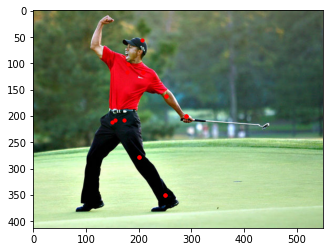

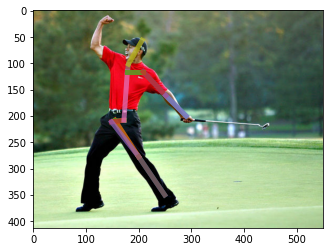

In [7]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

print('슝=3')

def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

print('슝=3')

def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

print('슝=3')

def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

print('슝=3')

def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

print('슝=3')

test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

- Hourglass 모델 (Stacked Hourglass Networks)
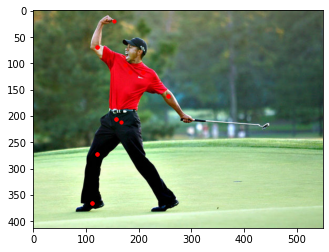
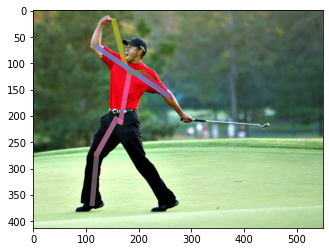


- simplebaseline 모델
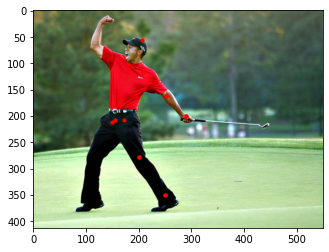
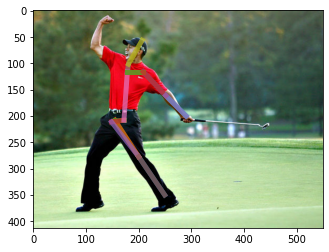

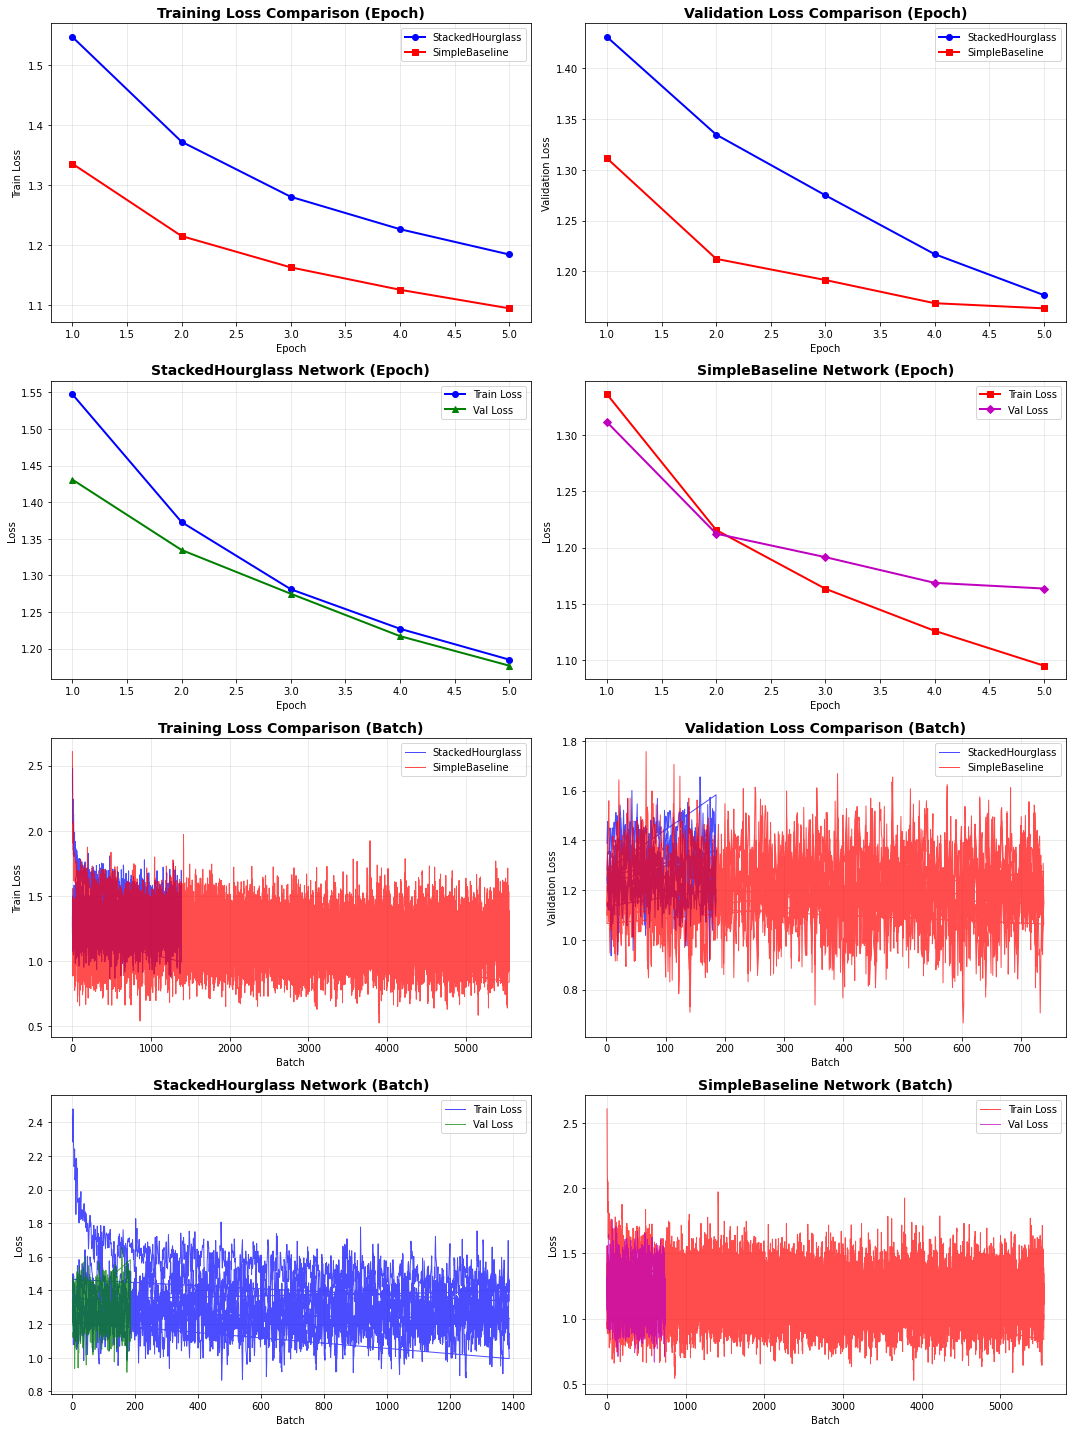

=== 훈련 결과 요약 ===

StackedHourglass Network:
  최종 Train Loss: 1.1850
  최종 Val Loss: 1.1767
  Train Loss 개선: 0.3624
  Val Loss 개선: 0.2540

SimpleBaseline Network:
  최종 Train Loss: 1.0952
  최종 Val Loss: 1.1637
  Train Loss 개선: 0.2409
  Val Loss 개선: 0.1477

=== 모델 비교 ===
SimpleBaseline이 더 좋은 성능 (Val Loss 차이: 0.0131)


In [12]:
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_training_log(file_path):
    """
    훈련 로그 파일에서 epoch별, batch별 train loss와 validation loss를 추출하는 함수
    """
    train_losses = []
    val_losses = []
    epochs = []
    
    # Batch별 데이터
    batch_train_losses = []
    batch_val_losses = []
    batch_train_numbers = []
    batch_val_numbers = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    
    # Epoch train loss 패턴 찾기 (예: "Epoch 1 train loss 1.547337293624878")
    train_pattern = r'Epoch (\d+) train loss ([\d.]+)'
    train_matches = re.findall(train_pattern, content)
    
    # Epoch validation loss 패턴 찾기 (예: "Epoch 1 val loss 1.4307597875595093")
    val_pattern = r'Epoch (\d+) val loss ([\d.]+)'
    val_matches = re.findall(val_pattern, content)
    
    # Batch train loss 패턴 찾기 (예: "Trained batch 1 batch loss 2.43541765")
    batch_train_pattern = r'Trained batch (\d+) batch loss ([\d.]+)'
    batch_train_matches = re.findall(batch_train_pattern, content)
    
    # Batch validation loss 패턴 찾기 (예: "Validated batch 1 batch loss 1.38798368")
    batch_val_pattern = r'Validated batch (\d+) batch loss ([\d.]+)'
    batch_val_matches = re.findall(batch_val_pattern, content)
    
    # Epoch 데이터 정리
    for epoch, loss in train_matches:
        epochs.append(int(epoch))
        train_losses.append(float(loss))
    
    for epoch, loss in val_matches:
        val_losses.append(float(loss))
    
    # Batch 데이터 정리
    for batch_num, loss in batch_train_matches:
        batch_train_numbers.append(int(batch_num))
        batch_train_losses.append(float(loss))
    
    for batch_num, loss in batch_val_matches:
        batch_val_numbers.append(int(batch_num))
        batch_val_losses.append(float(loss))
    
    return epochs, train_losses, val_losses, batch_train_numbers, batch_train_losses, batch_val_numbers, batch_val_losses

def plot_training_comparison(stacked_file, simple_file):
    """
    두 모델의 훈련 과정을 비교하는 그래프를 생성하는 함수
    """
    # 데이터 추출
    epochs_stacked, train_stacked, val_stacked, batch_train_num_stacked, batch_train_stacked, batch_val_num_stacked, batch_val_stacked = parse_training_log(stacked_file)
    epochs_simple, train_simple, val_simple, batch_train_num_simple, batch_train_simple, batch_val_num_simple, batch_val_simple = parse_training_log(simple_file)
    
    # 그래프 설정 (4x2 = 8개 서브플롯)
    plt.figure(figsize=(15, 20))
    
    # 1. Train Loss 비교 (epoch)
    plt.subplot(4, 2, 1)
    plt.plot(epochs_stacked, train_stacked, 'b-o', label='StackedHourglass', linewidth=2, markersize=6)
    plt.plot(epochs_simple, train_simple, 'r-s', label='SimpleBaseline', linewidth=2, markersize=6)
    plt.title('Training Loss Comparison (Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Validation Loss 비교 (epoch)
    plt.subplot(4, 2, 2)
    plt.plot(epochs_stacked, val_stacked, 'b-o', label='StackedHourglass', linewidth=2, markersize=6)
    plt.plot(epochs_simple, val_simple, 'r-s', label='SimpleBaseline', linewidth=2, markersize=6)
    plt.title('Validation Loss Comparison (Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. StackedHourglass 전체 Loss (epoch)
    plt.subplot(4, 2, 3)
    plt.plot(epochs_stacked, train_stacked, 'b-o', label='Train Loss', linewidth=2, markersize=6)
    plt.plot(epochs_stacked, val_stacked, 'g-^', label='Val Loss', linewidth=2, markersize=6)
    plt.title('StackedHourglass Network (Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. SimpleBaseline 전체 Loss (epoch)
    plt.subplot(4, 2, 4)
    plt.plot(epochs_simple, train_simple, 'r-s', label='Train Loss', linewidth=2, markersize=6)
    plt.plot(epochs_simple, val_simple, 'm-D', label='Val Loss', linewidth=2, markersize=6)
    plt.title('SimpleBaseline Network (Epoch)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. Train Loss 비교 (batch)
    plt.subplot(4, 2, 5)
    plt.plot(batch_train_num_stacked, batch_train_stacked, 'b-', label='StackedHourglass', linewidth=1, alpha=0.7)
    plt.plot(batch_train_num_simple, batch_train_simple, 'r-', label='SimpleBaseline', linewidth=1, alpha=0.7)
    plt.title('Training Loss Comparison (Batch)', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Train Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Validation Loss 비교 (batch)
    plt.subplot(4, 2, 6)
    plt.plot(batch_val_num_stacked, batch_val_stacked, 'b-', label='StackedHourglass', linewidth=1, alpha=0.7)
    plt.plot(batch_val_num_simple, batch_val_simple, 'r-', label='SimpleBaseline', linewidth=1, alpha=0.7)
    plt.title('Validation Loss Comparison (Batch)', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. StackedHourglass 전체 Loss (batch)
    plt.subplot(4, 2, 7)
    plt.plot(batch_train_num_stacked, batch_train_stacked, 'b-', label='Train Loss', linewidth=1, alpha=0.7)
    plt.plot(batch_val_num_stacked, batch_val_stacked, 'g-', label='Val Loss', linewidth=1, alpha=0.7)
    plt.title('StackedHourglass Network (Batch)', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 8. SimpleBaseline 전체 Loss (batch)
    plt.subplot(4, 2, 8)
    plt.plot(batch_train_num_simple, batch_train_simple, 'r-', label='Train Loss', linewidth=1, alpha=0.7)
    plt.plot(batch_val_num_simple, batch_val_simple, 'm-', label='Val Loss', linewidth=1, alpha=0.7)
    plt.title('SimpleBaseline Network (Batch)', fontsize=14, fontweight='bold')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 수치 비교 출력
    print("=== 훈련 결과 요약 ===")
    print(f"\nStackedHourglass Network:")
    print(f"  최종 Train Loss: {train_stacked[-1]:.4f}")
    print(f"  최종 Val Loss: {val_stacked[-1]:.4f}")
    print(f"  Train Loss 개선: {train_stacked[0] - train_stacked[-1]:.4f}")
    print(f"  Val Loss 개선: {val_stacked[0] - val_stacked[-1]:.4f}")
    
    print(f"\nSimpleBaseline Network:")
    print(f"  최종 Train Loss: {train_simple[-1]:.4f}")
    print(f"  최종 Val Loss: {val_simple[-1]:.4f}")
    print(f"  Train Loss 개선: {train_simple[0] - train_simple[-1]:.4f}")
    print(f"  Val Loss 개선: {val_simple[0] - val_simple[-1]:.4f}")
    
    # 성능 비교
    print(f"\n=== 모델 비교 ===")
    if val_stacked[-1] < val_simple[-1]:
        print(f"StackedHourglass가 더 좋은 성능 (Val Loss 차이: {val_simple[-1] - val_stacked[-1]:.4f})")
    else:
        print(f"SimpleBaseline이 더 좋은 성능 (Val Loss 차이: {val_stacked[-1] - val_simple[-1]:.4f})")

# 사용 예시
if __name__ == "__main__":
    # 파일 경로 설정 (실제 파일 경로로 변경하세요)
    stacked_file = "StackedHourglass Network_train.txt"
    simple_file = "Simplebaseline_train.txt"
    
    # 그래프 생성
    plot_training_comparison(stacked_file, simple_file)
    
    # 개별적으로 데이터 확인하고 싶다면:
    # epochs_stacked, train_stacked, val_stacked, batch_train_num_stacked, batch_train_stacked, batch_val_num_stacked, batch_val_stacked = parse_training_log(stacked_file)
    # epochs_simple, train_simple, val_simple, batch_train_num_simple, batch_train_simple, batch_val_num_simple, batch_val_simple = parse_training_log(simple_file)
    # print("StackedHourglass - Train Losses:", train_stacked)
    # print("StackedHourglass - Val Losses:", val_stacked)
    # print("SimpleBaseline - Train Losses:", train_simple)
    # print("SimpleBaseline - Val Losses:", val_simple)

#### 회고
- StackedHourglass Network는 학습 노드에서 직접 돌림
- 물론 Simplebaseline은 batch size를 줄여서 두 모델을 직접 비교하긴 힘들겠지만 신기하게 loss는 서로 비슷했음
- 두 모델 다 5 epochs로는 제대로 학습시키기에 부족했고 모델의 안정성은 확실히 StackedHourglass Network가 좋은 것 같음
- 그래서 한번 Simplebaseline에 맞는 학습을 진행시키고 싶었음

#### 번외
- SimplebaselineTrainer 메소드 : 논문에 맞춰 작성됨
- 30 epochs까지 돌림
- 결과적으로 9번째 epoch부터 과적합이 시작됨
    - 논문에서 사용한 데이터가 다르기 때문에 설정 변경 불가피 (ex. 하이퍼파라미터 튜닝)
- 매 batch마다 출력이 나와 verbose 옵션 넣음

In [5]:
# Simple Baseline 모델 학습을 위한 수정된 코드

import os
import math
import tensorflow as tf

# 앞서 만든 Simplebaseline 모델 import (같은 파일에 있다고 가정)
# from simplebaseline import Simplebaseline

class SimplebaselineTrainer(object):
    """Simple Baseline 모델을 위한 수정된 Trainer 클래스"""
    
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                 verbose=1):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.verbose = verbose  # 0: 출력 없음, 1: epoch만, 2: 모든 배치
        
        # MSE Loss (reduction=NONE for distributed training)
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        """Learning rate decay with patience"""
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1
        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        """Step-wise learning rate decay (논문에서 사용한 방식)"""
        # 논문: 90 epoch에서 1e-4, 120 epoch에서 1e-5로 변경
        if epoch == 90 or epoch == 120:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, output):
        """
        Simple Baseline용 loss 계산
        - Single output이므로 반복문 제거
        - Weighted MSE loss 적용
        """
        # keypoint visibility에 따른 weight 적용
        weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
        
        # MSE loss with weights
        loss = tf.reduce_mean(
            tf.square(labels - output) * weights
        ) * (1. / self.global_batch_size)
        
        return loss

    def train_step(self, inputs):
        """Training step"""
        images, labels = inputs
        
        with tf.GradientTape() as tape:
            # Single output (not list like Hourglass)
            output = self.model(images, training=True)
            loss = self.compute_loss(labels, output)

        # Gradient computation and update
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        """Validation step"""
        images, labels = inputs
        output = self.model(images, training=False)
        loss = self.compute_loss(labels, output)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        """Main training loop"""
        
        @tf.function
        def distributed_train_epoch(dataset):
            if self.verbose >= 1:
                tf.print('Start distributed training...')
            total_loss = 0.0
            num_train_batches = 0.0
            
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch,))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                
                # verbose 조건부 출력
                if self.verbose >= 2:
                    tf.print('Trained batch', num_train_batches, 
                            'batch loss', batch_loss, 
                            'epoch total loss', total_loss / num_train_batches)
                elif self.verbose >= 1 and tf.equal(tf.cast(num_train_batches, tf.int32) % 100, 0):
                    tf.print('Trained batch', num_train_batches, 
                            'batch loss', batch_loss, 
                            'epoch total loss', total_loss / num_train_batches)
            
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            if self.verbose >= 1:
                tf.print('Start validation...')
            total_loss = 0.0
            num_val_batches = 0.0
            
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch,))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                
                if not tf.math.is_nan(batch_loss):
                    total_loss += batch_loss
                    num_val_batches += 1  # 먼저 증가
            
            # 그 다음에 출력 조건 체크
                # verbose 조건부 출력
                if self.verbose >= 2:
                    tf.print('Validated batch', num_val_batches, 
                            'batch loss', batch_loss)
                elif self.verbose >= 1 and tf.equal(tf.cast(num_val_batches, tf.int32) % 50, 0):
                    tf.print('Validated batch', num_val_batches, 
                            'batch loss', batch_loss)
                
            return total_loss, num_val_batches

        # Training loop
        for epoch in range(1, self.epochs + 1):
            # 논문 방식의 learning rate decay 사용
            self.lr_decay_step(epoch)
            
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            # Training
            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            # Validation
            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # Save best model
            if val_loss < self.lowest_val_loss:
#                 self.save_model(epoch, val_loss)#∵ 'Read-only file system'
                self.lowest_val_loss = val_loss
            
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        """Model checkpoint saving"""
        model_name = MODEL_PATH + '/simplebaseline-epoch-{}-loss-{:.4f}.h5'.format(
            epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


def train_simplebaseline(epochs, learning_rate, num_heatmap, batch_size, 
                        train_tfrecords, val_tfrecords, verbose=1):
    """Simple Baseline 모델 학습 함수
    
    Args:
        verbose (int): 0=출력없음, 1=epoch별+100배치마다 훈련/50배치마다 검증, 2=모든배치
    """
    
    # 분산 전략 설정
    strategy = tf.distribute.MirroredStrategy()
    print(f'Number of devices: {strategy.num_replicas_in_sync}')
    
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    
    # 데이터셋 생성
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    # 모델 저장 경로 생성
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    # 분산 전략 scope 내에서 모델 생성 및 학습
    with strategy.scope():
        # 분산 데이터셋 생성
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

        # Simple Baseline 모델 생성
        model = Simplebaseline(input_shape=IMAGE_SHAPE)
        
        print("Simple Baseline Model Summary:")
        model.summary()

        # 트레이너 생성
        trainer = SimplebaselineTrainer(
            model=model,
            epochs=epochs,
            global_batch_size=global_batch_size,
            strategy=strategy,
            initial_learning_rate=learning_rate,
            verbose=verbose
        )

        print('Start Simple Baseline training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)


# 학습 실행
if __name__ == "__main__":
    # 논문에서 사용한 하이퍼파라미터
    IMAGE_SHAPE = (256, 256, 3)  # 또는 (384, 288, 3)
    HEATMAP_SIZE = (64, 64)      # 또는 (96, 72)
    
    train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
    val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
    
    # 논문 기본 설정
    epochs = 140           # 논문: 140 epochs
    batch_size = 32        # 논문: 128 (4 GPUs에서)
    num_heatmap = 16       # MPII 데이터셋
    learning_rate = 1e-3   # 논문: 1e-3 → 1e-4 (90 epoch) → 1e-5 (120 epoch)
    
    print("=== Simple Baseline Training Configuration ===")
    print(f"Image shape: {IMAGE_SHAPE}")
    print(f"Heatmap size: {HEATMAP_SIZE}")
    print(f"Epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Learning rate: {learning_rate}")
    print(f"Number of heatmaps: {num_heatmap}")
    
    # 학습 시작
    verbose = 1  # 0: 출력없음, 1: 100배치마다 훈련+50배치마다 검증, 2: 모든배치
    best_model_file = train_simplebaseline(
        epochs=epochs,
        learning_rate=learning_rate, 
        num_heatmap=num_heatmap,
        batch_size=batch_size,
        train_tfrecords=train_tfrecords,
        val_tfrecords=val_tfrecords,
        verbose=verbose
    )
    
    print(f"Training completed! Best model saved at: {best_model_file}")

=== Simple Baseline Training Configuration ===
Image shape: (256, 256, 3)
Heatmap size: (64, 64)
Epochs: 140
Batch size: 32
Learning rate: 0.001
Number of heatmaps: 16
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed training...
Trained batch 100 batch loss 0.181621611 epoch total loss 0.195470154
Trained batch 200 batch loss 0.174935266 epoch total loss 0.186528906
Trained batch 300 batch loss 0.170150921 epoch total loss 0.181262076
Trained batch 400 batch loss 0.181060165 epoch total loss 0.178370342
Trained batch 500 batch loss 0.171544 epoch total loss 0.175329715
Trained batch 600 batch loss 0.156940579 epoch total loss 0.173182324
Epoch 1 train loss 0.17153726518154144
Start validation...
Validated batch 50 batch loss 0.170269564
Epoch 1 val loss 0.17138712108135223
Start epoch 2 with learning rate 0.001
Start distributed training...
Trained batch 100 batch loss 0.156726599 epoch total loss 0.15766789
Trained batch 200 batch loss 0.158980221 epoch total loss 0.158162102
Trained batch 300 batch loss 0.153278828 epoch total loss 0.157361567
Trained batch 400 batch loss 0.153873935 epoch total loss 0.156149298
Trained batch 500 batch loss 0.131551802 epoch total loss 0.1554258

Trained batch 200 batch loss 0.118585549 epoch total loss 0.111796848
Trained batch 300 batch loss 0.107616752 epoch total loss 0.112525091
Trained batch 400 batch loss 0.0957238302 epoch total loss 0.111572415
Trained batch 500 batch loss 0.114650756 epoch total loss 0.112352483
Trained batch 600 batch loss 0.111227378 epoch total loss 0.112747282
Epoch 14 train loss 0.1128663718700409
Start validation...
Validated batch 50 batch loss 0.152316436
Epoch 14 val loss 0.1445102095603943
Start epoch 15 with learning rate 0.001
Start distributed training...
Trained batch 100 batch loss 0.0860408098 epoch total loss 0.104641207
Trained batch 200 batch loss 0.117655069 epoch total loss 0.106844246
Trained batch 300 batch loss 0.108832739 epoch total loss 0.107477479
Trained batch 400 batch loss 0.108749591 epoch total loss 0.107983649
Trained batch 500 batch loss 0.104471788 epoch total loss 0.108724102
Trained batch 600 batch loss 0.118722513 epoch total loss 0.109539881
Epoch 15 train loss 

Trained batch 200 batch loss 0.0935324654 epoch total loss 0.0809941217
Trained batch 300 batch loss 0.0815564245 epoch total loss 0.0820256621
Trained batch 400 batch loss 0.088542074 epoch total loss 0.0825519785
Trained batch 500 batch loss 0.0787603706 epoch total loss 0.083000876
Trained batch 600 batch loss 0.0854611546 epoch total loss 0.0830397159
Epoch 27 train loss 0.08286628127098083
Start validation...
Validated batch 50 batch loss 0.150965139
Epoch 27 val loss 0.15259218215942383
Start epoch 28 with learning rate 0.001
Start distributed training...
Trained batch 100 batch loss 0.0754581466 epoch total loss 0.0784964785
Trained batch 200 batch loss 0.0838344395 epoch total loss 0.0792693347
Trained batch 300 batch loss 0.0862770602 epoch total loss 0.0804784819
Trained batch 400 batch loss 0.0830766857 epoch total loss 0.0810542554
Trained batch 500 batch loss 0.0768787563 epoch total loss 0.0810318068
Trained batch 600 batch loss 0.075167805 epoch total loss 0.0812151954
E

KeyboardInterrupt: 